<a href="https://colab.research.google.com/github/vir-dom/Artificial_Incoherence/blob/main/deeplearning_artificial_incoherence_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hello! This is the project of the team called Artificial Incoherence, for our Deep Learning class. Our names are (with neptun codes): Virsinger Dominika (RSABSD), Medgyes Csaba (RF8I8P) and Bálint Gergő (O78UXU). For later Python updates here we should collect all the necessary packages and functions.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from numpy import savetxt
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import pickle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import initializers
from tensorflow.keras.models import Model
import tensorflow as tf

#This allows us to connect Drive with Colab. A pop-up will ask you for signing in and authorizing it.
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Data collecting and references

Now we want to import out dataset from Kaggle. It contains about 20000 labeled images of faces, considering ethnicity, age, gender. It has certain encoding in its filename, so we should import their names also. If you want to get more information from the dataset see: https://susanqq.github.io/UTKFace/ and https://www.kaggle.com/datasets/jangedoo/utkface-new?fbclid=IwAR0X1gR-ad1WuZH2QymWFyu_6ZIPmyj4m-9Y8H-5gn4f4kDD5BE8dm2xPJQ, now we only mention the necessary part for the code.

The labels of each face image is embedded in the file name, formated like [age]_[gender]_[race]_[date&time].jpg

- [age] is an integer from $0$ to $116$, indicating the age
- [gender] is either $0$ (male) or $1$ (female)
- [race] is an integer from $0$ to $4$, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
- [date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

We have many options. We suggested that for all target variable (age, gender, race) we use a seperate model, but we are not sure yet. We will clarify this later before the modelling part. Since our dataset is publicly available we should import it from Kaggle.

During our project we will reference the following articles/webpages:
- https://arxiv.org/pdf/2008.05756.pdf
- https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/

*The following 4 sections are only there for demonstration purposes only, for demonstrating how we got the normalized data, which we saved in our Google Drive. We would not recommend running it until the first Model (CNN Model).*

You can find the Google Drive folder at: https://drive.google.com/drive/folders/1nQd8xP1kmc9ilUf_cSv8mgk4M9D-Nx8S?usp=sharing.

# Data processing



First we create a dataframe, where the key values are going to be the image names, and next to those will appear the age, gender and race attributes. This dataframe will be used to make an exploratory data analysis, and to split the images into train and test sets. After that, we are going to use the RGB values of the pixels as attributes.

We downloaded the UTKFace dataset from kaggle, and then we uploaded the images to Google Drive to share those with each other. We also loaded the images into colab from Drive, this can be seen below.

In [ ]:
path_current = '/content/drive/MyDrive/archive/UTKFace'

os.chdir(path_current)

image_names = os.listdir(path_current)

In [ ]:
print(len(image_names))
print(image_names[:3])

23720
['82_0_1_20170111210240036.jpg.chip.jpg', '7_0_0_20170110225021990.jpg.chip.jpg', '90_0_0_20170117174931541.jpg.chip.jpg']


We need to exclude the 3 cases when the race is not included (temp(2) does not exist in this case.)

In [ ]:
np.random.seed(23)
np.random.shuffle(image_names)

age_labels, gender_labels, race_labels, image_path = [], [], [], []

for image_name in image_names:
    image_path.append(image_name)
    temp = image_name.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])
    if len(image_name) < 36:        #the name of the picture should be at least 36 characters, if none of the labels are missing
      race_labels.append("somethingiswrong")
    else:
      race_labels.append(temp[2])

In [ ]:
image_path[0:5]

['49_0_0_20170104184239893.jpg.chip.jpg',
 '65_0_3_20170117191735066.jpg.chip.jpg',
 '26_0_1_20170117195724773.jpg.chip.jpg',
 '2_1_0_20170109192428145.jpg.chip.jpg',
 '24_0_3_20170104214346781.jpg.chip.jpg']

Let's turn the unstructured data into a structured dataframe:

In [ ]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'], df['race'] = image_path, age_labels, gender_labels, race_labels

In [ ]:
df.head()

image age gender race
0  49_0_0_20170104184239893.jpg.chip.jpg  49      0    0
1  65_0_3_20170117191735066.jpg.chip.jpg  65      0    3
2  26_0_1_20170117195724773.jpg.chip.jpg  26      0    1
3   2_1_0_20170109192428145.jpg.chip.jpg   2      1    0
4  24_0_3_20170104214346781.jpg.chip.jpg  24      0    3

In [ ]:
gender_dict = {0:"Male",1:"Female"}
race_dict = {0:"White",1:"Black",2:"Asian",3:"Indian",4:"Other"}

Before we can set the types of the columns, we need to check whether there are any mistakes in the data (missing values or mistakes for example):

In [ ]:
df.describe()

image    age gender   race
count                                   23720  23720  23720  23720
unique                                  23720    106      3      6
top     49_0_0_20170104184239893.jpg.chip.jpg     26      0      0
freq                                        1   2197  12401  10088

Age has 106 unique values. This could be right according to the description of the data. Gender has 3 unique values, so it cannot be good. Race has 6 unique values, since we have 0,1,2,3,4 and 'somethingiswrong'.

In [ ]:
elements = []

for i in df['race']:
  if i not in elements:
    elements.append(i)
    
print(elements)

['0', '3', '1', '2', '4', 'somethingiswrong']


As we can see, there are three pictures where the race was not given in the image name. Regarding that we have 20k+ images, we can easily drop these three, so the missing values won't cause any problem.

In [ ]:
elements[5]

'somethingiswrong'

In [ ]:
df.drop(df[df['race'] == elements[5]].index, inplace=True)

In [ ]:
len(df)

23715

Let's check the data again:

In [ ]:
df.describe()

image    age gender   race
count                                   23715  23715  23715  23715
unique                                  23715    104      2      5
top     49_0_0_20170104184239893.jpg.chip.jpg     26      0      0
freq                                        1   2197  12401  10088

<p>As we can see, we corrected the mistakes.</p>
<p>Now we can set the type of the columns.</p>

In [ ]:
df = df.astype({'age':'int32', 'gender': 'int32', 'race': 'int32'})

Let's see how we can open an image:

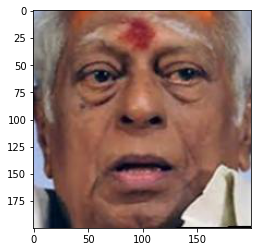

In [ ]:
img = Image.open(path_current+'/'+df.image[1])
plt.imshow(img)

Now let's see some images with the labels written above them:

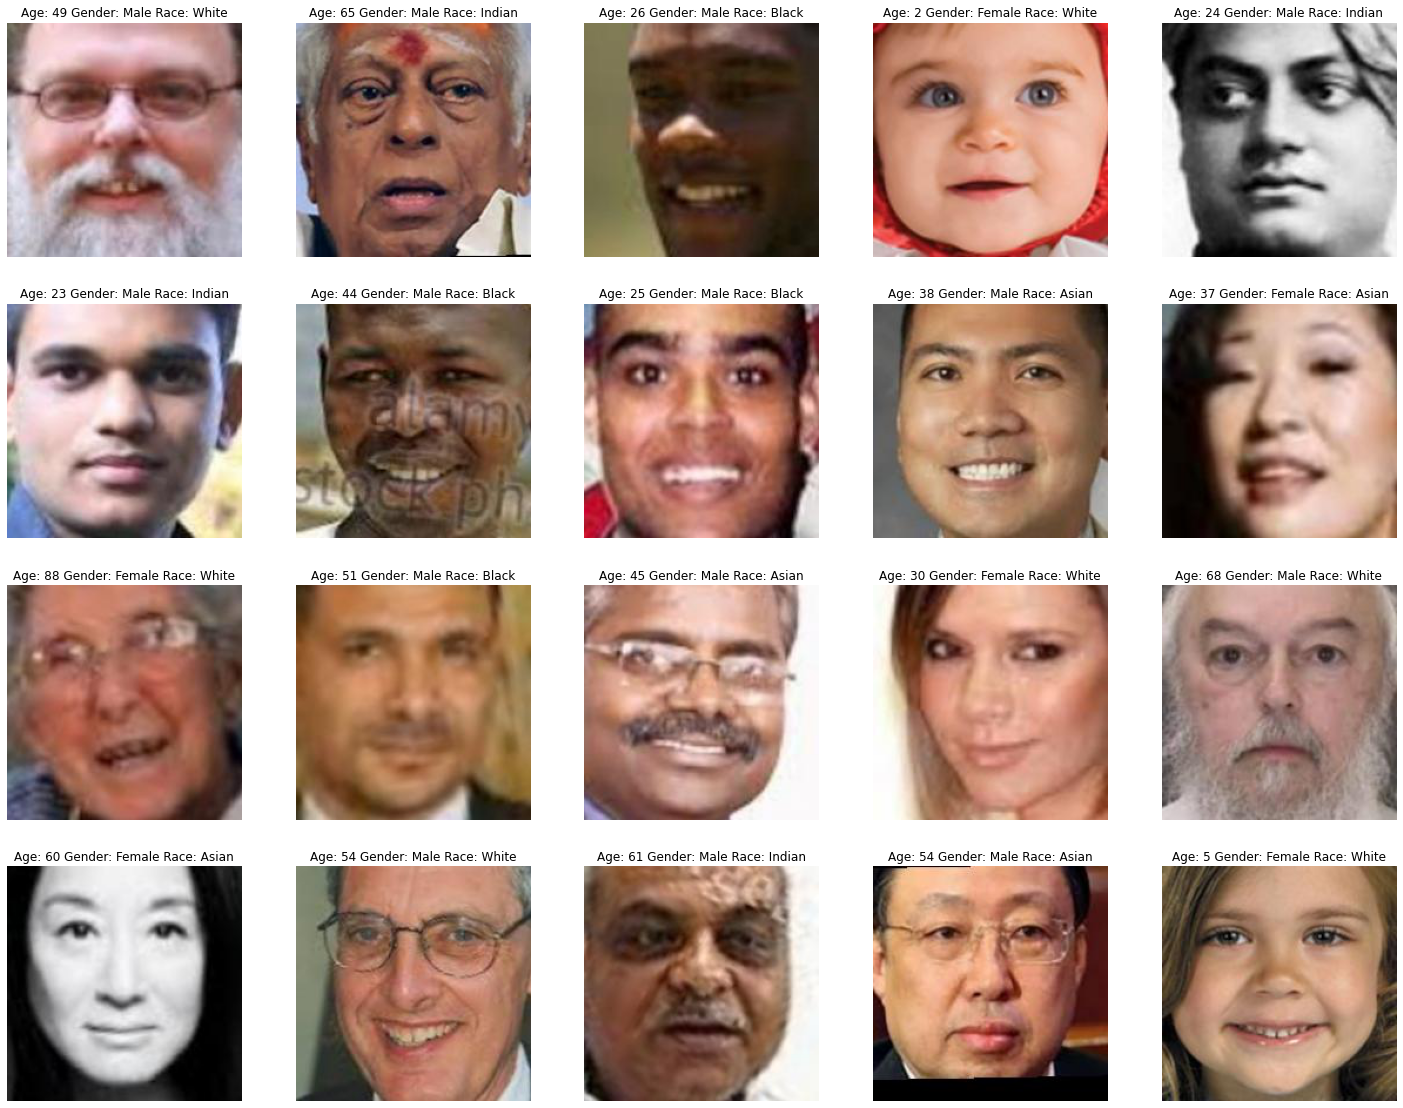

In [ ]:
files = df.iloc[0:20]
plt.figure(figsize=(25,25))
for index, file, age, gender, race in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img(path_current+'/'+file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]} Race: {race_dict[race]}")
    plt.axis('off')

#Exploratory data analysis

To understand better the given data, it is very common to make some plots regarding the target variables (labels).

In [ ]:
print("Statistics of age attribute:")
print(df.age.describe())

Statistics of age attribute:
count    23715.000000
mean        33.298672
std         19.881813
min          1.000000
25%         23.000000
50%         29.000000
75%         45.000000
max        116.000000
Name: age, dtype: float64


In [ ]:
#making a dict where we count the occurences of the ages

age_count = dict()
for i in df['age']:
  age_count[i] = age_count.get(i, 0) + 1

In [ ]:
#making it sorted for plotting

age_count_sorted = dict(sorted(age_count.items()))

<BarContainer object of 104 artists>

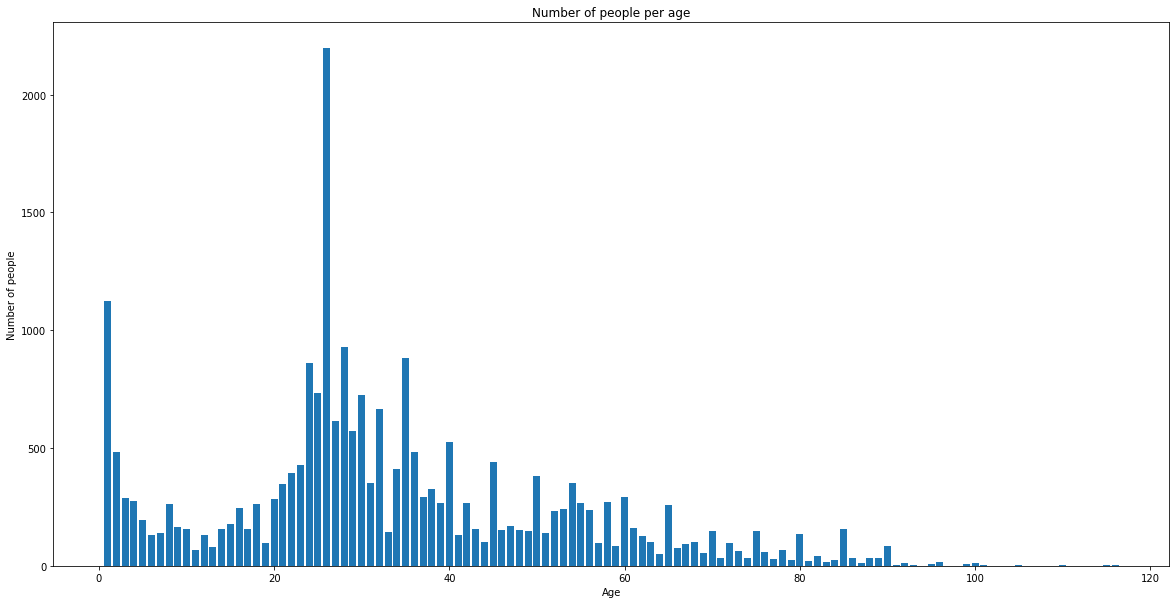

In [ ]:
#plotting the histogram

plt.figure(figsize=(20,10))
plt.title("Number of people per age")
plt.xlabel("Age")
plt.ylabel("Number of people")
plt.bar(age_count_sorted.keys(), age_count_sorted.values())

In [ ]:
#making a dict where we count the occurences of the races

race_count = dict()
for i in df['race']:
  race_count[i] = race_count.get(i, 0) + 1

In [ ]:
#making it sorted for plotting

race_count_sorted = dict(sorted(race_count.items()))

In [ ]:
race_count_sorted

{0: 10088, 1: 4526, 2: 3434, 3: 3975, 4: 1692}

In [ ]:
#changing the key values to the name of the races

v1 = race_count_sorted[0]
del race_count_sorted[0]
race_count_sorted['White'] = v1

v2 = race_count_sorted[1]
del race_count_sorted[1]
race_count_sorted['Black'] = v2

v3 = race_count_sorted[2]
del race_count_sorted[2]
race_count_sorted['Asian'] = v3

v4 = race_count_sorted[3]
del race_count_sorted[3]
race_count_sorted['Indian'] = v4

v5 = race_count_sorted[4]
del race_count_sorted[4]
race_count_sorted['Other'] = v5

In [ ]:
race_count_sorted

{'White': 10088, 'Black': 4526, 'Asian': 3434, 'Indian': 3975, 'Other': 1692}

<BarContainer object of 5 artists>

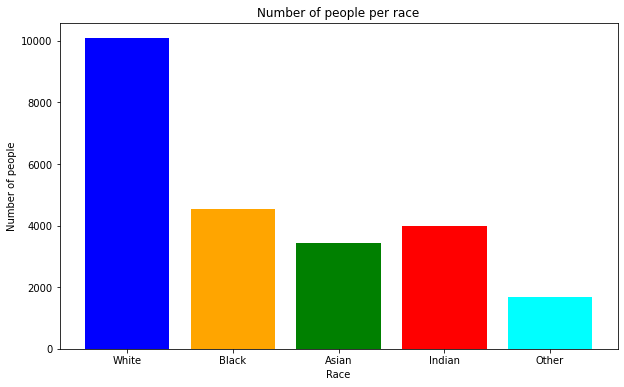

In [ ]:
#plotting the histogram

plt.figure(figsize=(10,6))
plt.title("Number of people per race")
plt.xlabel("Race")
plt.ylabel("Number of people")
plt.bar(race_count_sorted.keys(), race_count_sorted.values(), color=['blue','orange','green','red','cyan'])

In [ ]:
#making a dict where we count the occurences of the genders

gender_count = dict()
for i in df['gender']:
  gender_count[i] = gender_count.get(i, 0) + 1

In [ ]:
gender_count

{0: 12401, 1: 11314}

In [ ]:
#changing the key values to the name of the genders

v6 = gender_count[0]
del gender_count[0]
gender_count['Male'] = v6

v7 = gender_count[1]
del gender_count[1]
gender_count['Female'] = v7

<BarContainer object of 2 artists>

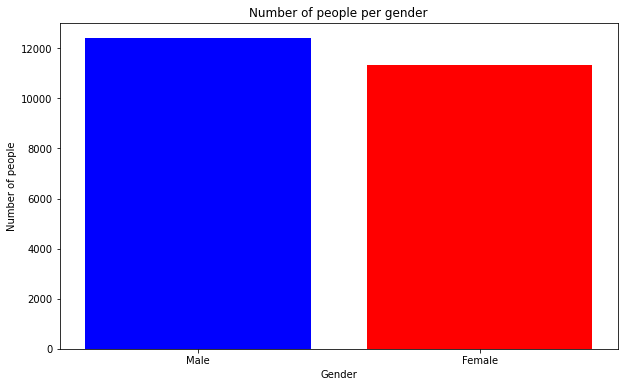

In [ ]:
#plotting the histogram

plt.figure(figsize=(10,6))
plt.title("Number of people per gender")
plt.xlabel("Gender")
plt.ylabel("Number of people")
plt.bar(gender_count.keys(), gender_count.values(),color=['blue', 'red'])

# Splitting data into train and test sets

We decided to split the data into train and test sets, and we do not make a validation set right now. It is because at modelling we will be able to easily give a percentage, what part of the training data to use as a validation set.

In [ ]:
train, test = train_test_split(df, train_size=0.8, random_state=42)

In [ ]:
print(len(train))
print(len(test))

18972
4743


Now we do not need just the name of the images but also the RGB values from the pixels, so let's import that data as well.

In [ ]:
train.image[0]

'2_0_1_20170110213724790.jpg.chip.jpg'

In [ ]:
X_list = [np.asarray(plt.imread(name)) for name in train.image]

X_train = np.array(X_list)

"\nfor file in train.image:\n    img = load_img(path_current+'/'+file)\n    img = np.array(img)\n    X_train.append(img)\n\nX_train = np.array(X_train)"

In [ ]:
X_train.shape

(18972, 200, 200, 3)

In [ ]:
# saving X_train as pickle file
fp = "./X_train.pkl"
with open(fp,mode="wb") as f:
    pickle.dump(X_train,f)

In [ ]:
X_list2 = [np.asarray(plt.imread(name)) for name in test.image]

X_test = np.array(X_list2)

In [ ]:
X_test.shape

(4743, 200, 200, 3)

In [ ]:
# saving X_test as pickle file
fp = "./X_test.pkl"
with open(fp,mode="wb") as f:
    pickle.dump(X_test,f)

Saving y_train from train dataframe

In [ ]:
train.head()

image  age  gender  race
18617  42_1_1_20170113001802155.jpg.chip.jpg   42       1     1
22153  42_1_1_20170112231620452.jpg.chip.jpg   42       1     1
5099   92_1_0_20170110183357210.jpg.chip.jpg   92       1     0
19590  32_1_3_20170104235736013.jpg.chip.jpg   32       1     3
16015  28_0_1_20170117165836339.jpg.chip.jpg   28       0     1
...                                      ...  ...     ...   ...
21578  34_0_3_20170119200717205.jpg.chip.jpg   34       0     3
5390   26_1_3_20170119193146682.jpg.chip.jpg   26       1     3
860    11_1_4_20170109201611941.jpg.chip.jpg   11       1     4
15795  25_1_0_20170117190527852.jpg.chip.jpg   25       1     0
23657  20_1_1_20170112191230798.jpg.chip.jpg   20       1     1

[18972 rows x 4 columns]

In [ ]:
y_train = train[['age','gender','race']]

In [ ]:
y_train.head()

age  gender  race
18617   42       1     1
22153   42       1     1
5099    92       1     0
19590   32       1     3
16015   28       0     1

In [ ]:
type(y_train)

pandas.core.frame.DataFrame

In [ ]:
# saving y_train as pickle file
fp = "./y_train.pkl"
with open(fp,mode="wb") as f:
    pickle.dump(y_train,f)

Saving y_test from test dataframe

In [ ]:
test

image  age  gender  race
4275   33_1_4_20170117174234414.jpg.chip.jpg   33       1     4
1147    1_0_2_20161219204836612.jpg.chip.jpg    1       0     2
1190    4_1_0_20170116200920314.jpg.chip.jpg    4       1     0
9733   15_0_0_20170104012102240.jpg.chip.jpg   15       0     0
7752   26_1_2_20170116180523022.jpg.chip.jpg   26       1     2
...                                      ...  ...     ...   ...
14238  23_1_3_20170104222224327.jpg.chip.jpg   23       1     3
20724   1_0_2_20161219200503284.jpg.chip.jpg    1       0     2
19032  47_1_0_20170117160407279.jpg.chip.jpg   47       1     0
4153   24_1_0_20170117150538420.jpg.chip.jpg   24       1     0
2943   28_1_2_20170116175907657.jpg.chip.jpg   28       1     2

[4743 rows x 4 columns]

In [ ]:
y_test= test[['age','gender','race']]

In [ ]:
y_test.head()

age  gender  race
4275   33       1     4
1147    1       0     2
1190    4       1     0
9733   15       0     0
7752   26       1     2

In [ ]:
# saving y_test as pickle file
fp = "./y_test.pkl"
with open(fp,mode="wb") as f:
    pickle.dump(y_test,f)

# Normalizing X_train and X_test data



We need our data converted into float 32 in our drive so later we only need to load this part and we can leave the previous parts alone.

Here we can reload the train and test data from the saved files, so we do not have to run all the codes from the beginning.

In [ ]:
#changing directory to MyDrive, where the files are
# loading X_train data 

#medcsab_path = '/content/drive/MyDrive/Deep_Files'
virdom_path = '/content/drive/MyDrive'

#os.chdir(medcsab_path)
os.chdir(virdom_path)

In [ ]:
# loading y_train data 
with open("./y_train.pkl","rb") as f:
    y_train = pickle.load(file=f)

In [ ]:
# loading y_test data 
with open("./y_test.pkl","rb") as f:
    y_test = pickle.load(file=f)

Let's take the y_train and y_test with all the 3 target variables apart, so that we have each target variable separated.

In [ ]:
y_train_age = y_train.age
y_train_gender = y_train.gender
y_train_race = y_train.race

y_test_age = y_test.age
y_test_gender = y_test.gender
y_test_race = y_test.race

In [ ]:
#y_train age stays as it is, but if we decide that it should not be a regression then
#we will have to convert the ages into categories (like 0-10, 10-20 and so on)
y_train_gender = to_categorical(y_train_gender,2)
y_train_race = to_categorical(y_train_gender,5)

y_test_gender = to_categorical(y_test_gender,2)
y_test_race = to_categorical(y_test_gender,5)

The next important step is to normalize the data. Due to the limited RAM we need to do this part in a particular order. First we just focus on the X_test, then save it to a file. Then we need to delete the variable from the memory to deal with X_train.

In [ ]:
# loading X_test data 
with open("./X_test.pkl","rb") as f:
    X_test = pickle.load(file=f)

In [ ]:
X_train[1]

array([ 23,  18,  24, ..., 181, 124,  95], dtype=uint8)

In [ ]:
X_test = X_test.reshape(-1,200*200*3)

In [ ]:
X_test.shape

(4743, 120000)

In [ ]:
X_test = X_test/255

In [ ]:
X_test = X_test.astype("float32")

In [ ]:
X_test[4]

array([0.30588236, 0.29803923, 0.30980393, ..., 0.1764706 , 0.12156863,
       0.10980392], dtype=float32)

In [ ]:
# saving X_test as pickle file
fp = "./X_test2.pkl"
with open(fp,mode="wb") as f:
    pickle.dump(X_test,f)

In [ ]:
#deleting the X_test variable from memory (it is already saved into file)
del X_test

<p>Now let's deal with X_train. It is too big to change the type at once, so we need to separate it into smaller pieces, convert those, and then concatenate the parts if needed.</p>
<p>
I am going to cut X_train into 4 parts, and do the normalization and change to float32 on each part separately. To deal with RAM, I need to delete variables to run the computations and after a part is done, I will save it to a file, so that I can delete the variable and have enough RAM for the next part.
</p>


Part 1 of X_train

In [ ]:
# loading X_train data
with open("./X_train.pkl","rb") as f:
    X_train = pickle.load(file=f)

In [ ]:
X_train_part1 = X_train[0:5000]

In [ ]:
del X_train

In [ ]:
X_train_part1.shape

(5000, 200, 200, 3)

In [ ]:
X_train_part1 = X_train_part1.reshape(-1,200*200*3)

In [ ]:
X_train_part1.shape

(5000, 120000)

In [ ]:
X_train_part1 = X_train_part1/255

In [ ]:
X_train_part1 = X_train_part1.astype("float32")

In [ ]:
X_train_part1[3]

array([0.42745098, 0.4       , 0.2901961 , ..., 0.30980393, 0.12941177,
       0.03529412], dtype=float32)

In [ ]:
# saving X_train_part1 as pickle file
fp = "./X_train_part1.pkl"
with open(fp,mode="wb") as f:
    pickle.dump(X_train_part1,f)

In [ ]:
del X_train_part1

Part 2 of X_train

In [ ]:
# loading X_train data
with open("./X_train.pkl","rb") as f:
    X_train = pickle.load(file=f)

In [ ]:
X_train_part2 = X_train[5000:10000]

In [ ]:
del X_train

In [ ]:
X_train_part2.shape

(5000, 200, 200, 3)

In [ ]:
X_train_part2 = X_train_part2.reshape(-1,200*200*3)

In [ ]:
X_train_part2.shape

(5000, 120000)

In [ ]:
X_train_part2 = X_train_part2/255

In [ ]:
X_train_part2 = X_train_part2.astype("float32")

In [ ]:
X_train_part2[3]

array([0.34901962, 0.1764706 , 0.16470589, ..., 0.9882353 , 0.90588236,
       0.8       ], dtype=float32)

In [ ]:
# saving X_train_part2 as pickle file
fp = "./X_train_part2.pkl"
with open(fp,mode="wb") as f:
    pickle.dump(X_train_part2,f)

In [ ]:
del X_train_part2

Part 3 of X_train

In [ ]:
# loading X_train data
with open("./X_train.pkl","rb") as f:
    X_train = pickle.load(file=f)

In [ ]:
X_train_part3 = X_train[10000:15000]

In [ ]:
del X_train

In [ ]:
X_train_part3.shape

(5000, 200, 200, 3)

In [ ]:
X_train_part3 = X_train_part3.reshape(-1,200*200*3)

In [ ]:
X_train_part3.shape

(5000, 120000)

In [ ]:
X_train_part3 = X_train_part3/255

In [ ]:
X_train_part3 = X_train_part3.astype("float32")

In [ ]:
X_train_part3[3]

array([0.7176471 , 0.73333335, 0.74509805, ..., 0.6039216 , 0.44313726,
       0.35686275], dtype=float32)

In [ ]:
# saving X_train_part3 as pickle file
fp = "./X_train_part3.pkl"
with open(fp,mode="wb") as f:
    pickle.dump(X_train_part3,f)

In [ ]:
del X_train_part3

Part 4 of X_train

In [ ]:
# loading X_train data
with open("./X_train.pkl","rb") as f:
    X_train = pickle.load(file=f)

In [ ]:
X_train_part4 = X_train[15000:]

In [ ]:
del X_train

In [ ]:
X_train_part4.shape

(3972, 200, 200, 3)

In [ ]:
X_train_part4 = X_train_part4.reshape(-1,200*200*3)

In [ ]:
X_train_part4.shape

(3972, 120000)

In [ ]:
X_train_part4 = X_train_part4/255

In [ ]:
X_train_part4 = X_train_part4.astype("float32")

In [ ]:
X_train_part4[3]

array([0.02745098, 0.06666667, 0.17254902, ..., 0.03137255, 0.03529412,
       0.04313726], dtype=float32)

In [ ]:
# saving X_train_part4 as pickle file
fp = "./X_train_part4.pkl"
with open(fp,mode="wb") as f:
    pickle.dump(X_train_part4,f)

In [ ]:
del X_train_part4

In [ ]:
# how to save once it is done
# saving y_test as pickle file
#fp = "./y_test.pkl"
#with open(fp,mode="wb") as f:
#    pickle.dump(y_test,f)

Now we have the train data: X_train_part1, X_train_part2, X_train_part3, X_train_part4, y_train_age, y_train_gender, y_train_race.
We also have the test data: X_test, y_test_age, y_test_gender, y_test_race.

As mentioned before, we decided not to make a validation dataset now, we are going to give a percetage at modelling (what part of the train data to use as validation).

# CNN learning

As you could see in the previous part we saved our normalized data into our machine, and it is uploaded into our Google Drive, so when we are modelling we only need to load the data. 

In [ ]:
path_current = '/content/drive/MyDrive/Artificial_Incoherence_float_data'

os.chdir(path_current)

os.listdir()

['inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'X_test2.pkl',
 'X_train_part1.pkl',
 'X_train_part2.pkl',
 'X_train_part3.pkl',
 'X_train_part4.pkl',
 'y_test.pkl',
 'y_train.pkl',
 'weights_v1.h5',
 'weights_xception1.h5',
 'weights_v2.h5',
 'model1_part1.h5',
 'model1_part2.h5',
 'model1_part3.h5',
 'model1_part4.h5']

In [ ]:
# loading X_train_part1 data 
with open("./X_train_part1.pkl","rb") as f:
    X_train_part1 = pickle.load(file=f)

In [ ]:
X_train_part1 = X_train_part1.reshape(-1,200,200,3)

In [ ]:
X_train_part1.shape

(5000, 200, 200, 3)

Loading y_train and separating it into 4 parts (same way as we did with the X_train).

In [ ]:
# loading y_train data 
with open("./y_train.pkl","rb") as f:
    y_train = pickle.load(file=f)

In [ ]:
y_train_part1 = y_train[:5000]
y_train_part2 = y_train[5000:10000]
y_train_part3 = y_train[10000:15000]
y_train_part4 = y_train[15000:]

In [ ]:
y_train.head()

age  gender  race
18617   42       1     1
22153   42       1     1
5099    92       1     0
19590   32       1     3
16015   28       0     1

<p>Now we have the training data in 4 parts (X_train_part1-2-3-4 and y_train_part1-2-3-4).</p>
<p>Let's take the y_train with all the 3 target variables apart, so that we have each target variable separated.</p>

In [ ]:
y_train_1_age = y_train_part1.age
y_train_1_gender = y_train_part1.gender
y_train_1_race = y_train_part1.race

y_train_2_age = y_train_part2.age
y_train_2_gender = y_train_part2.gender
y_train_2_race = y_train_part2.race

y_train_3_age = y_train_part3.age
y_train_3_gender = y_train_part3.gender
y_train_3_race = y_train_part3.race

y_train_4_age = y_train_part4.age
y_train_4_gender = y_train_part4.gender
y_train_4_race = y_train_part4.race

In [ ]:
y_train_1_race = to_categorical(y_train_1_race,5)

y_train_2_race = to_categorical(y_train_2_race,5)

y_train_3_race = to_categorical(y_train_3_race,5)

y_train_4_race = to_categorical(y_train_4_race,5)

Now we want to try modelling with the parts of the train data.

In [ ]:
input_size = (200,200,3)

In [ ]:
inputs = Input((input_size))

X = Conv2D(64, (3, 3), activation='relu', kernel_initializer = initializers.glorot_uniform(seed=0))(inputs)
X = MaxPooling2D((3, 3))(X)

X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Flatten()(X)

dense_1 = Dense(256, activation='relu')(X)
dense_2 = Dense(128, activation='relu')(dense_1)
dense_3 = Dense(256, activation='relu')(X)
dense_4 = Dense(256, activation='relu')(X)

dropout_1 = Dropout(0.4)(dense_2)
dropout_2 = Dropout(0.4)(dense_3)
dropout_3 = Dropout(0.4)(dense_4)

output_1 = Dense(1,activation='relu', name='age_output')(dropout_1)
output_2 = Dense(1, activation='sigmoid', name='gender_output')(dropout_2)
output_3 = Dense(5, activation='softmax', name='race_output')(dropout_3)

model = Model(inputs=[inputs], outputs=[output_1,output_2,output_3])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 198, 198, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 66, 66, 64)   0           ['conv2d[0][0]']                 
                                                                                              

In [ ]:
model.compile(loss=['mse','binary_crossentropy','categorical_crossentropy'], optimizer='adam', loss_weights = [0.001,0.5,0.5], 
              metrics = {'age_output': 'mean_squared_error', 'gender_output': 'accuracy', 'race_output': 'accuracy'})

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('model1_part1.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)  

In [ ]:
model_history = model.fit(x=X_train_part1,
                          y=[y_train_1_age, y_train_1_gender, y_train_1_race],
                          batch_size = 32,
                          epochs=50,
                          validation_split= 0.1,
                          callbacks = [es, save_best, plateau])

Epoch 1/50
141/141 [==============================] - 25s 96ms/step - loss: 1.5838 - age_output_loss: 499.2217 - gender_output_loss: 0.6972 - race_output_loss: 1.4719 - age_output_mean_squared_error: 499.2217 - gender_output_accuracy: 0.6016 - race_output_accuracy: 0.4287 - val_loss: 1.3184 - val_age_output_loss: 364.7827 - val_gender_output_loss: 0.6449 - val_race_output_loss: 1.2624 - val_age_output_mean_squared_error: 364.7827 - val_gender_output_accuracy: 0.6140 - val_race_output_accuracy: 0.5220 - lr: 0.0010
Epoch 2/50
141/141 [==============================] - 13s 89ms/step - loss: 1.2216 - age_output_loss: 302.7765 - gender_output_loss: 0.5390 - race_output_loss: 1.2987 - age_output_mean_squared_error: 302.7765 - gender_output_accuracy: 0.7273 - race_output_accuracy: 0.4942 - val_loss: 1.0231 - val_age_output_loss: 242.7855 - val_gender_output_loss: 0.4611 - val_race_output_loss: 1.0996 - val_age_output_mean_squared_error: 242.7855 - val_gender_output_accuracy: 0.7840 - val_race

Now let's continue the training on the second part of the training data.

In [ ]:
del X_train_part1

In [ ]:
from keras.models import load_model

model = load_model('model1_part1.h5')

In [ ]:
# loading X_train_part2 data 
with open("./X_train_part2.pkl","rb") as f:
    X_train_part2 = pickle.load(file=f)

In [ ]:
X_train_part2 = X_train_part2.reshape(-1,200,200,3)

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('model1_part2.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)  

In [ ]:
model_history = model.fit(x=X_train_part2,
                          y=[y_train_2_age, y_train_2_gender, y_train_2_race],
                          batch_size = 32,
                          epochs=50,
                          validation_split= 0.1,
                          callbacks = [es, save_best, plateau])

Epoch 1/50
141/141 [==============================] - 13s 91ms/step - loss: 0.7232 - age_output_loss: 144.7147 - gender_output_loss: 0.3386 - race_output_loss: 0.8183 - age_output_mean_squared_error: 144.7147 - gender_output_accuracy: 0.8593 - race_output_accuracy: 0.7280 - val_loss: 0.6242 - val_age_output_loss: 114.0935 - val_gender_output_loss: 0.3249 - val_race_output_loss: 0.6954 - val_age_output_mean_squared_error: 114.0935 - val_gender_output_accuracy: 0.8660 - val_race_output_accuracy: 0.7660 - lr: 9.0000e-05
Epoch 2/50
141/141 [==============================] - 13s 91ms/step - loss: 0.6613 - age_output_loss: 128.8361 - gender_output_loss: 0.2962 - race_output_loss: 0.7687 - age_output_mean_squared_error: 128.8361 - gender_output_accuracy: 0.8693 - race_output_accuracy: 0.7356 - val_loss: 0.6090 - val_age_output_loss: 108.5061 - val_gender_output_loss: 0.3109 - val_race_output_loss: 0.6901 - val_age_output_mean_squared_error: 108.5061 - val_gender_output_accuracy: 0.8680 - val_

Now let's continue the training on the third part of the training data.

In [ ]:
del X_train_part2

In [ ]:
from keras.models import load_model

model = load_model('model1_part2.h5')

In [ ]:
# loading X_train_part3 data 
with open("./X_train_part3.pkl","rb") as f:
    X_train_part3 = pickle.load(file=f)

In [ ]:
X_train_part3 = X_train_part3.reshape(-1,200,200,3)

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('model1_part3.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)  

In [ ]:
model_history = model.fit(x=X_train_part3,
                          y=[y_train_3_age, y_train_3_gender, y_train_3_race],
                          batch_size = 32,
                          epochs=50,
                          validation_split= 0.1,
                          callbacks = [es, save_best, plateau])

Epoch 1/50
141/141 [==============================] - 23s 97ms/step - loss: 0.6422 - age_output_loss: 122.9928 - gender_output_loss: 0.2826 - race_output_loss: 0.7557 - age_output_mean_squared_error: 122.9928 - gender_output_accuracy: 0.8764 - race_output_accuracy: 0.7431 - val_loss: 0.5788 - val_age_output_loss: 104.7653 - val_gender_output_loss: 0.2586 - val_race_output_loss: 0.6895 - val_age_output_mean_squared_error: 104.7653 - val_gender_output_accuracy: 0.8860 - val_race_output_accuracy: 0.7860 - lr: 9.0000e-05
Epoch 2/50
141/141 [==============================] - 13s 90ms/step - loss: 0.5996 - age_output_loss: 113.5040 - gender_output_loss: 0.2594 - race_output_loss: 0.7129 - age_output_mean_squared_error: 113.5040 - gender_output_accuracy: 0.8889 - race_output_accuracy: 0.7576 - val_loss: 0.5663 - val_age_output_loss: 101.2532 - val_gender_output_loss: 0.2546 - val_race_output_loss: 0.6755 - val_age_output_mean_squared_error: 101.2532 - val_gender_output_accuracy: 0.8880 - val_

Now let's continue the training on the fourth part of the training data.

In [ ]:
del X_train_part3

In [ ]:
from keras.models import load_model

model = load_model('model1_part3.h5')

In [ ]:
# loading X_train_part4 data 
with open("./X_train_part4.pkl","rb") as f:
    X_train_part4 = pickle.load(file=f)

In [ ]:
X_train_part4 = X_train_part4.reshape(-1,200,200,3)

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('model1_part4.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)  

In [ ]:
model_history = model.fit(x=X_train_part4,
                          y=[y_train_4_age, y_train_4_gender, y_train_4_race],
                          batch_size = 32,
                          epochs=50,
                          validation_split= 0.1,
                          callbacks = [es, save_best, plateau])

Epoch 1/50
112/112 [==============================] - 31s 193ms/step - loss: 0.5979 - age_output_loss: 114.8685 - gender_output_loss: 0.2591 - race_output_loss: 0.7069 - age_output_mean_squared_error: 114.8685 - gender_output_accuracy: 0.8903 - race_output_accuracy: 0.7652 - val_loss: 0.5302 - val_age_output_loss: 77.7166 - val_gender_output_loss: 0.2773 - val_race_output_loss: 0.6276 - val_age_output_mean_squared_error: 77.7166 - val_gender_output_accuracy: 0.8844 - val_race_output_accuracy: 0.7839 - lr: 8.1000e-06
Epoch 2/50
112/112 [==============================] - 11s 96ms/step - loss: 0.5823 - age_output_loss: 108.4139 - gender_output_loss: 0.2545 - race_output_loss: 0.6933 - age_output_mean_squared_error: 108.4139 - gender_output_accuracy: 0.8909 - race_output_accuracy: 0.7703 - val_loss: 0.5291 - val_age_output_loss: 77.8022 - val_gender_output_loss: 0.2753 - val_race_output_loss: 0.6274 - val_age_output_mean_squared_error: 77.8022 - val_gender_output_accuracy: 0.8869 - val_rac

# Evaluating the CNN model (saved as model1_part4)

In [ ]:
path_current = '/content/drive/MyDrive/Artificial_Incoherence_float_data'

os.chdir(path_current)

os.listdir()

['inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'X_test2.pkl',
 'X_train_part1.pkl',
 'X_train_part2.pkl',
 'X_train_part3.pkl',
 'X_train_part4.pkl',
 'y_test.pkl',
 'y_train.pkl',
 'model1_part1.h5',
 'model1_part2.h5',
 'model1_part3.h5',
 'model1_part4.h5']

In [ ]:
#from keras.models import load_model

model = load_model('model1_part4.h5')

In [ ]:
# loading X_test data 
with open("./X_test2.pkl","rb") as f:
    X_test = pickle.load(file=f)

In [ ]:
X_test = X_test.reshape(-1,200,200,3)

In [ ]:
pred = model.predict(X_test)

149/149 [==============================] - 4s 28ms/step


pred is a list of 3 elements: the first element is the prediction of the age attribute (so it is a len(X_test) long array). We have to round these values. The second element is an array: the prediction of the gender (len(X_test) values from the [0,1] interval). Here we have to round it to get 0 or 1 values, which symbolize the two genders. The third element is the prediction array of the race attribute. The elements of this array are arrays as well with 5 values: these 5 values give the probability of being in the five races, so they add up to 1. We have to turn the maximum of the 5 values to 1, and all the rest to 0, because each person can be in only one race.

In [ ]:
pred_age = pred[0].round()

pred_gender = pred[1]
pred_gender = pred_gender.round()

pred_race = pred[2]
pred_race = (pred_race == pred_race.max(axis=1, keepdims=1)).astype(float) #this turns the max value to 1 and the rest to 0

<p>Just a reminder:
<p>Gender: 0 is male, 1 is female
<p>Race: 1 is White, 2 is Black, 3 is Asian, 4 is Indian and 5 is Other

In [ ]:
# loading y_test data 
with open("./y_test.pkl","rb") as f:
    y_test = pickle.load(file=f)

In [ ]:
y_test_age = y_test.age
y_test_gender = y_test.gender
y_test_race = y_test.race

**Evaluating Age:**
<p> Age is a continuous value, so it can be evaluated with mean squared error and root mean squared error.

In [ ]:
from sklearn.metrics import mean_squared_error
import math

print("Evaluation of age attribute:")
print("MSE: " + str(mean_squared_error(y_test_age, pred_age)))
print("RMSE: " + str(math.sqrt(mean_squared_error(y_test_age, pred_age))))

Evaluation of age attribute:
MSE: 88.9135568205777
RMSE: 9.429398539704305


**Evaluating Gender:**
<p>Gender is a binary classification, so we can evaluate this with accuracy, precision, recall, f1 score, confusion matrix, AUC, ROC curve.

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix,classification_report

print("Accuracy: %g" %(accuracy_score(y_test_gender, pred_gender)))
print("Precision:", precision_score(y_test_gender, pred_gender))
print("Recall:", recall_score(y_test_gender, pred_gender))
print("f1_score:", f1_score(y_test_gender, pred_gender))

Accuracy: 0.896479
Precision: 0.8890362511052167
Recall: 0.8933807196801422
f1_score: 0.8912031907821849


[Text(33.0, 0.5, 'True label'), Text(0.5, 15.0, 'Predicted label')]

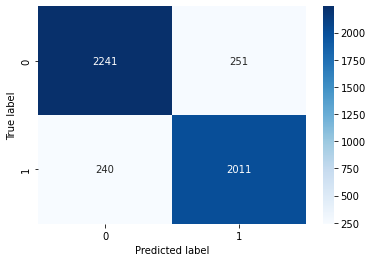

In [ ]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_test_gender,pred_gender)

import seaborn as sns
ax = sns.heatmap(conf,annot=True,fmt='d',cmap=plt.cm.Blues)
ax.set(xlabel="Predicted label",ylabel="True label")

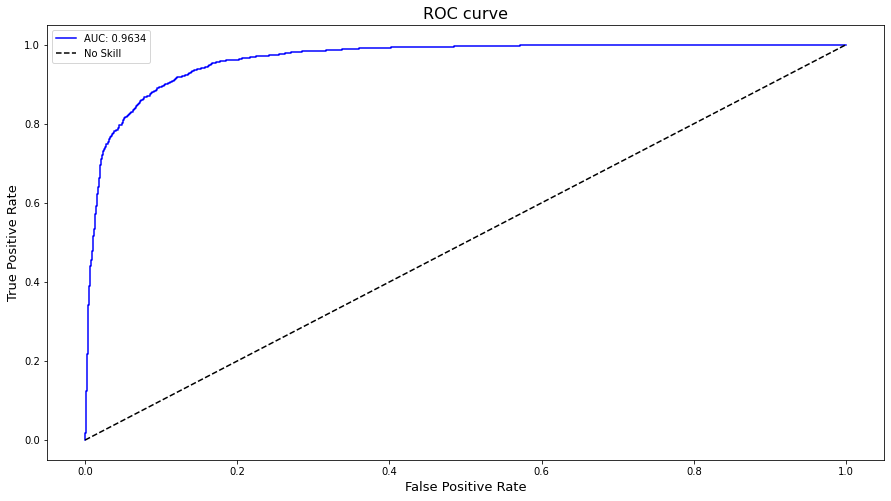

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

pred_gender_prob = pred[1] #this is the array of probabilities

plt.figure(figsize=(15,8))
plt.title('ROC curve', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)

tpr, fpr,_ = roc_curve(y_test_gender,pred_gender_prob)
plt.plot(tpr,fpr,c='b',label='AUC: {:.4f}'.format(roc_auc_score(y_test_gender, pred_gender_prob)))

plt.plot([0, 1], [0, 1], 'k--', label='No Skill')

plt.legend()

**Evaluating Race:**

In order to evaluate our model on race we need multiclass classification measures. (https://arxiv.org/pdf/2008.05756.pdf: *we can refer to this at documentation*)

- **F1-Score Multi-class case**: When it comes to multi-class cases, F1-Score should involve all the classes. To do so, we require a multi-class measure of Precision and Recall to be inserted into the harmonic mean. Such metrics may have two different specifications, giving rise to two different metrics: Micro F1-Score and Macro F1-Score 

- **Macro F1-Score**: In order to obtain Macro F1-Score, we need to compute Macro-Precision and Macro-Recall before. They are respectively
calculated by taking the average precision for each predicted class and the average recall for each actual class. Hence,
the Macro approach considers all the classes as basic elements of the calculation: each class has the same weight in the
average, so that there is no distinction between highly and poorly populated classes.

- **Micro F1-Score**: In order to obtain Micro F1-Score, we need to compute Micro-Precision and Micro-Recall before. The idea of Micro-averaging is to consider all the units together, without taking into consideration possible differences between classes. Micro-Average F1-Score is just equal to Accuracy. 

Accuracy: 0.7927472064094455
Macro F1-score (multiclass) 0.6774586317146861


[Text(33.0, 0.5, 'True label'), Text(0.5, 15.0, 'Predicted label')]

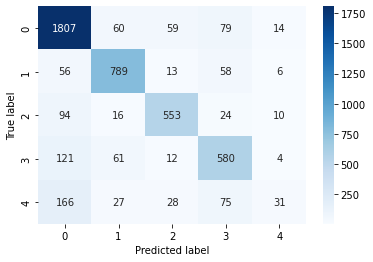

In [ ]:
#y_test_race, pred_race
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix

#since pred_race is a (4743,5) shaped numpy array we need to redefine it into 4743 list where each element has the index of the 5 lenght array where it is one.

pred_race = [int(np.where(pred_race[i] == 1)[0]) for i in range(len(pred_race))]

print('Accuracy: ' + str(metrics.accuracy_score(y_test_race, pred_race)))
print('Macro F1-score (multiclass) ' +  str(metrics.f1_score(y_test_race, pred_race,average='macro')))

conf = confusion_matrix(y_test_race,pred_race)

ax = sns.heatmap(conf,annot=True,fmt='d',cmap=plt.cm.Blues)
ax.set(xlabel="Predicted label",ylabel="True label")



# Transfer learning (ImageNet)

Now we try transfer learning. We are going to use the weights of the ImageNet model, but we set "include_top=False" so that the model does not include the ImageNet classification layer on top. Instead, we are going to add a few layers in order to use the model for our aim (age, gender, race prediction).
<p>We also have to set the layers from the base model not to be trainable. We want to use the base model as it was already taught, and we only want to train the added top layers.

### Model (and Data Preparation)

In [ ]:
from tensorflow.keras.layers import Flatten, Dense, Dropout

In [ ]:
import tensorflow.keras as keras

base_model = keras.applications.xception.Xception(weights="imagenet",
                                                 include_top=False)

X = keras.layers.GlobalAveragePooling2D()(base_model.output)

dense_1 = Dense(256, activation='relu')(X)
dense_2 = Dense(128, activation='relu')(dense_1)
dense_3 = Dense(256, activation='relu')(X)
dense_4 = Dense(256, activation='relu')(X)

dropout_1 = Dropout(0.4)(dense_2)
dropout_2 = Dropout(0.4)(dense_3)
dropout_3 = Dropout(0.4)(dense_4)

output_1 = Dense(1,activation='relu', name='age_output')(dropout_1)
output_2 = Dense(1, activation='sigmoid', name='gender_output')(dropout_2)
output_3 = Dense(5, activation='softmax', name='race_output')(dropout_3)

model = keras.models.Model(inputs=base_model.input, outputs=[output_1,output_2,output_3])

import tensorflow as tf

for layer in base_model.layers: # freeze the weights of the base model
    layer.trainable = False

83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                           

In [ ]:
model.compile(loss=['mse','binary_crossentropy','categorical_crossentropy'], optimizer='adam',loss_weights = [0.001,0.5,0.5],
              metrics = {'age_output': 'mean_squared_error', 'gender_output': 'accuracy', 'race_output': 'accuracy'})

In [ ]:
path_current = '/content/drive/MyDrive/Artificial_Incoherence_float_data'

os.chdir(path_current)

os.listdir()

['inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'X_test2.pkl',
 'X_train_part1.pkl',
 'X_train_part2.pkl',
 'X_train_part3.pkl',
 'X_train_part4.pkl',
 'y_test.pkl',
 'y_train.pkl',
 'model1_part1.h5',
 'model1_part2.h5',
 'model1_part3.h5',
 'model1_part4.h5',
 'model_imagenet_part1.h5']

Loading y_train and separating it into 4 parts (same way as we did with the X_train).

In [ ]:
# loading y_train data 
with open("./y_train.pkl","rb") as f:
    y_train = pickle.load(file=f)

In [ ]:
y_train_part1 = y_train[:5000]
y_train_part2 = y_train[5000:10000]
y_train_part3 = y_train[10000:15000]
y_train_part4 = y_train[15000:]

Now we have the training data in 4 parts (X_train_part1-2-3-4 and y_train_part1-2-3-4).

Let's take the y_train with all the 3 target variables apart, so that we have each target variable separated.

In [ ]:
y_train_1_age = y_train_part1.age
y_train_1_gender = y_train_part1.gender
y_train_1_race = y_train_part1.race

y_train_2_age = y_train_part2.age
y_train_2_gender = y_train_part2.gender
y_train_2_race = y_train_part2.race

y_train_3_age = y_train_part3.age
y_train_3_gender = y_train_part3.gender
y_train_3_race = y_train_part3.race

y_train_4_age = y_train_part4.age
y_train_4_gender = y_train_part4.gender
y_train_4_race = y_train_part4.race

In [ ]:
y_train_1_race = to_categorical(y_train_1_race,5)

y_train_2_race = to_categorical(y_train_2_race,5)

y_train_3_race = to_categorical(y_train_3_race,5)

y_train_4_race = to_categorical(y_train_4_race,5)

### Training on X_train_part1

In [ ]:
# loading X_train_part1 data 
with open("./X_train_part1.pkl","rb") as f:
    X_train_part1 = pickle.load(file=f)

In [ ]:
X_train_part1 = X_train_part1.reshape(-1,200,200,3)

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('model_imagenet_part1.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)  

In [ ]:
history = model.fit(x=X_train_part1,
                    y=[y_train_1_age, y_train_1_gender, y_train_1_race],
                    batch_size = 32,
                    epochs=50,
                    validation_split= 0.1,
                    callbacks = [es, save_best, plateau])

Epoch 1/50
141/141 [==============================] - 35s 165ms/step - loss: 1.1106 - age_output_loss: 288.0592 - gender_output_loss: 0.3920 - race_output_loss: 1.2531 - age_output_mean_squared_error: 288.0592 - gender_output_accuracy: 0.8247 - race_output_accuracy: 0.5240 - val_loss: 0.8743 - val_age_output_loss: 164.9372 - val_gender_output_loss: 0.3789 - val_race_output_loss: 1.0398 - val_age_output_mean_squared_error: 164.9372 - val_gender_output_accuracy: 0.8340 - val_race_output_accuracy: 0.6100 - lr: 0.0010
Epoch 2/50
141/141 [==============================] - 21s 151ms/step - loss: 0.8780 - age_output_loss: 169.2361 - gender_output_loss: 0.3370 - race_output_loss: 1.0806 - age_output_mean_squared_error: 169.2361 - gender_output_accuracy: 0.8500 - race_output_accuracy: 0.5927 - val_loss: 0.8068 - val_age_output_loss: 142.7293 - val_gender_output_loss: 0.3380 - val_race_output_loss: 0.9902 - val_age_output_mean_squared_error: 142.7293 - val_gender_output_accuracy: 0.8500 - val_ra

In [ ]:
del X_train_part1

### Training on X_train_part2

In [ ]:
from keras.models import load_model

model = load_model('model_imagenet_part1.h5')

In [ ]:
# loading X_train_part2 data 
with open("./X_train_part2.pkl","rb") as f:
    X_train_part2 = pickle.load(file=f)

In [ ]:
X_train_part2 = X_train_part2.reshape(-1,200,200,3)

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('model_imagenet_part2.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)  

In [ ]:
history = model.fit(x=X_train_part2,
                    y=[y_train_2_age, y_train_2_gender, y_train_2_race],
                    batch_size = 32,
                    epochs=50,
                    validation_split= 0.1,
                    callbacks = [es, save_best, plateau])

Epoch 1/50
141/141 [==============================] - 24s 157ms/step - loss: 0.8358 - age_output_loss: 158.1509 - gender_output_loss: 0.3507 - race_output_loss: 1.0047 - age_output_mean_squared_error: 158.1509 - gender_output_accuracy: 0.8584 - race_output_accuracy: 0.6273 - val_loss: 0.7342 - val_age_output_loss: 123.3135 - val_gender_output_loss: 0.2819 - val_race_output_loss: 0.9399 - val_age_output_mean_squared_error: 123.3135 - val_gender_output_accuracy: 0.8780 - val_race_output_accuracy: 0.6540 - lr: 3.0000e-04
Epoch 2/50
141/141 [==============================] - 21s 150ms/step - loss: 0.7746 - age_output_loss: 146.8860 - gender_output_loss: 0.3096 - race_output_loss: 0.9459 - age_output_mean_squared_error: 146.8860 - gender_output_accuracy: 0.8667 - race_output_accuracy: 0.6496 - val_loss: 0.7228 - val_age_output_loss: 119.3844 - val_gender_output_loss: 0.2859 - val_race_output_loss: 0.9209 - val_age_output_mean_squared_error: 119.3844 - val_gender_output_accuracy: 0.8820 - va

In [ ]:
del X_train_part2

###  Training on X_train_part3

In [ ]:
from keras.models import load_model

model = load_model('model_imagenet_part2.h5')

In [ ]:
# loading X_train_part3 data 
with open("./X_train_part3.pkl","rb") as f:
    X_train_part3 = pickle.load(file=f)

In [ ]:
X_train_part3 = X_train_part3.reshape(-1,200,200,3)

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('model_imagenet_part3.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)  

In [ ]:
history = model.fit(x=X_train_part3,
                    y=[y_train_3_age, y_train_3_gender, y_train_3_race],
                    batch_size = 32,
                    epochs=50,
                    validation_split= 0.1,
                    callbacks = [es, save_best, plateau])

Epoch 1/50
141/141 [==============================] - 23s 153ms/step - loss: 0.7728 - age_output_loss: 135.3861 - gender_output_loss: 0.3111 - race_output_loss: 0.9638 - age_output_mean_squared_error: 135.3861 - gender_output_accuracy: 0.8644 - race_output_accuracy: 0.6524 - val_loss: 0.7526 - val_age_output_loss: 125.5979 - val_gender_output_loss: 0.3196 - val_race_output_loss: 0.9344 - val_age_output_mean_squared_error: 125.5979 - val_gender_output_accuracy: 0.8420 - val_race_output_accuracy: 0.6680 - lr: 2.7000e-05
Epoch 2/50
141/141 [==============================] - 21s 147ms/step - loss: 0.7638 - age_output_loss: 136.3513 - gender_output_loss: 0.3044 - race_output_loss: 0.9505 - age_output_mean_squared_error: 136.3513 - gender_output_accuracy: 0.8722 - race_output_accuracy: 0.6547 - val_loss: 0.7504 - val_age_output_loss: 126.0432 - val_gender_output_loss: 0.3191 - val_race_output_loss: 0.9296 - val_age_output_mean_squared_error: 126.0432 - val_gender_output_accuracy: 0.8420 - va

In [ ]:
del X_train_part3

###  Training on X_train_part4

In [ ]:
from keras.models import load_model

model = load_model('model_imagenet_part3.h5')

In [ ]:
# loading X_train_part4 data 
with open("./X_train_part4.pkl","rb") as f:
    X_train_part4 = pickle.load(file=f)

In [ ]:
X_train_part4 = X_train_part4.reshape(-1,200,200,3)

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('model_imagenet_part4.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set) 

In [ ]:
history = model.fit(x=X_train_part4,
                    y=[y_train_4_age, y_train_4_gender, y_train_4_race],
                    batch_size = 32,
                    epochs=50,
                    validation_split= 0.1,
                    callbacks = [es, save_best, plateau])

Epoch 1/50
112/112 [==============================] - 22s 171ms/step - loss: 0.7531 - age_output_loss: 133.0218 - gender_output_loss: 0.3072 - race_output_loss: 0.9329 - age_output_mean_squared_error: 133.0218 - gender_output_accuracy: 0.8649 - race_output_accuracy: 0.6572 - val_loss: 0.6842 - val_age_output_loss: 111.3273 - val_gender_output_loss: 0.3229 - val_race_output_loss: 0.8228 - val_age_output_mean_squared_error: 111.3273 - val_gender_output_accuracy: 0.8593 - val_race_output_accuracy: 0.7085 - lr: 7.2900e-07
Epoch 2/50
112/112 [==============================] - 17s 150ms/step - loss: 0.7533 - age_output_loss: 133.2601 - gender_output_loss: 0.3053 - race_output_loss: 0.9348 - age_output_mean_squared_error: 133.2601 - gender_output_accuracy: 0.8651 - race_output_accuracy: 0.6603 - val_loss: 0.6841 - val_age_output_loss: 111.3179 - val_gender_output_loss: 0.3229 - val_race_output_loss: 0.8227 - val_age_output_mean_squared_error: 111.3179 - val_gender_output_accuracy: 0.8593 - va

In [ ]:
del X_train_part4

# Evaluating the ImageNet model (saved as model_imagenet_part4.h5)

### Preparation

In [ ]:
path_current = '/content/drive/MyDrive/Artificial_Incoherence_float_data'

os.chdir(path_current)

os.listdir()

['inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'X_test2.pkl',
 'X_train_part1.pkl',
 'X_train_part2.pkl',
 'X_train_part3.pkl',
 'X_train_part4.pkl',
 'y_test.pkl',
 'y_train.pkl',
 'model1_part1.h5',
 'model1_part2.h5',
 'model1_part3.h5',
 'model1_part4.h5',
 'model_imagenet_part1.h5',
 'model_imagenet_part2.h5',
 'model_imagenet_part3.h5',
 'model_imagenet_part4.h5']

In [ ]:
from keras.models import load_model

model = load_model('model_imagenet_part4.h5')

# loading X_test data 
with open("./X_test2.pkl","rb") as f:
    X_test = pickle.load(file=f)

X_test = X_test.reshape(-1,200,200,3)

pred = model.predict(X_test)

149/149 [==============================] - 19s 120ms/step


pred is a list of 3 elements: the first element is the prediction of the age attribute (so it is a len(X_test) long array). We have to round these values. The second element is an array: the prediction of the gender (len(X_test) values from the [0,1] interval). Here we have to round it to get 0 or 1 values, which symbolize the two genders. The third element is the prediction array of the race attribute. The elements of this array are arrays as well with 5 values: these 5 values give the probability of being in the five races, so they add up to 1. We have to turn the maximum of the 5 values to 1, and all the rest to 0, because each person can be in only one race.

Just a reminder:

Gender: 0 is male, 1 is female

Race: 1 is White, 2 is Black, 3 is Asian, 4 is Indian and 5 is Other

In [ ]:
pred_age = pred[0].round()

pred_gender = pred[1]
pred_gender = pred_gender.round()

pred_race = pred[2]
pred_race = (pred_race == pred_race.max(axis=1, keepdims=1)).astype(float) #this turns the max value to 1 and the rest to 0

# loading y_test data 
with open("./y_test.pkl","rb") as f:
    y_test = pickle.load(file=f)

y_test_age = y_test.age
y_test_gender = y_test.gender
y_test_race = y_test.race

### Evaluating Age:

In [ ]:
from sklearn.metrics import mean_squared_error
import math

print("Evaluation of age attribute:")
print("MSE: " + str(mean_squared_error(y_test_age, pred_age)))
print("RMSE: " + str(math.sqrt(mean_squared_error(y_test_age, pred_age))))

Evaluation of age attribute:
MSE: 117.09002740881299
RMSE: 10.820814544608599


### Evaluating Gender:

Accuracy: 0.874974
Precision: 0.8795787545787546
Recall: 0.8533984895601955
f1_score: 0.8662908680947013


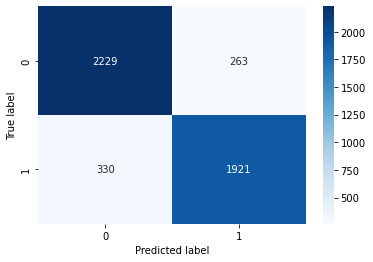

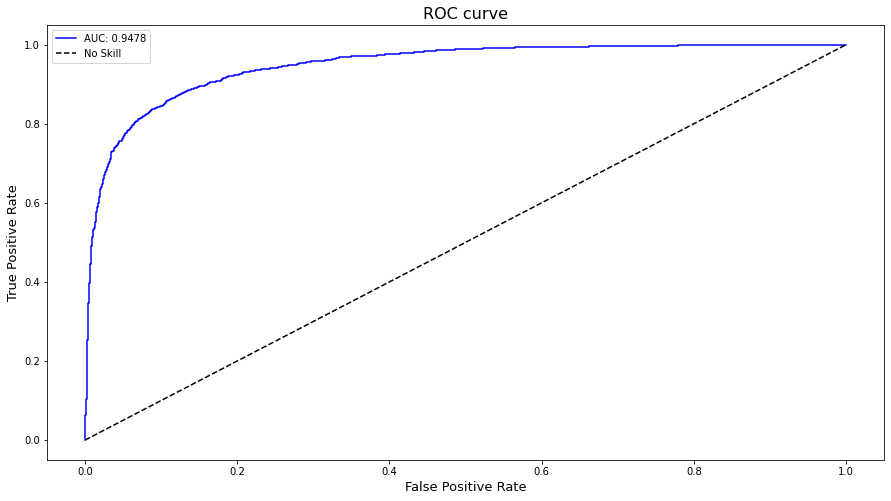

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix,classification_report

print("Accuracy: %g" %(accuracy_score(y_test_gender, pred_gender)))
print("Precision:", precision_score(y_test_gender, pred_gender))
print("Recall:", recall_score(y_test_gender, pred_gender))
print("f1_score:", f1_score(y_test_gender, pred_gender))

from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_test_gender,pred_gender)

import seaborn as sns
ax = sns.heatmap(conf,annot=True,fmt='d',cmap=plt.cm.Blues)
ax.set(xlabel="Predicted label",ylabel="True label")

from sklearn.metrics import roc_curve, roc_auc_score

pred_gender_prob = pred[1] #this is the array of probabilities

plt.figure(figsize=(15,8))
plt.title('ROC curve', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)

tpr, fpr,_ = roc_curve(y_test_gender,pred_gender_prob)
plt.plot(tpr,fpr,c='b',label='AUC: {:.4f}'.format(roc_auc_score(y_test_gender, pred_gender_prob)))

plt.plot([0, 1], [0, 1], 'k--', label='No Skill')

plt.legend()

### Evaluating Race:

Accuracy: 0.6816360952983344
Macro F1-score (multiclass) 0.573694988887654


[Text(33.0, 0.5, 'True label'), Text(0.5, 15.0, 'Predicted label')]

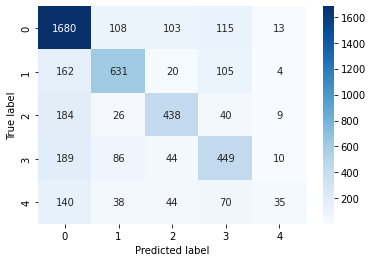

In [ ]:
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix

#since pred_race is a (4743,5) shaped numpy array we need to redefine it into 4743 list where each element has the index of the 5 lenght array where it is one.

pred_race = [int(np.where(pred_race[i] == 1)[0]) for i in range(len(pred_race))]

print('Accuracy: ' + str(metrics.accuracy_score(y_test_race, pred_race)))
print('Macro F1-score (multiclass) ' +  str(metrics.f1_score(y_test_race, pred_race,average='macro')))

conf = confusion_matrix(y_test_race,pred_race)

ax = sns.heatmap(conf,annot=True,fmt='d',cmap=plt.cm.Blues)
ax.set(xlabel="Predicted label",ylabel="True label")


# Transfer learning (InceptionV3)

In [ ]:
path_current = '/content/drive/MyDrive/Artificial_Incoherence_float_data'

os.chdir(path_current)

os.listdir()

['inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'X_test2.pkl',
 'X_train_part1.pkl',
 'X_train_part2.pkl',
 'X_train_part3.pkl',
 'X_train_part4.pkl',
 'y_test.pkl',
 'y_train.pkl',
 'model1_part1.h5',
 'model1_part2.h5',
 'model1_part3.h5',
 'model1_part4.h5',
 'model_imagenet_part1.h5',
 'model_imagenet_part2.h5',
 'model_imagenet_part3.h5',
 'model_imagenet_part4.h5',
 'model_inceptionv3_part1.h5',
 'model_inceptionv3_part2.h5',
 'model_inceptionv3_part3.h5']

In [ ]:
# Import InceptionV3 Model

from keras.applications.inception_v3 import InceptionV3

inc_model = InceptionV3(weights='./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False,
                        input_shape=(200, 200, 3))

print("number of layers:", len(inc_model.layers))

number of layers: 311


The top layers (including classification) are not included. These layers will be replaced for the following layers:

In [ ]:
import tensorflow.keras as keras

X = keras.layers.GlobalAveragePooling2D()(inc_model.output)

dense_1 = Dense(256, activation='relu')(X)
dense_2 = Dense(128, activation='relu')(dense_1)
dense_3 = Dense(256, activation='relu')(X)
dense_4 = Dense(256, activation='relu')(X)

dropout_1 = Dropout(0.4)(dense_2)
dropout_2 = Dropout(0.4)(dense_3)
dropout_3 = Dropout(0.4)(dense_4)

output_1 = Dense(1,activation='relu', name='age_output')(dropout_1)
output_2 = Dense(1, activation='sigmoid', name='gender_output')(dropout_2)
output_3 = Dense(5, activation='softmax', name='race_output')(dropout_3)

In [ ]:
model = Model(inputs=inc_model.input, outputs=[output_1,output_2,output_3])

# Lock initial layers to do not be trained
for layer in model.layers[:52]:
    layer.trainable = False

In [ ]:
model.compile(loss=['mse','binary_crossentropy','categorical_crossentropy'], optimizer='adam',loss_weights = [0.001,0.5,0.5],
              metrics = {'age_output': 'mean_squared_error', 'gender_output': 'accuracy', 'race_output': 'accuracy'})

Loading y_train and separating it into 4 parts (same way as we did with the X_train).

In [ ]:
# loading y_train data 
with open("./y_train.pkl","rb") as f:
    y_train = pickle.load(file=f)

In [ ]:
y_train_part1 = y_train[:5000]
y_train_part2 = y_train[5000:10000]
y_train_part3 = y_train[10000:15000]
y_train_part4 = y_train[15000:]

Now we have the training data in 4 parts (X_train_part1-2-3-4 and y_train_part1-2-3-4).

Let's take the y_train with all the 3 target variables apart, so that we have each target variable separated.

In [ ]:
y_train_1_age = y_train_part1.age
y_train_1_gender = y_train_part1.gender
y_train_1_race = y_train_part1.race

y_train_2_age = y_train_part2.age
y_train_2_gender = y_train_part2.gender
y_train_2_race = y_train_part2.race

y_train_3_age = y_train_part3.age
y_train_3_gender = y_train_part3.gender
y_train_3_race = y_train_part3.race

y_train_4_age = y_train_part4.age
y_train_4_gender = y_train_part4.gender
y_train_4_race = y_train_part4.race

In [ ]:
y_train_1_race = to_categorical(y_train_1_race,5)

y_train_2_race = to_categorical(y_train_2_race,5)

y_train_3_race = to_categorical(y_train_3_race,5)

y_train_4_race = to_categorical(y_train_4_race,5)

### Training on X_train_part1

In [ ]:
# loading X_train_part1 data 
with open("./X_train_part1.pkl","rb") as f:
    X_train_part1 = pickle.load(file=f)

In [ ]:
X_train_part1 = X_train_part1.reshape(-1,200,200,3)

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('model_inceptionv3_part1.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)  

In [ ]:
history = model.fit(x=X_train_part1,
                    y=[y_train_1_age, y_train_1_gender, y_train_1_race],
                    batch_size = 32,
                    epochs=50,
                    validation_split= 0.1,
                    callbacks = [es, save_best, plateau])

Epoch 1/50
141/141 [==============================] - 46s 200ms/step - loss: 1.0093 - age_output_loss: 243.6216 - gender_output_loss: 0.4296 - race_output_loss: 1.1017 - age_output_mean_squared_error: 243.6216 - gender_output_accuracy: 0.7987 - race_output_accuracy: 0.5962 - val_loss: 2.5995 - val_age_output_loss: 755.4402 - val_gender_output_loss: 0.5053 - val_race_output_loss: 3.1828 - val_age_output_mean_squared_error: 755.4402 - val_gender_output_accuracy: 0.7780 - val_race_output_accuracy: 0.3340 - lr: 0.0010
Epoch 2/50
141/141 [==============================] - 26s 184ms/step - loss: 0.6877 - age_output_loss: 148.7444 - gender_output_loss: 0.2855 - race_output_loss: 0.7924 - age_output_mean_squared_error: 148.7444 - gender_output_accuracy: 0.8776 - race_output_accuracy: 0.7322 - val_loss: 1.6654 - val_age_output_loss: 139.4424 - val_gender_output_loss: 0.8193 - val_race_output_loss: 2.2327 - val_age_output_mean_squared_error: 139.4424 - val_gender_output_accuracy: 0.7240 - val_ra

In [ ]:
del X_train_part1

### Training on X_train_part2

In [ ]:
from keras.models import load_model

model = load_model('model_inceptionv3_part1.h5')

In [ ]:
# loading X_train_part2 data 
with open("./X_train_part2.pkl","rb") as f:
    X_train_part2 = pickle.load(file=f)

In [ ]:
X_train_part2 = X_train_part2.reshape(-1,200,200,3)

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('model_inceptionv3_part2.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)  

In [ ]:
history = model.fit(x=X_train_part2,
                    y=[y_train_2_age, y_train_2_gender, y_train_2_race],
                    batch_size = 32,
                    epochs=50,
                    validation_split= 0.1,
                    callbacks = [es, save_best, plateau])

Epoch 1/50
141/141 [==============================] - 50s 241ms/step - loss: 0.5309 - age_output_loss: 101.9808 - gender_output_loss: 0.2398 - race_output_loss: 0.6181 - age_output_mean_squared_error: 101.9808 - gender_output_accuracy: 0.9064 - race_output_accuracy: 0.8004 - val_loss: 0.5462 - val_age_output_loss: 146.4353 - val_gender_output_loss: 0.2061 - val_race_output_loss: 0.5935 - val_age_output_mean_squared_error: 146.4353 - val_gender_output_accuracy: 0.9060 - val_race_output_accuracy: 0.8100 - lr: 3.0000e-04
Epoch 2/50
141/141 [==============================] - 26s 185ms/step - loss: 0.3594 - age_output_loss: 87.2991 - gender_output_loss: 0.1354 - race_output_loss: 0.4088 - age_output_mean_squared_error: 87.2991 - gender_output_accuracy: 0.9493 - race_output_accuracy: 0.8644 - val_loss: 0.4999 - val_age_output_loss: 72.9586 - val_gender_output_loss: 0.2571 - val_race_output_loss: 0.5967 - val_age_output_mean_squared_error: 72.9586 - val_gender_output_accuracy: 0.8980 - val_ra

In [ ]:
del X_train_part2

### Training on X_train_part3

In [ ]:
from keras.models import load_model

model = load_model('model_inceptionv3_part2.h5')

In [ ]:
# loading X_train_part3 data 
with open("./X_train_part3.pkl","rb") as f:
    X_train_part3 = pickle.load(file=f)

In [ ]:
X_train_part3 = X_train_part3.reshape(-1,200,200,3)

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('model_inceptionv3_part3.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)  

In [ ]:
history = model.fit(x=X_train_part3,
                    y=[y_train_3_age, y_train_3_gender, y_train_3_race],
                    batch_size = 32,
                    epochs=50,
                    validation_split= 0.1,
                    callbacks = [es, save_best, plateau])

Epoch 1/50
141/141 [==============================] - 48s 243ms/step - loss: 0.5022 - age_output_loss: 102.1806 - gender_output_loss: 0.2163 - race_output_loss: 0.5838 - age_output_mean_squared_error: 102.1806 - gender_output_accuracy: 0.9102 - race_output_accuracy: 0.8080 - val_loss: 0.4980 - val_age_output_loss: 74.8269 - val_gender_output_loss: 0.2335 - val_race_output_loss: 0.6129 - val_age_output_mean_squared_error: 74.8269 - val_gender_output_accuracy: 0.8900 - val_race_output_accuracy: 0.7900 - lr: 3.0000e-04
Epoch 2/50
141/141 [==============================] - 26s 186ms/step - loss: 0.3448 - age_output_loss: 85.0210 - gender_output_loss: 0.1384 - race_output_loss: 0.3812 - age_output_mean_squared_error: 85.0210 - gender_output_accuracy: 0.9462 - race_output_accuracy: 0.8711 - val_loss: 0.4732 - val_age_output_loss: 60.9975 - val_gender_output_loss: 0.2207 - val_race_output_loss: 0.6037 - val_age_output_mean_squared_error: 60.9975 - val_gender_output_accuracy: 0.9100 - val_race

In [ ]:
del X_train_part3

### Training on X_train_part4

In [ ]:
from keras.models import load_model

model = load_model('model_inceptionv3_part3.h5')

In [ ]:
# loading X_train_part4 data 
with open("./X_train_part4.pkl","rb") as f:
    X_train_part4 = pickle.load(file=f)

In [ ]:
X_train_part4 = X_train_part4.reshape(-1,200,200,3)

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('model_inceptionv3_part4.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set) 

In [ ]:
history = model.fit(x=X_train_part4,
                    y=[y_train_4_age, y_train_4_gender, y_train_4_race],
                    batch_size = 32,
                    epochs=50,
                    validation_split= 0.1,
                    callbacks = [es, save_best, plateau])

Epoch 1/50
112/112 [==============================] - 29s 219ms/step - loss: 0.4708 - age_output_loss: 93.9219 - gender_output_loss: 0.2019 - race_output_loss: 0.5518 - age_output_mean_squared_error: 93.9219 - gender_output_accuracy: 0.9138 - race_output_accuracy: 0.8232 - val_loss: 0.4051 - val_age_output_loss: 72.9504 - val_gender_output_loss: 0.2003 - val_race_output_loss: 0.4640 - val_age_output_mean_squared_error: 72.9504 - val_gender_output_accuracy: 0.9296 - val_race_output_accuracy: 0.8342 - lr: 3.0000e-04
Epoch 2/50
112/112 [==============================] - 18s 161ms/step - loss: 0.3173 - age_output_loss: 80.8339 - gender_output_loss: 0.1217 - race_output_loss: 0.3512 - age_output_mean_squared_error: 80.8339 - gender_output_accuracy: 0.9527 - race_output_accuracy: 0.8847 - val_loss: 0.4312 - val_age_output_loss: 78.8066 - val_gender_output_loss: 0.1878 - val_race_output_loss: 0.5170 - val_age_output_mean_squared_error: 78.8066 - val_gender_output_accuracy: 0.9296 - val_race_o

In [ ]:
del X_train_part4

# Evaluating the InceptionV3 model (saved as model_inceptionv3_part4.h5)

### Preparation

In [ ]:
path_current = '/content/drive/MyDrive/Artificial_Incoherence_float_data'

os.chdir(path_current)

os.listdir()

['inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'X_test2.pkl',
 'X_train_part1.pkl',
 'X_train_part2.pkl',
 'X_train_part3.pkl',
 'X_train_part4.pkl',
 'y_test.pkl',
 'y_train.pkl',
 'model1_part1.h5',
 'model1_part2.h5',
 'model1_part3.h5',
 'model1_part4.h5',
 'model_imagenet_part1.h5',
 'model_imagenet_part2.h5',
 'model_imagenet_part3.h5',
 'model_imagenet_part4.h5',
 'model_inceptionv3_part1.h5',
 'model_inceptionv3_part2.h5',
 'model_inceptionv3_part3.h5',
 'model_inceptionv3_part4.h5']

In [ ]:
from keras.models import load_model

model = load_model('model_inceptionv3_part4.h5')

# loading X_test data 
with open("./X_test2.pkl","rb") as f:
    X_test = pickle.load(file=f)

X_test = X_test.reshape(-1,200,200,3)

pred = model.predict(X_test)

149/149 [==============================] - 11s 62ms/step


pred is a list of 3 elements: the first element is the prediction of the age attribute (so it is a len(X_test) long array). We have to round these values. The second element is an array: the prediction of the gender (len(X_test) values from the [0,1] interval). Here we have to round it to get 0 or 1 values, which symbolize the two genders. The third element is the prediction array of the race attribute. The elements of this array are arrays as well with 5 values: these 5 values give the probability of being in the five races, so they add up to 1. We have to turn the maximum of the 5 values to 1, and all the rest to 0, because each person can be in only one race.

Just a reminder:

Gender: 0 is male, 1 is female

Race: 1 is White, 2 is Black, 3 is Asian, 4 is Indian and 5 is Other

In [ ]:
pred_age = pred[0].round()

pred_gender = pred[1]
pred_gender = pred_gender.round()

pred_race = pred[2]
pred_race = (pred_race == pred_race.max(axis=1, keepdims=1)).astype(float) #this turns the max value to 1 and the rest to 0

# loading y_test data 
with open("./y_test.pkl","rb") as f:
    y_test = pickle.load(file=f)

y_test_age = y_test.age
y_test_gender = y_test.gender
y_test_race = y_test.race

### Evaluating Age:

In [ ]:
from sklearn.metrics import mean_squared_error
import math

print("Evaluation of age attribute:")
print("MSE: " + str(mean_squared_error(y_test_age, pred_age)))
print("RMSE: " + str(math.sqrt(mean_squared_error(y_test_age, pred_age))))

Evaluation of age attribute:
MSE: 75.73265865485979
RMSE: 8.702451301493149


### Evaluating Gender:

Accuracy: 0.923888
Precision: 0.9272151898734177
Recall: 0.9111505997334518
f1_score: 0.9191127044588842


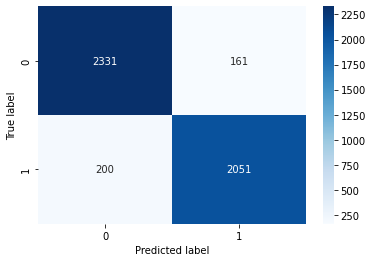

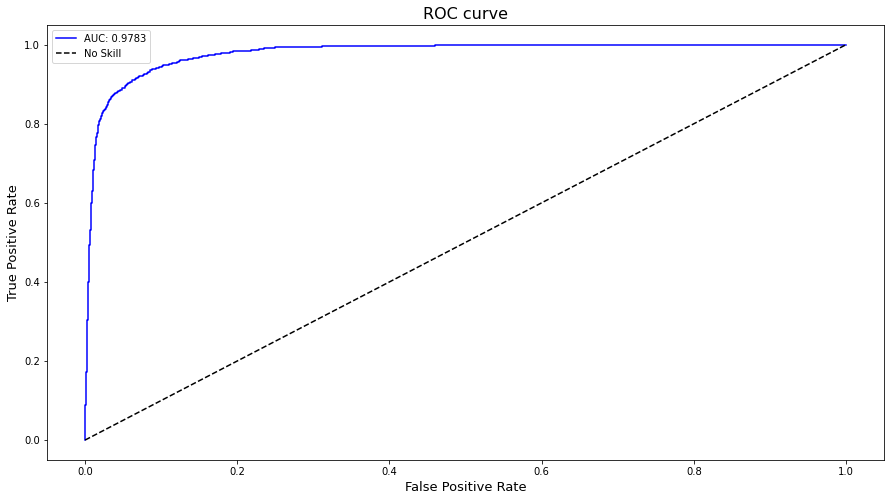

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix,classification_report

print("Accuracy: %g" %(accuracy_score(y_test_gender, pred_gender)))
print("Precision:", precision_score(y_test_gender, pred_gender))
print("Recall:", recall_score(y_test_gender, pred_gender))
print("f1_score:", f1_score(y_test_gender, pred_gender))

from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_test_gender,pred_gender)

import seaborn as sns
ax = sns.heatmap(conf,annot=True,fmt='d',cmap=plt.cm.Blues)
ax.set(xlabel="Predicted label",ylabel="True label")

from sklearn.metrics import roc_curve, roc_auc_score

pred_gender_prob = pred[1] #this is the array of probabilities

plt.figure(figsize=(15,8))
plt.title('ROC curve', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)

tpr, fpr,_ = roc_curve(y_test_gender,pred_gender_prob)
plt.plot(tpr,fpr,c='b',label='AUC: {:.4f}'.format(roc_auc_score(y_test_gender, pred_gender_prob)))

plt.plot([0, 1], [0, 1], 'k--', label='No Skill')

plt.legend()

### Evaluating Race:

Accuracy: 0.8306978705460679
Macro F1-score (multiclass) 0.7110117482910127


[Text(33.0, 0.5, 'True label'), Text(0.5, 15.0, 'Predicted label')]

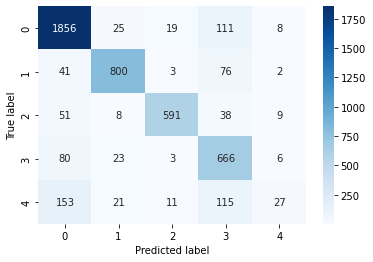

In [ ]:
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix

#since pred_race is a (4743,5) shaped numpy array we need to redefine it into 4743 list where each element has the index of the 5 lenght array where it is one.

pred_race = [int(np.where(pred_race[i] == 1)[0]) for i in range(len(pred_race))]

print('Accuracy: ' + str(metrics.accuracy_score(y_test_race, pred_race)))
print('Macro F1-score (multiclass) ' +  str(metrics.f1_score(y_test_race, pred_race,average='macro')))

conf = confusion_matrix(y_test_race,pred_race)

ax = sns.heatmap(conf,annot=True,fmt='d',cmap=plt.cm.Blues)
ax.set(xlabel="Predicted label",ylabel="True label")

# Weighted Solution for Race attribute

We should mention that we have unbalanced data in the race target variable, so we should only model on this one. We have no other option, since `class_weight` is only supported for Models with a single output, so we need to make a lot of modification here.  

### Preparation and model

We should load the data.

In [ ]:
path_current = '/content/drive/MyDrive/Artificial_Incoherence_float_data'

os.chdir(path_current)

# loading y_train data 
with open("./y_train.pkl","rb") as f:
    y_train = pickle.load(file=f)
    
y_train_part1 = y_train[:5000]
y_train_part2 = y_train[5000:10000]
y_train_part3 = y_train[10000:15000]
y_train_part4 = y_train[15000:]

y_train_1_age = y_train_part1.age
y_train_1_gender = y_train_part1.gender
y_train_1_race = y_train_part1.race

y_train_2_age = y_train_part2.age
y_train_2_gender = y_train_part2.gender
y_train_2_race = y_train_part2.race

y_train_3_age = y_train_part3.age
y_train_3_gender = y_train_part3.gender
y_train_3_race = y_train_part3.race

y_train_4_age = y_train_part4.age
y_train_4_gender = y_train_part4.gender
y_train_4_race = y_train_part4.race

In order to make the weighted solution work we need to convert our numpy array into one dimensional numpy array first.

In [ ]:
y_train_1_race = np.array(y_train_1_race)

We should continue with our model.

In [ ]:
import tensorflow.keras as keras

from keras.applications.inception_v3 import InceptionV3

inc_model = InceptionV3(weights='./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False,
                        input_shape=(200, 200, 3))

X = keras.layers.GlobalAveragePooling2D()(inc_model.output)

#dense_1 = Dense(256, activation='relu')(X)
#dense_2 = Dense(128, activation='relu')(dense_1)
#dense_3 = Dense(256, activation='relu')(X)
dense_4 = Dense(256, activation='relu')(X)

#dropout_1 = Dropout(0.4)(dense_2)
#dropout_2 = Dropout(0.4)(dense_3)
dropout_3 = Dropout(0.4)(dense_4)

#output_1 = Dense(1,activation='relu', name='age_output')(dropout_1)
#output_2 = Dense(1, activation='sigmoid', name='gender_output')(dropout_2)
output_3 = Dense(5, activation='softmax', name='race_output')(dropout_3)

model = keras.models.Model(inputs=inc_model.input, outputs=[output_3])

for layer in model.layers[:52]:
    layer.trainable = False
    
model.compile(loss=['categorical_crossentropy'], optimizer='adam', metrics = ['accuracy'])

### Learning on X_train_part1

In order to make the weighted solution work we need to convert our numpy array into one dimensional numpy array first. Let's load and convert. 

In [ ]:
from sklearn.utils import class_weight

# loading X_train_part1 data 
with open("./X_train_part1.pkl","rb") as f:
    X_train_part1 = pickle.load(file=f)
    
X_train_part1 = X_train_part1.reshape(-1,200,200,3)

weight = class_weight.compute_class_weight('balanced', classes = np.unique(y_train_1_race), y = y_train_1_race)
class_weight = {i:w for i,w in enumerate(weight)}

In [ ]:
y_train_1_race = to_categorical(y_train_1_race,5)

Now we should construct our model. We should name this as csabi_weighted_1.h5 because i want it to have a unique name. It is important that the .fit() function expects class_weights to be a dictionary that is what we do at the end.

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('csabi_weighted_1.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)

In [ ]:
history = model.fit(x=X_train_part1,y= y_train_1_race, batch_size = 32, epochs=50, class_weight = class_weight, validation_split= 0.1, callbacks = [es, save_best, plateau])

Epoch 1/50
141/141 [==============================] - 50s 231ms/step - loss: 1.3647 - accuracy: 0.4696 - val_loss: 2.3670 - val_accuracy: 0.5280 - lr: 0.0010
Epoch 2/50
141/141 [==============================] - 26s 184ms/step - loss: 1.0317 - accuracy: 0.6447 - val_loss: 2.1062 - val_accuracy: 0.4320 - lr: 0.0010
Epoch 3/50
141/141 [==============================] - 22s 154ms/step - loss: 0.9067 - accuracy: 0.6922 - val_loss: 2.6657 - val_accuracy: 0.4660 - lr: 0.0010
Epoch 4/50
141/141 [==============================] - 25s 180ms/step - loss: 0.7463 - accuracy: 0.7371 - val_loss: 0.9352 - val_accuracy: 0.6460 - lr: 0.0010
Epoch 5/50
141/141 [==============================] - 22s 154ms/step - loss: 0.6516 - accuracy: 0.7691 - val_loss: 1.6588 - val_accuracy: 0.5420 - lr: 0.0010
Epoch 6/50
141/141 [==============================] - ETA: 0s - loss: 0.5516 - accuracy: 0.8031
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
141/141 [=============================

In [ ]:
del X_train_part1

### Learning on X_train_part2

In [ ]:
from keras.models import load_model
from sklearn.utils import class_weight

model = load_model('csabi_weighted_1.h5')

# loading X_train_part2 data 
with open("./X_train_part2.pkl","rb") as f:
    X_train_part2 = pickle.load(file=f)

X_train_part2 = X_train_part2.reshape(-1,200,200,3)

weight2 = class_weight.compute_class_weight('balanced', classes = np.unique(y_train_2_race), y = y_train_2_race)
class_weight = {i:w for i,w in enumerate(weight2)}

In [ ]:
y_train_2_race = to_categorical(y_train_2_race,5)

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('csabi_weighted_2.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)

history = model.fit(x=X_train_part2,y= y_train_2_race, batch_size = 32, epochs=50, class_weight = class_weight, validation_split= 0.1, callbacks = [es, save_best, plateau])


Epoch 1/50
141/141 [==============================] - 34s 212ms/step - loss: 0.8282 - accuracy: 0.7349 - val_loss: 0.6870 - val_accuracy: 0.7640 - lr: 3.0000e-04
Epoch 2/50
141/141 [==============================] - 25s 180ms/step - loss: 0.5286 - accuracy: 0.8209 - val_loss: 0.6071 - val_accuracy: 0.7900 - lr: 3.0000e-04
Epoch 3/50
141/141 [==============================] - 22s 154ms/step - loss: 0.3405 - accuracy: 0.8849 - val_loss: 0.8566 - val_accuracy: 0.7240 - lr: 3.0000e-04
Epoch 4/50
141/141 [==============================] - ETA: 0s - loss: 0.2447 - accuracy: 0.9136
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
141/141 [==============================] - 22s 155ms/step - loss: 0.2447 - accuracy: 0.9136 - val_loss: 0.7277 - val_accuracy: 0.7860 - lr: 3.0000e-04
Epoch 5/50
141/141 [==============================] - 22s 156ms/step - loss: 0.1136 - accuracy: 0.9551 - val_loss: 0.6861 - val_accuracy: 0.7900 - lr: 9.0000e-05
Epoch 6/50
141/141 [=========

In [ ]:
del X_train_part2

### Learning on X_train_part3

In [ ]:
from keras.models import load_model
from sklearn.utils import class_weight

model = load_model('csabi_weighted_2.h5')

# loading X_train_part3 data 
with open("./X_train_part3.pkl","rb") as f:
    X_train_part3 = pickle.load(file=f)

X_train_part3 = X_train_part3.reshape(-1,200,200,3)

weight3 = class_weight.compute_class_weight('balanced', classes = np.unique(y_train_3_race), y = y_train_3_race)
class_weight = {i:w for i,w in enumerate(weight3)}

In [ ]:
y_train_3_race = to_categorical(y_train_3_race,5)

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('csabi_weighted_3.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)

history = model.fit(x=X_train_part3,y= y_train_3_race, batch_size = 32, epochs=50, class_weight = class_weight, validation_split= 0.1, callbacks = [es, save_best, plateau])

Epoch 1/50
141/141 [==============================] - 30s 183ms/step - loss: 0.7196 - accuracy: 0.7693 - val_loss: 0.7493 - val_accuracy: 0.7280 - lr: 3.0000e-04
Epoch 2/50
141/141 [==============================] - 26s 186ms/step - loss: 0.4782 - accuracy: 0.8418 - val_loss: 0.5859 - val_accuracy: 0.8200 - lr: 3.0000e-04
Epoch 3/50
141/141 [==============================] - 22s 154ms/step - loss: 0.3354 - accuracy: 0.8820 - val_loss: 0.9532 - val_accuracy: 0.6960 - lr: 3.0000e-04
Epoch 4/50
141/141 [==============================] - ETA: 0s - loss: 0.2320 - accuracy: 0.9136
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
141/141 [==============================] - 22s 157ms/step - loss: 0.2320 - accuracy: 0.9136 - val_loss: 0.7687 - val_accuracy: 0.7740 - lr: 3.0000e-04
Epoch 5/50
141/141 [==============================] - 22s 155ms/step - loss: 0.1154 - accuracy: 0.9571 - val_loss: 0.7232 - val_accuracy: 0.8220 - lr: 9.0000e-05
Epoch 6/50
141/141 [=========

In [ ]:
del X_train_part3

### Learning on X_train_part4

In [ ]:
from keras.models import load_model
from sklearn.utils import class_weight

model = load_model('csabi_weighted_3.h5')

# loading X_train_part4 data 
with open("./X_train_part4.pkl","rb") as f:
    X_train_part4 = pickle.load(file=f)

X_train_part4 = X_train_part4.reshape(-1,200,200,3)

weight4 = class_weight.compute_class_weight('balanced', classes = np.unique(y_train_4_race), y = y_train_4_race)
class_weight = {i:w for i,w in enumerate(weight4)}

In [ ]:
y_train_4_race = to_categorical(y_train_4_race,5)

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('csabi_weighted_4.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)

history = model.fit(x=X_train_part4,y= y_train_4_race, batch_size = 32, epochs=50, class_weight = class_weight, validation_split= 0.1, callbacks = [es, save_best, plateau])

Epoch 1/50
112/112 [==============================] - 28s 214ms/step - loss: 0.7244 - accuracy: 0.7641 - val_loss: 0.5757 - val_accuracy: 0.8141 - lr: 3.0000e-04
Epoch 2/50
112/112 [==============================] - 18s 162ms/step - loss: 0.4598 - accuracy: 0.8444 - val_loss: 0.5843 - val_accuracy: 0.8116 - lr: 3.0000e-04
Epoch 3/50
112/112 [==============================] - ETA: 0s - loss: 0.3002 - accuracy: 0.8858
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
112/112 [==============================] - 17s 154ms/step - loss: 0.3002 - accuracy: 0.8858 - val_loss: 0.6467 - val_accuracy: 0.7839 - lr: 3.0000e-04
Epoch 4/50
112/112 [==============================] - 17s 154ms/step - loss: 0.1573 - accuracy: 0.9398 - val_loss: 0.5915 - val_accuracy: 0.8266 - lr: 9.0000e-05
Epoch 5/50
112/112 [==============================] - ETA: 0s - loss: 0.0888 - accuracy: 0.9670
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
112/112 [==========

In [ ]:
del X_train_part4

# Evaluating the Weighted Race model (saved as csabi_weighted_4.h5)

In [ ]:
path_current = '/content/drive/MyDrive/Artificial_Incoherence_float_data'

os.chdir(path_current)

In [ ]:
# loading y_test data 
with open("./y_test.pkl","rb") as f:
    y_test = pickle.load(file=f)

y_test_race = y_test.race

In [ ]:
from keras.models import load_model

model = load_model('csabi_weighted_4.h5')

# loading X_test data 
with open("./X_test2.pkl","rb") as f:
    X_test = pickle.load(file=f)

X_test = X_test.reshape(-1,200,200,3)

pred_race = model.predict(X_test)

149/149 [==============================] - 11s 63ms/step


In [ ]:
pred_race = (pred_race == pred_race.max(axis=1, keepdims=1)).astype(float) #this turns the max value to 1 and the rest to 0

Accuracy: 0.770820156019397
Macro F1-score (multiclass) 0.71758000334461


[Text(33.0, 0.5, 'True label'), Text(0.5, 15.0, 'Predicted label')]

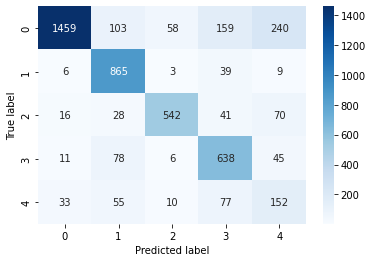

In [ ]:
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix

#since pred_race is a (4743,5) shaped numpy array we need to redefine it into 4743 list where each element has the index of the 5 lenght array where it is one.

pred_race = [int(np.where(pred_race[i] == 1)[0]) for i in range(len(pred_race))]

print('Accuracy: ' + str(metrics.accuracy_score(y_test_race, pred_race)))
print('Macro F1-score (multiclass) ' +  str(metrics.f1_score(y_test_race, pred_race,average='macro')))

conf = confusion_matrix(y_test_race,pred_race)

ax = sns.heatmap(conf,annot=True,fmt='d',cmap=plt.cm.Blues)
ax.set(xlabel="Predicted label",ylabel="True label")

Comparing the results with the original model, we cannot see any significant improvement. It is clear that this weighted model improved the race prediction in the smallest class (race=4), but on the other hand the result of the biggest class (race=0) decreased.

#SMOTE for the race modelling

### Initial Model

In [ ]:
import tensorflow.keras as keras

from keras.applications.inception_v3 import InceptionV3

inc_model = InceptionV3(weights='./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False,
                        input_shape=(200, 200, 3))

X = keras.layers.GlobalAveragePooling2D()(inc_model.output)

#dense_1 = Dense(256, activation='relu')(X)
#dense_2 = Dense(128, activation='relu')(dense_1)
#dense_3 = Dense(256, activation='relu')(X)
dense_4 = Dense(256, activation='relu')(X)

#dropout_1 = Dropout(0.4)(dense_2)
#dropout_2 = Dropout(0.4)(dense_3)
dropout_3 = Dropout(0.4)(dense_4)

#output_1 = Dense(1,activation='relu', name='age_output')(dropout_1)
#output_2 = Dense(1, activation='sigmoid', name='gender_output')(dropout_2)
output_3 = Dense(5, activation='softmax', name='race_output')(dropout_3)

model = keras.models.Model(inputs=inc_model.input, outputs=[output_3])

for layer in model.layers[:52]:
    layer.trainable = False
    
model.compile(loss=['categorical_crossentropy'], optimizer='adam', metrics = ['accuracy'])

### Learning on X_train_part1 [1]:

In [ ]:
path_current = '/content/drive/MyDrive/Artificial_Incoherence_float_data'

os.chdir(path_current)

# loading y_train data 
with open("./y_train.pkl","rb") as f:
    y_train = pickle.load(file=f)
    
y_train_part1 = y_train[:5000]

y_train_1_race = y_train_part1.race

y_train_1_race_part1 = y_train_1_race[:2500]

del y_train

del y_train_part1

del y_train_1_race

from imblearn.over_sampling import SMOTE

# loading X_train_part1 data 
with open("./X_train_part1.pkl","rb") as f:
    X_train_part1 = pickle.load(file=f)

X_train_part1_part1 = X_train_part1[:2500]

del X_train_part1

print(X_train_part1_part1.shape, y_train_1_race_part1.shape)

# transform the dataset
oversample = SMOTE()
X_train_part1_part1, y_train_1_race_part1 = oversample.fit_resample(X_train_part1_part1, y_train_1_race_part1)

X_train_part1_part1.shape, y_train_1_race_part1.shape
#y_train_1_race = to_categorical(y_train_1_race,5)

(2500, 120000) (2500,)


((5350, 120000), (5350,))

Class=1, n=1070 (20.000%)
Class=0, n=1070 (20.000%)
Class=3, n=1070 (20.000%)
Class=2, n=1070 (20.000%)
Class=4, n=1070 (20.000%)


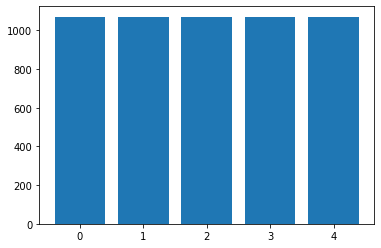

In [ ]:
from collections import Counter
from matplotlib import pyplot

counter = Counter(y_train_1_race_part1)
for k,v in counter.items():
	per = v / len(y_train_1_race_part1) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

It is clear from the plot that now we have the same datapoints for each class, so it is now a balanced classification.

In [ ]:
X_train_part1_part1 = X_train_part1_part1.reshape(-1,200,200,3)

y_train_1_race_part1 = to_categorical(y_train_1_race_part1,5)

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('smote_1.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)

history = model.fit(x=X_train_part1_part1,y= y_train_1_race_part1, batch_size = 32, epochs=50, validation_split= 0.1, callbacks = [es, save_best, plateau])

Epoch 1/50
151/151 [==============================] - 46s 186ms/step - loss: 1.2385 - accuracy: 0.5076 - val_loss: 5.5741 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/50
151/151 [==============================] - 27s 180ms/step - loss: 0.6863 - accuracy: 0.7661 - val_loss: 3.9785 - val_accuracy: 0.1084 - lr: 0.0010
Epoch 3/50
151/151 [==============================] - 29s 193ms/step - loss: 0.4679 - accuracy: 0.8372 - val_loss: 2.8750 - val_accuracy: 0.3215 - lr: 0.0010
Epoch 4/50
151/151 [==============================] - 27s 179ms/step - loss: 0.3700 - accuracy: 0.8795 - val_loss: 0.5379 - val_accuracy: 0.8075 - lr: 0.0010
Epoch 5/50
151/151 [==============================] - 23s 155ms/step - loss: 0.2822 - accuracy: 0.9082 - val_loss: 2.4650 - val_accuracy: 0.4187 - lr: 0.0010
Epoch 6/50
151/151 [==============================] - 26s 173ms/step - loss: 0.2207 - accuracy: 0.9310 - val_loss: 0.3250 - val_accuracy: 0.8935 - lr: 0.0010
Epoch 7/50
151/151 [============================

In [ ]:
del X_train_part1_part1

del y_train_1_race_part1

### Learning on X_train_part1 [2]:

In [ ]:
path_current = '/content/drive/MyDrive/Artificial_Incoherence_float_data'

os.chdir(path_current)

# loading y_train data 
with open("./y_train.pkl","rb") as f:
    y_train = pickle.load(file=f)
    
y_train_part1 = y_train[:5000]

y_train_1_race = y_train_part1.race

y_train_1_race_part2 = y_train_1_race[2500:5000]

del y_train

del y_train_part1

del y_train_1_race

from imblearn.over_sampling import SMOTE

# loading X_train_part1 data 
with open("./X_train_part1.pkl","rb") as f:
    X_train_part1 = pickle.load(file=f)

X_train_part1_part2 = X_train_part1[2500:5000]

del X_train_part1

print(X_train_part1_part2.shape, y_train_1_race_part2.shape)

# transform the dataset
oversample = SMOTE()
X_train_part1_part2, y_train_1_race_part2 = oversample.fit_resample(X_train_part1_part2, y_train_1_race_part2)

X_train_part1_part2.shape, y_train_1_race_part2.shape

(2500, 120000) (2500,)


((5235, 120000), (5235,))

In [ ]:
X_train_part1_part2 = X_train_part1_part2.reshape(-1,200,200,3)

y_train_1_race_part2 = to_categorical(y_train_1_race_part2,5)

In [ ]:
from keras.models import load_model

model = load_model('smote_1.h5')

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('smote_2.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)

history = model.fit(x=X_train_part1_part2,y= y_train_1_race_part2, batch_size = 32, epochs=50, validation_split= 0.1, callbacks = [es, save_best, plateau])

Epoch 1/50
148/148 [==============================] - 42s 184ms/step - loss: 0.5820 - accuracy: 0.8219 - val_loss: 2.1967 - val_accuracy: 0.2481 - lr: 0.0010
Epoch 2/50
Epoch 2/50
148/148 [==============================] - 26s 173ms/step - loss: 0.3051 - accuracy: 0.9045 - val_loss: 0.1328 - val_accuracy: 0.9523 - lr: 0.0010
Epoch 3/50
Epoch 3/50
148/148 [==============================] - 23s 154ms/step - loss: 0.2648 - accuracy: 0.9168 - val_loss: 0.2238 - val_accuracy: 0.9294 - lr: 0.0010
Epoch 4/50
Epoch 4/50
148/148 [==============================] - ETA: 0s - loss: 0.1293 - accuracy: 0.9601
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
148/148 [==============================] - 23s 153ms/step - loss: 0.1293 - accuracy: 0.9601 - val_loss: 1.5767 - val_accuracy: 0.4943 - lr: 0.0010
Epoch 5/50
Epoch 5/50
148/148 [==============================] - 26s 173ms/step - loss: 0.0528 - 

In [ ]:
del X_train_part1_part2

del y_train_1_race_part2

###Learning on X_train_part2 [1]

In [ ]:
path_current = '/content/drive/MyDrive/Artificial_Incoherence_float_data'

os.chdir(path_current)

# loading y_train data 
with open("./y_train.pkl","rb") as f:
    y_train = pickle.load(file=f)
    
y_train_part2 = y_train[5000:10000]

y_train_2_race = y_train_part2.race

y_train_2_race_part1 = y_train_2_race[:2500]

del y_train

del y_train_part2

del y_train_2_race

from imblearn.over_sampling import SMOTE

# loading X_train_part1 data 
with open("./X_train_part2.pkl","rb") as f:
    X_train_part2 = pickle.load(file=f)

X_train_part2_part1 = X_train_part2[:2500]

del X_train_part2

print(X_train_part2_part1.shape, y_train_2_race_part1.shape)

# transform the dataset
oversample = SMOTE()
X_train_part2_part1, y_train_2_race_part1 = oversample.fit_resample(X_train_part2_part1, y_train_2_race_part1)

X_train_part2_part1.shape, y_train_2_race_part1.shape

(2500, 120000) (2500,)


((5280, 120000), (5280,))

In [ ]:
X_train_part2_part1 = X_train_part2_part1.reshape(-1,200,200,3)

y_train_2_race_part1 = to_categorical(y_train_2_race_part1,5)

In [ ]:
from keras.models import load_model

model = load_model('smote_2.h5')

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('smote_3.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)

history = model.fit(x=X_train_part2_part1,y= y_train_2_race_part1, batch_size = 32, epochs=50, validation_split= 0.1, callbacks = [es, save_best, plateau])

Epoch 1/50
149/149 [==============================] - 41s 177ms/step - loss: 1.3503 - accuracy: 0.7774 - val_loss: 3.5525 - val_accuracy: 0.3788 - lr: 7.2900e-07
Epoch 2/50
149/149 [==============================] - 25s 169ms/step - loss: 1.2613 - accuracy: 0.7778 - val_loss: 3.4297 - val_accuracy: 0.3977 - lr: 7.2900e-07
Epoch 3/50
149/149 [==============================] - 26s 171ms/step - loss: 1.2262 - accuracy: 0.7776 - val_loss: 3.2954 - val_accuracy: 0.4053 - lr: 7.2900e-07
Epoch 4/50
149/149 [==============================] - 25s 168ms/step - loss: 1.1892 - accuracy: 0.7864 - val_loss: 3.2155 - val_accuracy: 0.4072 - lr: 7.2900e-07
Epoch 5/50
149/149 [==============================] - 25s 170ms/step - loss: 1.1821 - accuracy: 0.7862 - val_loss: 3.1786 - val_accuracy: 0.4110 - lr: 7.2900e-07
Epoch 6/50
149/149 [==============================] - 25s 166ms/step - loss: 1.1389 - accuracy: 0.7887 - val_loss: 3.1057 - val_accuracy: 0.4129 - lr: 7.2900e-07
Epoch 7/50
149/149 [========

### Learning on X_train_part2 [2]

In [ ]:
path_current = '/content/drive/MyDrive/Artificial_Incoherence_float_data'

os.chdir(path_current)

# loading y_train data 
with open("./y_train.pkl","rb") as f:
    y_train = pickle.load(file=f)
    
y_train_part2 = y_train[5000:10000]

y_train_2_race = y_train_part2.race

y_train_2_race_part2 = y_train_2_race[2500:5000]

del y_train

del y_train_part2

del y_train_2_race

from imblearn.over_sampling import SMOTE

# loading X_train_part2 data 
with open("./X_train_part2.pkl","rb") as f:
    X_train_part2 = pickle.load(file=f)

X_train_part2_part2 = X_train_part2[2500:5000]

del X_train_part2

print(X_train_part2_part2.shape, y_train_2_race_part2.shape)

# transform the dataset
oversample = SMOTE()
X_train_part2_part2, y_train_2_race_part2 = oversample.fit_resample(X_train_part2_part2, y_train_2_race_part2)

X_train_part2_part2.shape, y_train_2_race_part2.shape

(2500, 120000) (2500,)


((5235, 120000), (5235,))

In [ ]:
X_train_part2_part2 = X_train_part2_part2.reshape(-1,200,200,3)

y_train_2_race_part2 = to_categorical(y_train_2_race_part2,5)

In [ ]:
from keras.models import load_model

model = load_model('smote_3.h5')

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('smote_4.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)

history = model.fit(x=X_train_part2_part2,y= y_train_2_race_part2, batch_size = 32, epochs=50, validation_split= 0.1, callbacks = [es, save_best, plateau])

Epoch 1/50
148/148 [==============================] - 47s 195ms/step - loss: 0.7527 - accuracy: 0.8092 - val_loss: 2.0188 - val_accuracy: 0.4714 - lr: 7.2900e-07
Epoch 2/50
148/148 [==============================] - 26s 173ms/step - loss: 0.7363 - accuracy: 0.8068 - val_loss: 1.9559 - val_accuracy: 0.4809 - lr: 7.2900e-07
Epoch 3/50
148/148 [==============================] - 26s 172ms/step - loss: 0.7336 - accuracy: 0.8064 - val_loss: 1.9301 - val_accuracy: 0.4866 - lr: 7.2900e-07
Epoch 4/50
148/148 [==============================] - 25s 170ms/step - loss: 0.7173 - accuracy: 0.8077 - val_loss: 1.9176 - val_accuracy: 0.4809 - lr: 7.2900e-07
Epoch 5/50
148/148 [==============================] - 27s 182ms/step - loss: 0.7092 - accuracy: 0.8119 - val_loss: 1.8922 - val_accuracy: 0.4790 - lr: 7.2900e-07
Epoch 6/50
148/148 [==============================] - 26s 177ms/step - loss: 0.7199 - accuracy: 0.8090 - val_loss: 1.8843 - val_accuracy: 0.4809 - lr: 7.2900e-07
Epoch 7/50
148/148 [========

In [ ]:
del X_train_part2_part2

del y_train_2_race_part2

### Learning on X_train_part3 [1]

In [ ]:
path_current = '/content/drive/MyDrive/Artificial_Incoherence_float_data'

os.chdir(path_current)

# loading y_train data 
with open("./y_train.pkl","rb") as f:
    y_train = pickle.load(file=f)
    
y_train_part3 = y_train[10000:15000]

y_train_3_race = y_train_part3.race

y_train_3_race_part1 = y_train_3_race[:2500]

del y_train

del y_train_part3

del y_train_3_race

from imblearn.over_sampling import SMOTE

# loading X_train_part1 data 
with open("./X_train_part3.pkl","rb") as f:
    X_train_part3 = pickle.load(file=f)

X_train_part3_part1 = X_train_part3[:2500]

del X_train_part3

print(X_train_part3_part1.shape, y_train_3_race_part1.shape)

# transform the dataset
oversample = SMOTE()
X_train_part3_part1, y_train_3_race_part1 = oversample.fit_resample(X_train_part3_part1, y_train_3_race_part1)

X_train_part3_part1.shape, y_train_3_race_part1.shape

(2500, 120000) (2500,)


((5285, 120000), (5285,))

In [ ]:
X_train_part3_part1 = X_train_part3_part1.reshape(-1,200,200,3)

y_train_3_race_part1 = to_categorical(y_train_3_race_part1,5)

In [ ]:
from keras.models import load_model

model = load_model('smote_4.h5')

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('smote_5.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)

history = model.fit(x=X_train_part3_part1,y= y_train_3_race_part1, batch_size = 32, epochs=50, validation_split= 0.1, callbacks = [es, save_best, plateau])

Epoch 1/50
149/149 [==============================] - 52s 244ms/step - loss: 0.6383 - accuracy: 0.8019 - val_loss: 1.3386 - val_accuracy: 0.5331 - lr: 7.2900e-07
Epoch 2/50
149/149 [==============================] - 24s 162ms/step - loss: 0.6418 - accuracy: 0.7998 - val_loss: 1.3404 - val_accuracy: 0.5293 - lr: 7.2900e-07
Epoch 3/50
149/149 [==============================] - 29s 193ms/step - loss: 0.6112 - accuracy: 0.8118 - val_loss: 1.3383 - val_accuracy: 0.5274 - lr: 7.2900e-07
Epoch 4/50
149/149 [==============================] - 30s 203ms/step - loss: 0.6050 - accuracy: 0.8116 - val_loss: 1.3221 - val_accuracy: 0.5312 - lr: 7.2900e-07
Epoch 5/50
149/149 [==============================] - 29s 196ms/step - loss: 0.5997 - accuracy: 0.8141 - val_loss: 1.3143 - val_accuracy: 0.5331 - lr: 7.2900e-07
Epoch 6/50
149/149 [==============================] - 28s 185ms/step - loss: 0.6053 - accuracy: 0.8108 - val_loss: 1.3003 - val_accuracy: 0.5406 - lr: 7.2900e-07
Epoch 7/50
149/149 [========

### Learning on X_train_part3 [2]

In [ ]:
path_current = '/content/drive/MyDrive/Artificial_Incoherence_float_data'

os.chdir(path_current)

# loading y_train data 
with open("./y_train.pkl","rb") as f:
    y_train = pickle.load(file=f)
    
y_train_part3 = y_train[10000:15000]

y_train_3_race = y_train_part3.race

y_train_3_race_part2 = y_train_3_race[2500:5000]

del y_train

del y_train_part3

del y_train_3_race

from imblearn.over_sampling import SMOTE

# loading X_train_part3 data 
with open("./X_train_part3.pkl","rb") as f:
    X_train_part3 = pickle.load(file=f)

X_train_part3_part2 = X_train_part3[2500:5000]

del X_train_part3

print(X_train_part3_part2.shape, y_train_3_race_part2.shape)

# transform the dataset
oversample = SMOTE()
X_train_part3_part2, y_train_3_race_part2 = oversample.fit_resample(X_train_part3_part2, y_train_3_race_part2)

X_train_part3_part2.shape, y_train_3_race_part2.shape

(2500, 120000) (2500,)


((5510, 120000), (5510,))

In [ ]:
X_train_part3_part2 = X_train_part3_part2.reshape(-1,200,200,3)

y_train_3_race_part2 = to_categorical(y_train_3_race_part2,5)

In [ ]:
from keras.models import load_model

model = load_model('smote_5.h5')

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('smote_6.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)

history = model.fit(x=X_train_part3_part2,y= y_train_3_race_part2, batch_size = 32, epochs=50, validation_split= 0.1, callbacks = [es, save_best, plateau])

Epoch 1/50
155/155 [==============================] - 49s 225ms/step - loss: 0.5999 - accuracy: 0.8113 - val_loss: 1.1975 - val_accuracy: 0.5118 - lr: 7.2900e-07
Epoch 2/50
155/155 [==============================] - 29s 189ms/step - loss: 0.5925 - accuracy: 0.8129 - val_loss: 1.1826 - val_accuracy: 0.5136 - lr: 7.2900e-07
Epoch 3/50
155/155 [==============================] - 30s 196ms/step - loss: 0.5995 - accuracy: 0.8084 - val_loss: 1.1731 - val_accuracy: 0.5118 - lr: 7.2900e-07
Epoch 4/50
155/155 [==============================] - 30s 192ms/step - loss: 0.5828 - accuracy: 0.8121 - val_loss: 1.1598 - val_accuracy: 0.5263 - lr: 7.2900e-07
Epoch 5/50
155/155 [==============================] - 32s 206ms/step - loss: 0.5882 - accuracy: 0.8129 - val_loss: 1.1520 - val_accuracy: 0.5281 - lr: 7.2900e-07
Epoch 6/50
155/155 [==============================] - 28s 178ms/step - loss: 0.5691 - accuracy: 0.8189 - val_loss: 1.1305 - val_accuracy: 0.5354 - lr: 7.2900e-07
Epoch 7/50
155/155 [========

In [ ]:
del X_train_part3_part2

del y_train_3_race_part2

### Learning on X_train_part4 [1]

In [ ]:
path_current = '/content/drive/MyDrive/Artificial_Incoherence_float_data'

os.chdir(path_current)

# loading y_train data 
with open("./y_train.pkl","rb") as f:
    y_train = pickle.load(file=f)
    
y_train_part4 = y_train[15000:]

y_train_4_race = y_train_part4.race

y_train_4_race_part1 = y_train_4_race[:2000]

del y_train

del y_train_part4

del y_train_4_race

from imblearn.over_sampling import SMOTE

# loading X_train_part4 data 
with open("./X_train_part4.pkl","rb") as f:
    X_train_part4 = pickle.load(file=f)

X_train_part4_part1 = X_train_part4[:2000]

del X_train_part4

print(X_train_part4_part1.shape, y_train_4_race_part1.shape)

# transform the dataset
oversample = SMOTE()
X_train_part4_part1, y_train_4_race_part1 = oversample.fit_resample(X_train_part4_part1, y_train_4_race_part1)

X_train_part4_part1.shape, y_train_4_race_part1.shape

(2000, 120000) (2000,)


((4265, 120000), (4265,))

In [ ]:
X_train_part4_part1 = X_train_part4_part1.reshape(-1,200,200,3)

y_train_4_race_part1 = to_categorical(y_train_4_race_part1,5)

In [ ]:
from keras.models import load_model

model = load_model('smote_6.h5')

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('smote_7.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)

history = model.fit(x=X_train_part4_part1,y= y_train_4_race_part1, batch_size = 32, epochs=50, validation_split= 0.1, callbacks = [es, save_best, plateau])

Epoch 1/50
120/120 [==============================] - 40s 219ms/step - loss: 0.5513 - accuracy: 0.8210 - val_loss: 1.1602 - val_accuracy: 0.5386 - lr: 7.2900e-07
Epoch 2/50
120/120 [==============================] - 22s 180ms/step - loss: 0.5573 - accuracy: 0.8223 - val_loss: 1.1517 - val_accuracy: 0.5410 - lr: 7.2900e-07
Epoch 3/50
120/120 [==============================] - 21s 175ms/step - loss: 0.5518 - accuracy: 0.8181 - val_loss: 1.1486 - val_accuracy: 0.5433 - lr: 7.2900e-07
Epoch 4/50
120/120 [==============================] - 21s 173ms/step - loss: 0.5391 - accuracy: 0.8202 - val_loss: 1.1480 - val_accuracy: 0.5433 - lr: 7.2900e-07
Epoch 5/50
120/120 [==============================] - 18s 149ms/step - loss: 0.5471 - accuracy: 0.8166 - val_loss: 1.1512 - val_accuracy: 0.5386 - lr: 7.2900e-07
Epoch 6/50
120/120 [==============================] - 21s 174ms/step - loss: 0.5385 - accuracy: 0.8174 - val_loss: 1.1444 - val_accuracy: 0.5410 - lr: 7.2900e-07
Epoch 7/50
120/120 [========

### Learning on X_train_part4 [2]

In [ ]:
path_current = '/content/drive/MyDrive/Artificial_Incoherence_float_data'

os.chdir(path_current)

# loading y_train data 
with open("./y_train.pkl","rb") as f:
    y_train = pickle.load(file=f)
    
y_train_part4 = y_train[15000:]

y_train_4_race = y_train_part4.race

y_train_4_race_part2 = y_train_4_race[2000:]

del y_train

del y_train_part4

del y_train_4_race

from imblearn.over_sampling import SMOTE

# loading X_train_part4 data 
with open("./X_train_part4.pkl","rb") as f:
    X_train_part4 = pickle.load(file=f)

X_train_part4_part2 = X_train_part4[2000:]

del X_train_part4

print(X_train_part4_part2.shape, y_train_4_race_part2.shape)

# transform the dataset
oversample = SMOTE()
X_train_part4_part2, y_train_4_race_part2 = oversample.fit_resample(X_train_part4_part2, y_train_4_race_part2)

X_train_part4_part2.shape, y_train_4_race_part2.shape

(1972, 120000) (1972,)


((4185, 120000), (4185,))

In [ ]:
X_train_part4_part2 = X_train_part4_part2.reshape(-1,200,200,3)

y_train_4_race_part2 = to_categorical(y_train_4_race_part2,5)

In [ ]:
from keras.models import load_model

model = load_model('smote_7.h5')

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('smote_8.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)

history = model.fit(x=X_train_part4_part2,y= y_train_4_race_part2, batch_size = 32, epochs=50, validation_split= 0.1, callbacks = [es, save_best, plateau])

Epoch 1/50
118/118 [==============================] - 22s 183ms/step - loss: 0.5287 - accuracy: 0.8189 - val_loss: 1.2279 - val_accuracy: 0.4773 - lr: 5.9049e-09
Epoch 2/50
118/118 [==============================] - 21s 179ms/step - loss: 0.5252 - accuracy: 0.8205 - val_loss: 1.2261 - val_accuracy: 0.4797 - lr: 5.9049e-09
Epoch 3/50
118/118 [==============================] - 21s 176ms/step - loss: 0.5170 - accuracy: 0.8277 - val_loss: 1.2242 - val_accuracy: 0.4797 - lr: 5.9049e-09
Epoch 4/50
118/118 [==============================] - 21s 181ms/step - loss: 0.5271 - accuracy: 0.8226 - val_loss: 1.2197 - val_accuracy: 0.4797 - lr: 5.9049e-09
Epoch 5/50
118/118 [==============================] - 21s 174ms/step - loss: 0.5150 - accuracy: 0.8253 - val_loss: 1.2187 - val_accuracy: 0.4821 - lr: 5.9049e-09
Epoch 6/50
118/118 [==============================] - 18s 150ms/step - loss: 0.5183 - accuracy: 0.8205 - val_loss: 1.2197 - val_accuracy: 0.4797 - lr: 5.9049e-09
Epoch 7/50
118/118 [========

In [ ]:
del X_train_part4_part2

del y_train_4_race_part2

# Evaluation of SMOTE (saved as smote_8.ht)

In [ ]:
path_current = '/content/drive/MyDrive/Artificial_Incoherence_float_data'

os.chdir(path_current)

# loading y_test data 
with open("./y_test.pkl","rb") as f:
    y_test = pickle.load(file=f)

y_test_race = y_test.race

from keras.models import load_model

model = load_model('smote_8.h5')

# loading X_test data 
with open("./X_test2.pkl","rb") as f:
    X_test = pickle.load(file=f)

X_test = X_test.reshape(-1,200,200,3)

pred_race = model.predict(X_test)

pred_race = (pred_race == pred_race.max(axis=1, keepdims=1)).astype(float) #this turns the max value to 1 and the rest to 0

149/149 [==============================] - 17s 59ms/step


Accuracy: 0.8064516129032258
Macro F1-score (multiclass) 0.734988545331299


[Text(33.0, 0.5, 'True label'), Text(0.5, 15.0, 'Predicted label')]

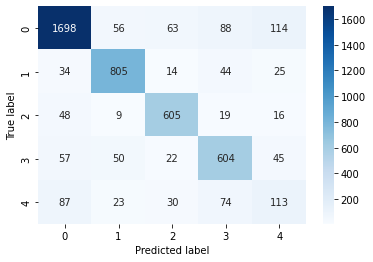

In [ ]:
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix

#since pred_race is a (4743,5) shaped numpy array we need to redefine it into 4743 list where each element has the index of the 5 lenght array where it is one.

pred_race = [int(np.where(pred_race[i] == 1)[0]) for i in range(len(pred_race))]

print('Accuracy: ' + str(metrics.accuracy_score(y_test_race, pred_race)))
print('Macro F1-score (multiclass) ' +  str(metrics.f1_score(y_test_race, pred_race,average='macro')))

conf = confusion_matrix(y_test_race,pred_race)

ax = sns.heatmap(conf,annot=True,fmt='d',cmap=plt.cm.Blues)
ax.set(xlabel="Predicted label",ylabel="True label")

Using the SMOTE method, we see that there is no significant improvement comparing the results to the original model.

# MTCNN face detection

We will use the pre-trained Keras MTCNN model provided by Iván de Paz Centeno in the ipazc/mtcnn project. By default the MTCNN bundles a face detection weights model. The model is adapted from the Facenet's MTCNN implementation.
<p>This model is going to be very useful in our mobile application, because it can detect a face even on a bigger picture (where the face is just a small part).
<p> The plan is to use this model to get only the face (200*200 pixels) from a given picture, and then use our other model to predict age, gender and race. This idea came from the fact, that our training dataset contains images of only faces, so it might not work well on pictures where the face is just a smaller part.
<p> Source: https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/

### Face detection model

In [ ]:
path_current = '/content/drive/MyDrive/Artificial_Incoherence_float_data'

os.chdir(path_current)

In [ ]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 4.4 MB/s 


In [ ]:
#using a selected picture to try the model
filename = "./minta.jpg"

# load image from file
image = Image.open(filename)

# convert to RGB, if needed
image = image.convert('RGB')

# convert to array
pixels = np.asarray(image)

Let's see the whole picture:

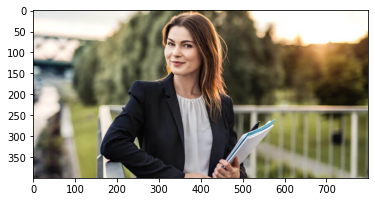

In [ ]:
plt.imshow(image)

In [ ]:
from mtcnn.mtcnn import MTCNN

# create the detector, using default weights
detector = MTCNN()

# detect faces in the image
results = detector.detect_faces(pixels)

1/1 [==============================] - 0s 110ms/step


The result is a list of bounding boxes, where each bounding box defines a lower-left-corner of the bounding box, as well as the width and height.
<p> If we assume there is only one face in the photo for our experiments, we can determine the pixel coordinates of the bounding box as follows. Sometimes the library will return a negative pixel index. It can be fixed by taking the absolute value of the coordinates.

In [ ]:
# extract the bounding box from the first face
x1, y1, width, height = results[0]['box']

# bug fix
x1, y1 = abs(x1), abs(y1)
x2, y2 = x1 + width, y1 + height

We can use these coordinates to extract the face.

In [ ]:
# extract the face
face = pixels[y1:y2, x1:x2]

We can then use the PIL library to resize this small image of the face to the required size; specifically, our prediction model expects square input faces with the shape 200×200.

In [ ]:
# resize pixels to the model size
image = Image.fromarray(face)
image = image.resize((200, 200))

Let's see the detected face:

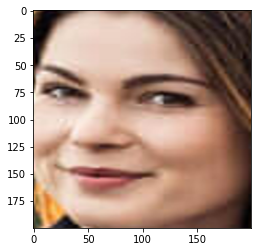

In [ ]:
plt.imshow(image)

Tying all of this together, the function extract_face() will load a photograph from the loaded filename and return the extracted face. It assumes that the photo contains one face and will return the first face detected.

In [ ]:
# extract a single face from a given photograph

def extract_face(filename, required_size=(200, 200)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    face_array = face_array.astype("float32")
    return face_array

In [ ]:
# load the photo and extract the face
image_proba = extract_face(filename, required_size=(200, 200))

1/1 [==============================] - 0s 112ms/step


In [ ]:
image_proba.shape

(200, 200, 3)

This model works very well. Our aim is to give a selected picture to this model, then we get only the face from the selected picture. Then we can give only the face to our other model, which is going to predict age, gender and race.

### Making a pipeline with both models

Let's try the whole pipeline. First we give a selected picture to the face detection model, then we give the output (array of 200*200 pixel image of the face on the selected picture) to our other model, which predicts the age, gender and race.

In [ ]:
path_current = '/content/drive/MyDrive/Artificial_Incoherence_float_data'

os.chdir(path_current)

In [ ]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 5.4 MB/s 


In [ ]:
from PIL import Image
from numpy import asarray
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN

def extract_face(filename, required_size=(200, 200)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    face_array = face_array.astype("float32")
    return face_array

In [ ]:
#using a selected picture to try the model
filename = "./minta.jpg"

In [ ]:
output1 = extract_face(filename, required_size=(200, 200))

1/1 [==============================] - 0s 127ms/step


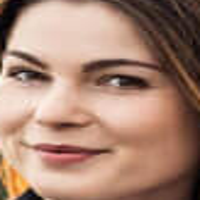

In [ ]:
output1_int = output1.astype("uint8")
image1 = Image.fromarray(output1_int)
image1

In [ ]:
output1 = output1/255

In [ ]:
from keras.models import load_model

model = load_model('model_inceptionv3_part4.h5')

In [ ]:
output1_reshaped = output1.reshape(-1,200,200,3)

output2 = model.predict(output1_reshaped)

1/1 [==============================] - 3s 3s/step


In [ ]:
pred_age = output2[0].round()

pred_gender = output2[1]
pred_gender = pred_gender.round()

pred_race = output2[2]
pred_race = (pred_race == pred_race.max(axis=1, keepdims=1)).astype(float) #this turns the max value to 1 and the rest to 0

pred_race = [int(np.where(pred_race[i] == 1)[0]) for i in range(len(pred_race))]

pred_age = pred_age[0][0]
pred_gender = pred_gender[0][0]
pred_race = pred_race[0]

Just a reminder:

Gender: 0 is male, 1 is female

Race: 1 is White, 2 is Black, 3 is Asian, 4 is Indian and 5 is Other

In [ ]:
gender_dict = {0:"Male",1:"Female"}
race_dict = {0:"White",1:"Black",2:"Asian",3:"Indian",4:"Other"}

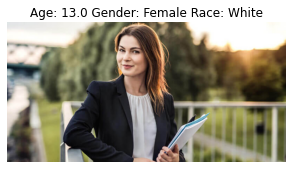

In [ ]:
plt.figure(figsize=(5,5))

plt.imshow(Image.open(filename))
plt.title(f"Age: {pred_age} Gender: {gender_dict[pred_gender]} Race: {race_dict[pred_race]}")
plt.axis('off')
plt.show()

The model predicted the gender and the race correctly, but the age seems to be a bit low for this woman.

Another example:

In [ ]:
#using a selected picture to try the model
filename = "./proba2.jpg"

In [ ]:
output1 = extract_face(filename, required_size=(200, 200))

1/1 [==============================] - 0s 148ms/step


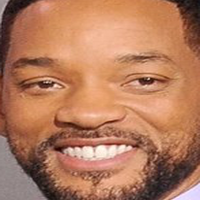

In [ ]:
output1_int = output1.astype("uint8")
image1 = Image.fromarray(output1_int)
image1

In [ ]:
output1 = output1/255

In [ ]:
output1_reshaped = output1.reshape(-1,200,200,3)

output2 = model.predict(output1_reshaped)

1/1 [==============================] - 0s 38ms/step


In [ ]:
pred_age = output2[0].round()

pred_gender = output2[1]
pred_gender = pred_gender.round()

pred_race = output2[2]
pred_race = (pred_race == pred_race.max(axis=1, keepdims=1)).astype(float) #this turns the max value to 1 and the rest to 0

pred_race = [int(np.where(pred_race[i] == 1)[0]) for i in range(len(pred_race))]

pred_age = pred_age[0][0]
pred_gender = pred_gender[0][0]
pred_race = pred_race[0]

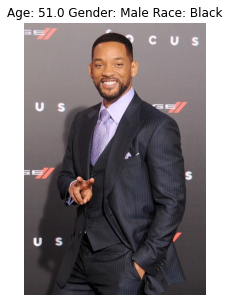

In [ ]:
plt.figure(figsize=(5,5))

plt.imshow(Image.open(filename))
plt.title(f"Age: {pred_age} Gender: {gender_dict[pred_gender]} Race: {race_dict[pred_race]}")
plt.axis('off')
plt.show()

At this picture, the gender and the race is correctly predicted and the age also seems to be accurate.

# Hyperparameter optimization

We decided to minimize the val_loss. This is because we have 3 different target variables, and each of them is a different type (continious, binary, cathegorical), so we cannot easily maximize the accuracy or something like that.

### Results

After about a million Colab crashes, we saved our results locally to our machine. With the free version of Colab we couldn't do much although we tried. 

For the InceptionV3 we have the following table:

In [ ]:
import pandas

hyperas_log = pandas.read_csv('inceptionv3_param.csv', delimiter=';')

hyperas_log

n_layer1  n_layer2  n_layer3  dropout_1  dropout_2  dropout_3    act  \
0        512       128       256   0.008909   0.422515   0.305438  swish   
1        128       256       512   0.217021   0.348754   0.257640  swish   
2        128       512       512   0.355712   0.281191   0.197497  swish   
3        256       256       256   0.498777   0.495601   0.382308   relu   
4        256       512       512   0.396858   0.418214   0.476637   relu   
5        512       512       512   0.102620   0.213359   0.476214  swish   
6        512       512       128   0.384503   0.477662   0.359519   relu   
7        512       256       256   0.105498   0.146636   0.365115  swish   
8        256       512       512   0.323708   0.407988   0.393533   relu   
9        128       256       128   0.085130   0.382897   0.372315  swish   
10       512       128       256   0.008909   0.422515   0.305438  swish   
11       128       256       512   0.217021   0.348754   0.257640  swish   
12       128       512       512   0.355712   0.281191   0.197497  swish   
13       256       256       256   0.498777   0.495601   0.382308   relu   
14       256       512       512   0.396858   0.418214   0.476637   relu   
15       512       512       512   0.102620   0.213359   0.476214  swish   
16       512       512       128   0.384503   0.477662   0.359519   relu   
17       512       256       256   0.105498   0.146636   0.365115  swish   
18       256       512       512   0.323708   0.407988   0.393533   relu   
19       128       256       128   0.085130   0.382897   0.372315  swish   

      optim  n_batch  best_val_loss  
0       sgd      128       2.150545  
1   rmsprop      256       2.425108  
2      adam      128       0.983399  
3      adam      256       2.575344  
4   rmsprop      256       2.093735  
5       sgd       64       2.291339  
6   rmsprop       64       0.892120  
7       sgd      256       2.256716  
8   rmsprop      256      27.085949  
9      adam      256      27.936729  
10      sgd      128       0.858727  
11  rmsprop      256       0.775577  
12     adam      128       6.647319  
13     adam      256       2.442626  
14  rmsprop      256       3.587079  
15      sgd       64       1.789056  
16  rmsprop       64       1.874604  
17      sgd      256       1.017180  
18  rmsprop      256       2.170912  
19     adam      256       6.971391

so the optimal in this case would be to use:

In [ ]:
hyperas_log.iloc[11]

n_layer1              128
n_layer2              256
n_layer3              512
dropout_1        0.217021
dropout_2        0.348754
dropout_3         0.25764
act                 swish
optim             rmsprop
n_batch               256
best_val_loss    0.775577
Name: 11, dtype: object

For CNN models we have:

In [ ]:
import pandas

hyperas_log = pandas.read_csv('cnn_param.csv', delimiter='\t',index_col = 0)

hyperas_log

n_layer1   n_layer2   n_layer3   dropout_1   dropout_2   dropout_3   \
                                                                          
0         128        128        256    0.008909    0.422515    0.305438   
1         128        128        128    0.305438    0.368585    0.325898   
2         128        128        256    0.008909    0.422515    0.305438   
3         128        256        128    0.217021    0.348754    0.257640   
4         128        128        128    0.355712    0.281191    0.197497   
5         256        256        256    0.498777    0.495601    0.382308   
6         128        128        256    0.056230    0.160376    0.367107   
7         128        256        128    0.217021    0.348754    0.257640   
8         128        128        128    0.485930    0.072572    0.236343   
9         256        256        256    0.498777    0.495601    0.382308   
10        256        128        256    0.476637    0.068748    0.293803   
11        128        128        256    0.056230    0.160376    0.367107   
12        128        256        512    0.217021    0.348754    0.257640   
13        128        128        512    0.485930    0.072572    0.236343   
14        256        256        256    0.498777    0.495601    0.382308   

      act     optim   n_batch   best_val_loss  
                                               
0   swish       sgd        128       0.972850  
1    relu       sgd        128       0.971973  
2   swish       sgd         64       0.973474  
3   swish   rmsprop        128       2.029674  
4   swish      adam         64       1.971599  
5    relu      adam        128       0.701597  
6   swish       sgd         64       0.973185  
7   swish   rmsprop         32       1.950158  
8   swish      adam         64       1.945967  
9    relu      adam         32       2.007971  
10   relu   rmsprop         64       1.996831  
11  swish       sgd         64       6.821559  
12  swish   rmsprop         32       1.963205  
13  swish      adam         64       1.959163  
14   relu      adam         32       0.707280

so the optimal in this case would be:

In [ ]:
hyperas_log.iloc[5]

                        5
n_layer1              256
n_layer2              256
n_layer3              256
dropout_1        0.498777
dropout_2        0.495601
dropout_3        0.382308
act                 relu 
optim               adam 
n_batch               128
best_val_loss    0.701597
Name: 5, dtype: object

In the case of ImageNet Learning we have the following table:

In [ ]:
import pandas
hyperas_log = pandas.read_csv('imagenet_param.csv', delimiter='\t',index_col = 0)

hyperas_log

n_layer1   n_layer2   n_layer3   dropout_1   dropout_2   dropout_3   \
0         512        128        256    0.008909    0.422515    0.305438   
1         128        256        512    0.217021    0.348754    0.257640   
2         128        512        512    0.355712    0.281191    0.197497   
3         256        256        256    0.498777    0.495601    0.382308   
4         128        128        256    0.008909    0.422515    0.305438   
5         128        128        512    0.355712    0.281191    0.197497   
6         128        128        256    0.056230    0.160376    0.367107   
7         128        256        512    0.217021    0.348754    0.257640   
8         128        128        512    0.485930    0.072572    0.236343   
9         256        256        256    0.498777    0.495601    0.382308   
10        256        256        512    0.427364    0.448256    0.016617   
11        128        128        512    0.095205    0.040319    0.488641   
12        128        128        128    0.092293    0.496949    0.114191   
13        256        256        256    0.128268    0.155582    0.103350   

      act     optim   n_batch   best_val_loss  
0   swish       sgd        128       0.985566  
1   swish   rmsprop        256       0.761318  
2   swish      adam        128       0.651595  
3    relu      adam        256       0.692127  
4   swish       sgd        128       1.240834  
5   swish      adam        128       0.779508  
6   swish       sgd         64       0.695948  
7   swish   rmsprop         32       0.619434  
8   swish      adam         64       0.793380  
9    relu      adam         32       0.574767  
10  swish   rmsprop         32       0.612525  
11   relu       sgd         64       0.953160  
12  swish   rmsprop         64       0.799365  
13   relu       sgd         32       6.558485

we would recommend to use:

In [ ]:
hyperas_log.iloc[9]

n_layer1              256
n_layer2              256
n_layer3              256
dropout_1        0.498777
dropout_2        0.495601
dropout_3        0.382308
act                 relu 
optim               adam 
n_batch                32
best_val_loss    0.574767
Name: 9, dtype: object

### InceptionV3 Learning

In [ ]:
def data():

    # loading X_train_part1 data 
    with open("./X_train_part1.pkl","rb") as f:
      X_train_part1 = pickle.load(file=f)

    X_train_part1 = X_train_part1[:2200]
    X_train = X_train_part1.reshape(-1,200,200,3)

    # loading y_train data 
    with open("./y_train.pkl","rb") as f:
      y_train = pickle.load(file=f)
    
    y_train = y_train[:2200]

    y_train = y_train.race

    y_train = to_categorical(y_train,5)

    # loading X_test data 
    with open("./X_test2.pkl","rb") as f:
        X_test = pickle.load(file=f)
    
    X_test = X_test.reshape(-1,200,200,3)

    # loading y_test data 
    with open("./y_test.pkl","rb") as f:
        y_test = pickle.load(file=f)

  
    return X_train, y_train, X_test, y_test

In [ ]:
import tensorflow.keras as keras
from keras.applications.inception_v3 import InceptionV3

def create_model(X_train, y_train, X_test, y_test):

  inc_model = InceptionV3(weights='./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                          include_top=False,
                          input_shape=(200, 200, 3))
  
  n_layer1 = {{choice([128, 256, 512])}}
  n_layer2 = {{choice([128, 256, 512])}}
  n_layer3 = {{choice([128, 256, 512])}}
  
  dropout_1_c = {{uniform(0, 0.5)}}
  dropout_2_c = {{uniform(0, 0.5)}}
  dropout_3_c = {{uniform(0, 0.5)}}

#, 'leakyrelu'

  act = {{choice(['relu', 'swish'])}}

  optim = {{choice(['rmsprop', 'adam', 'sgd'])}}

  n_batch = {{choice([64, 128, 256])}}

  print('Az aktuális modell hiperparaméterei: ', n_layer1, n_layer2, n_layer3, dropout_1_c, dropout_2_c, dropout_3_c, act, optim, n_batch)

  X = keras.layers.GlobalAveragePooling2D()(inc_model.output)

  dense_1 = Dense(n_layer1, activation= act)(X)
  dense_2 = Dense(n_layer1, activation= act)(dense_1)
  dense_3 = Dense(n_layer2, activation= act)(X)
  dense_4 = Dense(n_layer3, activation = act)(X)

  dropout_1 = Dropout(dropout_1_c)(dense_2)
  dropout_2 = Dropout(dropout_2_c)(dense_3)
  dropout_3 = Dropout(dropout_3_c)(dense_4)

  output_1 = Dense(1,activation= act, name='age_output')(dropout_1)
  output_2 = Dense(1, activation= act, name='gender_output')(dropout_2)
  output_3 = Dense(5, activation='softmax', name='race_output')(dropout_3)

  model = keras.models.Model(inputs=inc_model.input, outputs=[output_1,output_2,output_3])

  for layer in model.layers[:52]:
      layer.trainable = False
    
  model.compile(loss=['mse','binary_crossentropy','categorical_crossentropy'], optimizer= optim, loss_weights = [0.001,0.5,0.5], 
              metrics = {'age_output': 'mean_squared_error', 'gender_output': 'accuracy', 'race_output': 'accuracy'})

  plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
  #save_best = tf.keras.callbacks.ModelCheckpoint('csabi_weighted_1.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)

  result = model.fit(x=X_train,y= y_train, batch_size = n_batch, epochs=50, validation_split= 0.1, callbacks = [es, plateau]) 

  # az epoch-ok közül a legkisebb val_loss elmentése

  best_val_loss = np.amin(result.history['val_loss'])

  #best_val_acc_age = np.amax(result.history['val_age_output_mean_squared_error'])
  #best_val_acc_gender = np.amax(result.history['val_gender_output_accuracy'])
  #best_val_acc_race = np.amax(result.history['val_race_output_accuracy'])

  # log kiírása: háló struktúra, és az eredmény
  with open('CNN_first.csv', 'a') as csv_file:
      csv_file.write(str(n_layer1) + ';')
      csv_file.write(str(n_layer2) + ';')
      csv_file.write(str(n_layer3) + ';')
      csv_file.write(str(dropout_1_c) + ';')
      csv_file.write(str(dropout_2_c) + ';')
      csv_file.write(str(dropout_3_c) + ';')
      csv_file.write(str(act) + ';')
      csv_file.write(str(optim) + ';')
      csv_file.write(str(n_batch) + ';')
      csv_file.write(str(best_val_loss) + '\n')
      #csv_file.write(str(best_val_acc_gender) + ';')
      #csv_file.write(str(best_val_acc_race) +  '\n')

#'loss_gender': -best_val_acc_gender, 'loss_race': -best_val_acc_race,

  # negatív val_acc, mert a hyperopt csomag mindig minimalizál
  return {'loss': best_val_loss, 'status': STATUS_OK, 'model': model}

In [ ]:
# log fájl inicializálás / fejléc
with open('CNN_first.csv', 'w') as csv_file:
      csv_file.write(str('n_layer1') + ';')
      csv_file.write(str('n_layer2') + ';')
      csv_file.write(str('n_layer3') + ';')
      csv_file.write(str('dropout_1') + ';')
      csv_file.write(str('dropout_2') + ';')
      csv_file.write(str('dropout_3') + ';')
      csv_file.write(str('act') + ';')
      csv_file.write(str('optim') + ';')
      csv_file.write(str('n_batch') + ';')
      #csv_file.write(str('best_val_acc_age') + ';')
      #csv_file.write(str('best_val_acc_gender') + ';')
      csv_file.write(str('best_val_loss') + '\n')

In [ ]:
# hyperas-hoz kapcsolódó importok
import hyperas
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

# teljes hiperparaméter optimalizálás indítása
best_run, best_model = optim.minimize(model=create_model,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=50,
                                          notebook_name='delete_me_notebook',
                                          trials=Trials())

>>> Imports:
#coding=utf-8

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import os
except:
    pass

try:
    from numpy import savetxt
except:
    pass

try:
    from PIL import Image
except:
    pass

try:
    from tensorflow.keras.preprocessing.image import load_img
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    import pickle
except:
    pass

try:
    from tensorflow.keras.utils import to_categorical
except:
    pass

try:
    from tensorflow.keras.models import Sequential
except:
    pass

try:
    from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
except:
    pass

try:
    from keras import initializers
except:
    pass

try:
    from tensorflow.keras.models import Model
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from google.colab imp

/usr/local/lib/python3.7/dist-packages/hyperas/utils.py:149: UserWarning: Inconsistent indentation detected.Found "    " (length: 4) as well as "  " (length: 2)
  indent, len(indent), new_indent, len(new_indent)))
/usr/local/lib/python3.7/dist-packages/hyperas/utils.py:149: UserWarning: Inconsistent indentation detected.Found "  " (length: 2) as well as "    " (length: 4)
  indent, len(indent), new_indent, len(new_indent)))


Az aktuális modell hiperparaméterei: 
512
128
256
0.008909307568613745
0.42251493823699554
0.30543815464061785
swish
sgd
128
Epoch 1/50

16/16 [==============================] - 34s 924ms/step - loss: 1.5838 - age_output_loss: 0.2360 - gender_output_loss: 1.6163 - race_output_loss: 1.5507 - age_output_mean_squared_error: 0.2360 - gender_output_accuracy: 0.7336 - race_output_accuracy: 0.3646 - val_loss: 2.1695 - val_age_output_loss: 0.2597 - val_gender_output_loss: 2.6867 - val_race_output_loss: 1.6517 - val_age_output_mean_squared_error: 0.2597 - val_gender_output_accuracy: 0.3855 - val_race_output_accuracy: 0.4091 - lr: 0.0100

Epoch 2/50

16/16 [==============================] - 8s 491ms/step - loss: 1.1006 - age_output_loss: 0.2214 - gender_output_loss: 0.7361 - race_output_loss: 1.4646 - age_output_mean_squared_error: 0.2214 - gender_output_accuracy: 0.7685 - race_output_accuracy: 0.4116 - val_loss: 1.3313 - val_age_output_loss: 0.2392 - val_gender_output_loss: 1.0974 - val_race_ou

### ImageNet Learning

In [ ]:
path_current = '/content/drive/MyDrive/Artificial_Incoherence_float_data'

os.chdir(path_current)

In [ ]:
def data3():

    # loading X_train_part1 data 
    with open("./X_train_part1.pkl","rb") as f:
      X_train_part1 = pickle.load(file=f)

    X_train_part1 = X_train_part1[:2200]
    X_train = X_train_part1.reshape(-1,200,200,3)

    # loading y_train data 
    with open("./y_train.pkl","rb") as f:
      y_train = pickle.load(file=f)
    
    y_train = y_train[:2200]

    y_train = y_train.race

    y_train = to_categorical(y_train,5)

    # loading X_test data 
    with open("./X_test2.pkl","rb") as f:
        X_test = pickle.load(file=f)
    
    X_test = X_test.reshape(-1,200,200,3)

    # loading y_test data 
    with open("./y_test.pkl","rb") as f:
        y_test = pickle.load(file=f)

  
    return X_train, y_train, X_test, y_test

In [ ]:
import tensorflow.keras as keras

def create_model3(X_train, y_train, X_test, y_test):

  base_model = keras.applications.xception.Xception(weights="imagenet",
                                                 include_top=False)
  
  n_layer1 = {{choice([128, 256])}}
  n_layer2 = {{choice([128, 256])}}
  n_layer3 = {{choice([128, 256, 512])}}
  
  dropout_1_c = {{uniform(0, 0.5)}}
  dropout_2_c = {{uniform(0, 0.5)}}
  dropout_3_c = {{uniform(0, 0.5)}}

#, 'leakyrelu'

  act = {{choice(['relu', 'swish'])}}

  optim = {{choice(['rmsprop', 'adam', 'sgd'])}}

  n_batch = {{choice([32, 64, 128])}}

  print('Az aktuális modell hiperparaméterei: ', n_layer1, n_layer2, n_layer3, dropout_1_c, dropout_2_c, dropout_3_c, act, optim, n_batch)

  X = keras.layers.GlobalAveragePooling2D()(base_model.output)

  dense_1 = Dense(n_layer1, activation= act)(X)
  dense_2 = Dense(n_layer1, activation= act)(dense_1)
  dense_3 = Dense(n_layer2, activation= act)(X)
  dense_4 = Dense(n_layer3, activation = act)(X)

  dropout_1 = Dropout(dropout_1_c)(dense_2)
  dropout_2 = Dropout(dropout_2_c)(dense_3)
  dropout_3 = Dropout(dropout_3_c)(dense_4)

  output_1 = Dense(1,activation= act, name='age_output')(dropout_1)
  output_2 = Dense(1, activation= act, name='gender_output')(dropout_2)
  output_3 = Dense(5, activation='softmax', name='race_output')(dropout_3)

  model = keras.models.Model(inputs=base_model.input, outputs=[output_1,output_2,output_3])

  for layer in model.layers[:52]:
      layer.trainable = False
    
  model.compile(loss=['mse','binary_crossentropy','categorical_crossentropy'], optimizer= optim, loss_weights = [0.001,0.5,0.5], 
              metrics = {'age_output': 'mean_squared_error', 'gender_output': 'accuracy', 'race_output': 'accuracy'})

  plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
  #save_best = tf.keras.callbacks.ModelCheckpoint('csabi_weighted_1.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)

  result = model.fit(x=X_train,y= y_train, batch_size = n_batch, epochs=50, validation_split= 0.1, callbacks = [es, plateau]) 

  # az epoch-ok közül a legnagyobb val_acc elmentése

  best_val_loss = np.amin(result.history['val_loss'])

  #best_val_acc_age = np.amax(result.history['val_age_output_mean_squared_error'])
  #best_val_acc_gender = np.amax(result.history['val_gender_output_accuracy'])
  #best_val_acc_race = np.amax(result.history['val_race_output_accuracy'])

  # log kiírása: háló struktúra, és az eredmény
  with open('imagenet_first.csv', 'a') as csv_file:
      csv_file.write(str(n_layer1) + ';')
      csv_file.write(str(n_layer2) + ';')
      csv_file.write(str(n_layer3) + ';')
      csv_file.write(str(dropout_1_c) + ';')
      csv_file.write(str(dropout_2_c) + ';')
      csv_file.write(str(dropout_3_c) + ';')
      csv_file.write(str(act) + ';')
      csv_file.write(str(optim) + ';')
      csv_file.write(str(n_batch) + ';')
      csv_file.write(str(best_val_loss) + '\n')
      #csv_file.write(str(best_val_acc_gender) + ';')
      #csv_file.write(str(best_val_acc_race) +  '\n')

#'loss_gender': -best_val_acc_gender, 'loss_race': -best_val_acc_race,

  # negatív val_acc, mert a hyperopt csomag mindig minimalizál
  return {'loss': best_val_loss, 'status': STATUS_OK, 'model': model}

In [ ]:
# log fájl inicializálás / fejléc
with open('imagenet_first.csv', 'w') as csv_file:
      csv_file.write(str('n_layer1') + ';')
      csv_file.write(str('n_layer2') + ';')
      csv_file.write(str('n_layer3') + ';')
      csv_file.write(str('dropout_1') + ';')
      csv_file.write(str('dropout_2') + ';')
      csv_file.write(str('dropout_3') + ';')
      csv_file.write(str('act') + ';')
      csv_file.write(str('optim') + ';')
      csv_file.write(str('n_batch') + ';')
      #csv_file.write(str('best_val_acc_age') + ';')
      #csv_file.write(str('best_val_acc_gender') + ';')
      csv_file.write(str('best_val_loss') + '\n')

In [ ]:
# hyperas-hoz kapcsolódó importok
import hyperas
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

# teljes hiperparaméter optimalizálás indítása
best_run, best_model = optim.minimize(model=create_model3,
                                          data=data3,
                                          algo=tpe.suggest,
                                          max_evals=50,
                                          notebook_name='delete_me_notebook',
                                          trials=Trials())

>>> Imports:
#coding=utf-8

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import os
except:
    pass

try:
    from numpy import savetxt
except:
    pass

try:
    from PIL import Image
except:
    pass

try:
    from tensorflow.keras.preprocessing.image import load_img
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    import pickle
except:
    pass

try:
    from tensorflow.keras.utils import to_categorical
except:
    pass

try:
    from tensorflow.keras.models import Sequential
except:
    pass

try:
    from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
except:
    pass

try:
    from keras import initializers
except:
    pass

try:
    from tensorflow.keras.models import Model
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from google.colab imp

/usr/local/lib/python3.7/dist-packages/hyperas/utils.py:149: UserWarning: Inconsistent indentation detected.Found "    " (length: 4) as well as "  " (length: 2)
  indent, len(indent), new_indent, len(new_indent)))
/usr/local/lib/python3.7/dist-packages/hyperas/utils.py:149: UserWarning: Inconsistent indentation detected.Found "  " (length: 2) as well as "    " (length: 4)
  indent, len(indent), new_indent, len(new_indent)))


Streaming output truncated to the last 5000 lines.
62/62 [==============================] - ETA: 0s - loss: 0.2647 - age_output_loss: 0.1602 - gender_output_loss: 0.5019 - race_output_loss: 0.0272 - age_output_mean_squared_error: 0.1602 - gender_output_accuracy: 0.8000 - race_output_accuracy: 0.9924

Epoch 9: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.

62/62 [==============================] - 17s 269ms/step - loss: 0.2647 - age_output_loss: 0.1602 - gender_output_loss: 0.5019 - race_output_loss: 0.0272 - age_output_mean_squared_error: 0.1602 - gender_output_accuracy: 0.8000 - race_output_accuracy: 0.9924 - val_loss: 0.6338 - val_age_output_loss: 0.1600 - val_gender_output_loss: 0.5006 - val_race_output_loss: 0.7667 - val_age_output_mean_squared_error: 0.1600 - val_gender_output_accuracy: 0.8000 - val_race_output_accuracy: 0.8000 - lr: 9.0000e-05

Epoch 10/50

62/62 [==============================] - 17s 270ms/step - loss: 0.2568 - age_output_loss: 0.1601 - gende

### CNN Learning

In [ ]:
path_current = '/content/drive/MyDrive/Artificial_Incoherence_float_data'

os.chdir(path_current)

In [ ]:
def data2():

    # loading X_train_part1 data 
    with open("./X_train_part1.pkl","rb") as f:
      X_train_part1 = pickle.load(file=f)

    X_train_part1 = X_train_part1[:2200]
    X_train = X_train_part1.reshape(-1,200,200,3)

    # loading y_train data 
    with open("./y_train.pkl","rb") as f:
      y_train = pickle.load(file=f)
    
    y_train = y_train[:2200]

    y_train = y_train.race

    y_train = to_categorical(y_train,5)

    # loading X_test data 
    with open("./X_test2.pkl","rb") as f:
        X_test = pickle.load(file=f)
    
    X_test = X_test.reshape(-1,200,200,3)

    # loading y_test data 
    with open("./y_test.pkl","rb") as f:
        y_test = pickle.load(file=f)

  
    return X_train, y_train, X_test, y_test

In [ ]:
import tensorflow.keras as keras
from keras.applications.inception_v3 import InceptionV3             

def create_model2(X_train, y_train, X_test, y_test):
#, 512
  
  n_layer1 = {{choice([128, 256])}}
  n_layer2 = {{choice([128, 256])}}
  n_layer3 = {{choice([128, 256, 512])}}
  
  dropout_1_c = {{uniform(0, 0.5)}}
  dropout_2_c = {{uniform(0, 0.5)}}
  dropout_3_c = {{uniform(0, 0.5)}}

#, 'leakyrelu'

  act = {{choice(['relu', 'swish'])}}

  optim = {{choice(['rmsprop', 'adam', 'sgd'])}}

  n_batch = {{choice([32, 64, 128])}}

  print('Az aktuális modell hiperparaméterei: ', n_layer1, n_layer2, n_layer3, dropout_1_c, dropout_2_c, dropout_3_c, act, optim, n_batch)

  input_size = (200,200,3)

  inputs = Input((input_size))

  X = Conv2D(64, (3, 3), activation=act, kernel_initializer = initializers.glorot_uniform(seed=0))(inputs)
  X = MaxPooling2D((3, 3))(X)

  X = Conv2D(128, (3, 3), activation=act)(X)
  X = MaxPooling2D((2, 2), strides=(2, 2))(X)

  X = Conv2D(256, (3, 3), activation=act)(X)
  X = MaxPooling2D((2, 2))(X)

  X = Flatten()(X)

  dense_1 = Dense(n_layer1, activation=act)(X)
  dense_2 = Dense(n_layer1, activation=act)(dense_1)
  dense_3 = Dense(n_layer2, activation=act)(X)
  dense_4 = Dense(n_layer3, activation=act)(X)

  dropout_1 = Dropout(dropout_1_c)(dense_2)
  dropout_2 = Dropout(dropout_2_c)(dense_3)
  dropout_3 = Dropout(dropout_3_c)(dense_4)

  output_1 = Dense(1,activation=act, name='age_output')(dropout_1)
  output_2 = Dense(1, activation=act, name='gender_output')(dropout_2)
  output_3 = Dense(5, activation='softmax', name='race_output')(dropout_3)

  model = Model(inputs=[inputs], outputs=[output_1,output_2,output_3])

  model.compile(loss=['mse','binary_crossentropy','categorical_crossentropy'], optimizer=optim, loss_weights = [0.001,0.5,0.5], 
                metrics = {'age_output': 'mean_squared_error', 'gender_output': 'accuracy', 'race_output': 'accuracy'})
                
  plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)

  #save_best = tf.keras.callbacks.ModelCheckpoint('model1_part1.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)  

  result = model.fit(x=X_train,y= y_train, batch_size = n_batch, epochs=50, validation_split= 0.1, callbacks = [es, plateau]) 

  # az epoch-ok közül a legnagyobb val_acc elmentése

  best_val_loss = np.amin(result.history['val_loss'])

  #best_val_acc_age = np.amax(result.history['val_age_output_mean_squared_error'])
  #best_val_acc_gender = np.amax(result.history['val_gender_output_accuracy'])
  #best_val_acc_race = np.amax(result.history['val_race_output_accuracy'])

  # log kiírása: háló struktúra, és az eredmény
  with open('CNN_final.csv', 'a') as csv_file:
      csv_file.write(str(n_layer1) + ';')
      csv_file.write(str(n_layer2) + ';')
      csv_file.write(str(n_layer3) + ';')
      csv_file.write(str(dropout_1_c) + ';')
      csv_file.write(str(dropout_2_c) + ';')
      csv_file.write(str(dropout_3_c) + ';')
      csv_file.write(str(act) + ';')
      csv_file.write(str(optim) + ';')
      csv_file.write(str(n_batch) + ';')
      csv_file.write(str(best_val_loss) + '\n')
      #csv_file.write(str(best_val_acc_gender) + ';')
      #csv_file.write(str(best_val_acc_race) +  '\n')

  #'loss_gender': -best_val_acc_gender, 'loss_race': -best_val_acc_race,

  # negatív val_acc, mert a hyperopt csomag mindig minimalizál
  return {'loss': best_val_loss, 'status': STATUS_OK, 'model': model}

In [ ]:
# log fájl inicializálás / fejléc
with open('CNN_final.csv', 'w') as csv_file:
      csv_file.write(str('n_layer1') + ';')
      csv_file.write(str('n_layer2') + ';')
      csv_file.write(str('n_layer3') + ';')
      csv_file.write(str('dropout_1') + ';')
      csv_file.write(str('dropout_2') + ';')
      csv_file.write(str('dropout_3') + ';')
      csv_file.write(str('act') + ';')
      csv_file.write(str('optim') + ';')
      csv_file.write(str('n_batch') + ';')
      #csv_file.write(str('best_val_acc_age') + ';')
      #csv_file.write(str('best_val_acc_gender') + ';')
      csv_file.write(str('best_val_loss') + '\n')

In [ ]:
# hyperas-hoz kapcsolódó importok
import hyperas
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

# teljes hiperparaméter optimalizálás indítása
best_run, best_model = optim.minimize(model=create_model2,
                                          data=data2,
                                          algo=tpe.suggest,
                                          max_evals=20,
                                          notebook_name='delete_me_notebook',
                                          trials=Trials())

>>> Imports:
#coding=utf-8

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import os
except:
    pass

try:
    from numpy import savetxt
except:
    pass

try:
    from PIL import Image
except:
    pass

try:
    from tensorflow.keras.preprocessing.image import load_img
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    import pickle
except:
    pass

try:
    from tensorflow.keras.utils import to_categorical
except:
    pass

try:
    from tensorflow.keras.models import Sequential
except:
    pass

try:
    from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
except:
    pass

try:
    from keras import initializers
except:
    pass

try:
    from tensorflow.keras.models import Model
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from google.colab imp

/usr/local/lib/python3.7/dist-packages/hyperas/utils.py:149: UserWarning: Inconsistent indentation detected.Found "    " (length: 4) as well as "  " (length: 2)
  indent, len(indent), new_indent, len(new_indent)))
/usr/local/lib/python3.7/dist-packages/hyperas/utils.py:149: UserWarning: Inconsistent indentation detected.Found "  " (length: 2) as well as "    " (length: 4)
  indent, len(indent), new_indent, len(new_indent)))


Az aktuális modell hiperparaméterei: 
128
128
256
0.056229870832780804
0.1603763880022983
0.3671073489296299
swish
sgd
64
Epoch 1/50

31/31 [==============================] - 18s 253ms/step - loss: 6.6950 - age_output_loss: 0.1993 - gender_output_loss: 11.8519 - race_output_loss: 1.5376 - age_output_mean_squared_error: 0.1993 - gender_output_accuracy: 0.2194 - race_output_accuracy: 0.4010 - val_loss: 6.8382 - val_age_output_loss: 0.1992 - val_gender_output_loss: 12.1994 - val_race_output_loss: 1.4766 - val_age_output_mean_squared_error: 0.1992 - val_gender_output_accuracy: 0.2000 - val_race_output_accuracy: 0.4409 - lr: 0.0100

Epoch 2/50

31/31 [==============================] - 6s 181ms/step - loss: 6.8317 - age_output_loss: 0.1992 - gender_output_loss: 12.1994 - race_output_loss: 1.4636 - age_output_mean_squared_error: 0.1992 - gender_output_accuracy: 0.2000 - race_output_accuracy: 0.4187 - val_loss: 6.8224 - val_age_output_loss: 0.1991 - val_gender_output_loss: 12.1994 - val_race_o

#InceptionV3 model with optimal hyperparameters

Let's train the InceptionV3 model again, but now with the optimal hyperparameters, and then we evaluate the predictions to check the improvement.

In [ ]:
path_current = '/content/drive/MyDrive/Artificial_Incoherence_float_data'

os.chdir(path_current)

In [ ]:
# Import InceptionV3 Model

from keras.applications.inception_v3 import InceptionV3

inc_model = InceptionV3(weights='./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False,
                        input_shape=(200, 200, 3))

In [ ]:
import tensorflow.keras as keras

X = keras.layers.GlobalAveragePooling2D()(inc_model.output)

dense_1 = Dense(128, activation='swish')(X)
dense_2 = Dense(128, activation='swish')(dense_1)
dense_3 = Dense(256, activation='swish')(X)
dense_4 = Dense(512, activation='swish')(X)

dropout_1 = Dropout(0.217021)(dense_2)
dropout_2 = Dropout(0.348754)(dense_3)
dropout_3 = Dropout(0.25764)(dense_4)

output_1 = Dense(1,activation='swish', name='age_output')(dropout_1)
output_2 = Dense(1, activation='sigmoid', name='gender_output')(dropout_2)
output_3 = Dense(5, activation='softmax', name='race_output')(dropout_3)

model = Model(inputs=inc_model.input, outputs=[output_1,output_2,output_3])


# Lock initial layers to do not be trained
for layer in model.layers[:52]:
    layer.trainable = False


model.compile(loss=['mse','binary_crossentropy','categorical_crossentropy'], optimizer='rmsprop',loss_weights = [0.001,0.5,0.5],
              metrics = {'age_output': 'mean_squared_error', 'gender_output': 'accuracy', 'race_output': 'accuracy'})

In [ ]:
# loading y_train data 
with open("./y_train.pkl","rb") as f:
    y_train = pickle.load(file=f)


y_train_part1 = y_train[:5000]
y_train_part2 = y_train[5000:10000]
y_train_part3 = y_train[10000:15000]
y_train_part4 = y_train[15000:]

y_train_1_age = y_train_part1.age
y_train_1_gender = y_train_part1.gender
y_train_1_race = y_train_part1.race

y_train_2_age = y_train_part2.age
y_train_2_gender = y_train_part2.gender
y_train_2_race = y_train_part2.race

y_train_3_age = y_train_part3.age
y_train_3_gender = y_train_part3.gender
y_train_3_race = y_train_part3.race

y_train_4_age = y_train_part4.age
y_train_4_gender = y_train_part4.gender
y_train_4_race = y_train_part4.race


y_train_1_race = to_categorical(y_train_1_race,5)
y_train_2_race = to_categorical(y_train_2_race,5)
y_train_3_race = to_categorical(y_train_3_race,5)
y_train_4_race = to_categorical(y_train_4_race,5)

### Training on X_train_part1

In [ ]:
# loading X_train_part1 data 
with open("./X_train_part1.pkl","rb") as f:
    X_train_part1 = pickle.load(file=f)

X_train_part1 = X_train_part1.reshape(-1,200,200,3)

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('model_opt_inceptionv3_part1.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)  

In [ ]:
history = model.fit(x=X_train_part1,
                    y=[y_train_1_age, y_train_1_gender, y_train_1_race],
                    batch_size = 256,
                    epochs=50,
                    validation_split= 0.1,
                    callbacks = [es, save_best, plateau])

Epoch 1/50
18/18 [==============================] - 66s 2s/step - loss: 2.4477 - age_output_loss: 952.1276 - gender_output_loss: 0.9242 - race_output_loss: 2.0669 - age_output_mean_squared_error: 952.1276 - gender_output_accuracy: 0.5209 - race_output_accuracy: 0.3611 - val_loss: 382837.0625 - val_age_output_loss: 382780128.0000 - val_gender_output_loss: 63.1938 - val_race_output_loss: 50.6471 - val_age_output_mean_squared_error: 382780128.0000 - val_gender_output_accuracy: 0.5440 - val_race_output_accuracy: 0.4500 - lr: 0.0010
Epoch 2/50
18/18 [==============================] - 22s 1s/step - loss: 1.2578 - age_output_loss: 219.9704 - gender_output_loss: 0.6411 - race_output_loss: 1.4345 - age_output_mean_squared_error: 219.9704 - gender_output_accuracy: 0.6318 - race_output_accuracy: 0.4209 - val_loss: 341.1734 - val_age_output_loss: 330048.0938 - val_gender_output_loss: 8.1066 - val_race_output_loss: 14.1439 - val_age_output_mean_squared_error: 330048.0938 - val_gender_output_accurac

In [ ]:
del X_train_part1

### Training on X_train_part2

In [ ]:
from keras.models import load_model

model = load_model('model_opt_inceptionv3_part1.h5')

# loading X_train_part2 data 
with open("./X_train_part2.pkl","rb") as f:
    X_train_part2 = pickle.load(file=f)

X_train_part2 = X_train_part2.reshape(-1,200,200,3)

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('model_opt_inceptionv3_part2.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)  

In [ ]:
history = model.fit(x=X_train_part2,
                    y=[y_train_2_age, y_train_2_gender, y_train_2_race],
                    batch_size = 256,
                    epochs=50,
                    validation_split= 0.1,
                    callbacks = [es, save_best, plateau])

Epoch 1/50
18/18 [==============================] - 29s 1s/step - loss: 0.5877 - age_output_loss: 85.7385 - gender_output_loss: 0.2976 - race_output_loss: 0.7064 - age_output_mean_squared_error: 85.7385 - gender_output_accuracy: 0.8976 - race_output_accuracy: 0.7849 - val_loss: 0.5104 - val_age_output_loss: 96.4453 - val_gender_output_loss: 0.2231 - val_race_output_loss: 0.6048 - val_age_output_mean_squared_error: 96.4453 - val_gender_output_accuracy: 0.9160 - val_race_output_accuracy: 0.7960 - lr: 3.0000e-04
Epoch 2/50
18/18 [==============================] - 20s 1s/step - loss: 0.2989 - age_output_loss: 64.4829 - gender_output_loss: 0.1281 - race_output_loss: 0.3409 - age_output_mean_squared_error: 64.4829 - gender_output_accuracy: 0.9529 - race_output_accuracy: 0.8829 - val_loss: 0.5090 - val_age_output_loss: 72.6788 - val_gender_output_loss: 0.2004 - val_race_output_loss: 0.6723 - val_age_output_mean_squared_error: 72.6788 - val_gender_output_accuracy: 0.9140 - val_race_output_accu

In [ ]:
del X_train_part2

### Training on X_train_part3

In [ ]:
from keras.models import load_model

model = load_model('model_opt_inceptionv3_part2.h5')

# loading X_train_part3 data 
with open("./X_train_part3.pkl","rb") as f:
    X_train_part3 = pickle.load(file=f)

X_train_part3 = X_train_part3.reshape(-1,200,200,3)

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('model_opt_inceptionv3_part3.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)  

In [ ]:
history = model.fit(x=X_train_part3,
                    y=[y_train_3_age, y_train_3_gender, y_train_3_race],
                    batch_size = 256,
                    epochs=50,
                    validation_split= 0.1,
                    callbacks = [es, save_best, plateau])

Epoch 1/50
18/18 [==============================] - 31s 1s/step - loss: 0.4592 - age_output_loss: 73.1942 - gender_output_loss: 0.2209 - race_output_loss: 0.5510 - age_output_mean_squared_error: 73.1942 - gender_output_accuracy: 0.9029 - race_output_accuracy: 0.8162 - val_loss: 0.5629 - val_age_output_loss: 73.3927 - val_gender_output_loss: 0.2835 - val_race_output_loss: 0.6956 - val_age_output_mean_squared_error: 73.3927 - val_gender_output_accuracy: 0.9000 - val_race_output_accuracy: 0.7680 - lr: 3.0000e-04
Epoch 2/50
18/18 [==============================] - 21s 1s/step - loss: 0.2626 - age_output_loss: 56.3239 - gender_output_loss: 0.1205 - race_output_loss: 0.2921 - age_output_mean_squared_error: 56.3239 - gender_output_accuracy: 0.9558 - race_output_accuracy: 0.9031 - val_loss: 0.5121 - val_age_output_loss: 74.7670 - val_gender_output_loss: 0.2902 - val_race_output_loss: 0.5844 - val_age_output_mean_squared_error: 74.7670 - val_gender_output_accuracy: 0.8980 - val_race_output_accu

In [ ]:
del X_train_part3

### Training on X_train_part4

In [ ]:
from keras.models import load_model

model = load_model('model_opt_inceptionv3_part3.h5')

# loading X_train_part4 data 
with open("./X_train_part4.pkl","rb") as f:
    X_train_part4 = pickle.load(file=f)

X_train_part4 = X_train_part4.reshape(-1,200,200,3)

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('model_opt_inceptionv3_part4.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set) 

In [ ]:
history = model.fit(x=X_train_part4,
                    y=[y_train_4_age, y_train_4_gender, y_train_4_race],
                    batch_size = 256,
                    epochs=50,
                    validation_split= 0.1,
                    callbacks = [es, save_best, plateau])

Epoch 1/50
14/14 [==============================] - 41s 2s/step - loss: 0.4362 - age_output_loss: 72.0484 - gender_output_loss: 0.2130 - race_output_loss: 0.5153 - age_output_mean_squared_error: 72.0484 - gender_output_accuracy: 0.9119 - race_output_accuracy: 0.8318 - val_loss: 0.4248 - val_age_output_loss: 56.2446 - val_gender_output_loss: 0.2442 - val_race_output_loss: 0.4929 - val_age_output_mean_squared_error: 56.2446 - val_gender_output_accuracy: 0.8995 - val_race_output_accuracy: 0.8342 - lr: 3.0000e-04
Epoch 2/50
14/14 [==============================] - 14s 1s/step - loss: 0.2273 - age_output_loss: 51.3744 - gender_output_loss: 0.1018 - race_output_loss: 0.2501 - age_output_mean_squared_error: 51.3744 - gender_output_accuracy: 0.9653 - race_output_accuracy: 0.9166 - val_loss: 0.5124 - val_age_output_loss: 69.1222 - val_gender_output_loss: 0.3004 - val_race_output_loss: 0.5863 - val_age_output_mean_squared_error: 69.1222 - val_gender_output_accuracy: 0.8844 - val_race_output_accu

In [ ]:
del X_train_part4

### Evaluation

In [ ]:
path_current = '/content/drive/MyDrive/Artificial_Incoherence_float_data'

os.chdir(path_current)

In [ ]:
from keras.models import load_model

model = load_model('model_opt_inceptionv3_part4.h5')

# loading X_test data 
with open("./X_test2.pkl","rb") as f:
    X_test = pickle.load(file=f)

X_test = X_test.reshape(-1,200,200,3)

pred = model.predict(X_test)

pred_age = pred[0].round()

pred_gender = pred[1]
pred_gender = pred_gender.round()

pred_race = pred[2]
pred_race = (pred_race == pred_race.max(axis=1, keepdims=1)).astype(float) #this turns the max value to 1 and the rest to 0

# loading y_test data 
with open("./y_test.pkl","rb") as f:
    y_test = pickle.load(file=f)

y_test_age = y_test.age
y_test_gender = y_test.gender
y_test_race = y_test.race

149/149 [==============================] - 12s 61ms/step


Age:

In [ ]:
from sklearn.metrics import mean_squared_error
import math

print("Evaluation of age attribute:")
print("MSE: " + str(mean_squared_error(y_test_age, pred_age)))
print("RMSE: " + str(math.sqrt(mean_squared_error(y_test_age, pred_age))))

Evaluation of age attribute:
MSE: 70.00147585916086
RMSE: 8.366688464330489


Gender:

Accuracy: 0.905123
Precision: 0.9592044875063743
Recall: 0.8356286095068858
f1_score: 0.8931623931623931


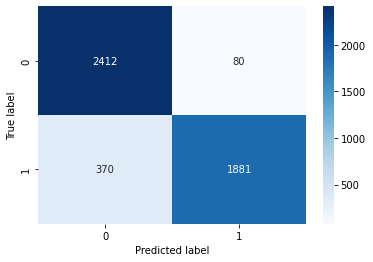

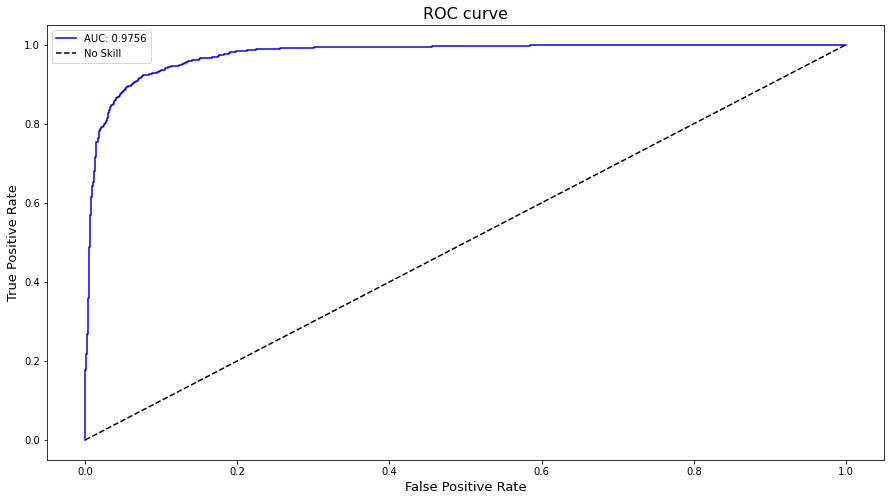

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix,classification_report

print("Accuracy: %g" %(accuracy_score(y_test_gender, pred_gender)))
print("Precision:", precision_score(y_test_gender, pred_gender))
print("Recall:", recall_score(y_test_gender, pred_gender))
print("f1_score:", f1_score(y_test_gender, pred_gender))

from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_test_gender,pred_gender)

import seaborn as sns
ax = sns.heatmap(conf,annot=True,fmt='d',cmap=plt.cm.Blues)
ax.set(xlabel="Predicted label",ylabel="True label")

from sklearn.metrics import roc_curve, roc_auc_score

pred_gender_prob = pred[1] #this is the array of probabilities

plt.figure(figsize=(15,8))
plt.title('ROC curve', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)

tpr, fpr,_ = roc_curve(y_test_gender,pred_gender_prob)
plt.plot(tpr,fpr,c='b',label='AUC: {:.4f}'.format(roc_auc_score(y_test_gender, pred_gender_prob)))

plt.plot([0, 1], [0, 1], 'k--', label='No Skill')

plt.legend()

Race:

Accuracy: 0.8300653594771242
Macro F1-score (multiclass) 0.7217435647455188


[Text(33.0, 0.5, 'True label'), Text(0.5, 15.0, 'Predicted label')]

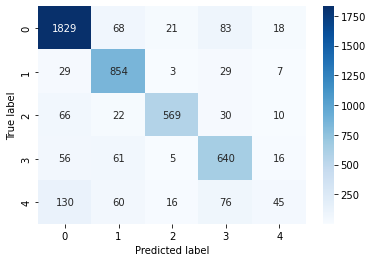

In [ ]:
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix

#since pred_race is a (4743,5) shaped numpy array we need to redefine it into 4743 list where each element has the index of the 5 lenght array where it is one.

pred_race = [int(np.where(pred_race[i] == 1)[0]) for i in range(len(pred_race))]

print('Accuracy: ' + str(metrics.accuracy_score(y_test_race, pred_race)))
print('Macro F1-score (multiclass) ' +  str(metrics.f1_score(y_test_race, pred_race,average='macro')))

conf = confusion_matrix(y_test_race,pred_race)

ax = sns.heatmap(conf,annot=True,fmt='d',cmap=plt.cm.Blues)
ax.set(xlabel="Predicted label",ylabel="True label")

The model didn't really improve, we got almost the same values at evaluation. This might be because at the hyperparameter optimization we minimized the val_loss, which counts the loss of the 3 target variables together. As we didn't have just one target variable (and all 3 are different types), we couldn't maximize just accuracy. That's why we decided to minimze the val_loss. And this might be the reason for the evaluation outcome.

#ImageNet model with optimal hyperparameters

Let's train the ImageNet model again, but now with the optimal hyperparameters, and then we evaluate the predictions to check the improvement.

In [ ]:
path_current = '/content/drive/MyDrive/Artificial_Incoherence_float_data'

os.chdir(path_current)

In [ ]:
import tensorflow.keras as keras

base_model = keras.applications.xception.Xception(weights="imagenet",
                                                 include_top=False)

X = keras.layers.GlobalAveragePooling2D()(base_model.output)

dense_1 = Dense(256, activation='relu')(X)
dense_2 = Dense(256, activation='relu')(dense_1)
dense_3 = Dense(256, activation='relu')(X)
dense_4 = Dense(256, activation='relu')(X)

dropout_1 = Dropout(0.498777)(dense_2)
dropout_2 = Dropout(0.495601)(dense_3)
dropout_3 = Dropout(0.382308)(dense_4)

output_1 = Dense(1,activation='relu', name='age_output')(dropout_1)
output_2 = Dense(1, activation='sigmoid', name='gender_output')(dropout_2)
output_3 = Dense(5, activation='softmax', name='race_output')(dropout_3)

model = keras.models.Model(inputs=base_model.input, outputs=[output_1,output_2,output_3])

import tensorflow as tf

for layer in base_model.layers: # freeze the weights of the base model
    layer.trainable = False

In [ ]:
model.compile(loss=['mse','binary_crossentropy','categorical_crossentropy'], optimizer='adam',loss_weights = [0.001,0.5,0.5],
              metrics = {'age_output': 'mean_squared_error', 'gender_output': 'accuracy', 'race_output': 'accuracy'})

In [ ]:
# loading y_train data 
with open("./y_train.pkl","rb") as f:
    y_train = pickle.load(file=f)


y_train_part1 = y_train[:5000]
y_train_part2 = y_train[5000:10000]
y_train_part3 = y_train[10000:15000]
y_train_part4 = y_train[15000:]

y_train_1_age = y_train_part1.age
y_train_1_gender = y_train_part1.gender
y_train_1_race = y_train_part1.race

y_train_2_age = y_train_part2.age
y_train_2_gender = y_train_part2.gender
y_train_2_race = y_train_part2.race

y_train_3_age = y_train_part3.age
y_train_3_gender = y_train_part3.gender
y_train_3_race = y_train_part3.race

y_train_4_age = y_train_part4.age
y_train_4_gender = y_train_part4.gender
y_train_4_race = y_train_part4.race


y_train_1_race = to_categorical(y_train_1_race,5)
y_train_2_race = to_categorical(y_train_2_race,5)
y_train_3_race = to_categorical(y_train_3_race,5)
y_train_4_race = to_categorical(y_train_4_race,5)

### Training on X_train_part1

In [ ]:
# loading X_train_part1 data 
with open("./X_train_part1.pkl","rb") as f:
    X_train_part1 = pickle.load(file=f)

X_train_part1 = X_train_part1.reshape(-1,200,200,3)

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('model_opt_imagenet_part1.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)

In [ ]:
history = model.fit(x=X_train_part1,
                    y=[y_train_1_age, y_train_1_gender, y_train_1_race],
                    batch_size = 32,
                    epochs=50,
                    validation_split= 0.1,
                    callbacks = [es, save_best, plateau])

Epoch 1/50
141/141 [==============================] - 31s 137ms/step - loss: 1.1006 - age_output_loss: 280.3612 - gender_output_loss: 0.3978 - race_output_loss: 1.2426 - age_output_mean_squared_error: 280.3612 - gender_output_accuracy: 0.8229 - race_output_accuracy: 0.5207 - val_loss: 0.8725 - val_age_output_loss: 153.3448 - val_gender_output_loss: 0.3590 - val_race_output_loss: 1.0793 - val_age_output_mean_squared_error: 153.3448 - val_gender_output_accuracy: 0.8360 - val_race_output_accuracy: 0.6040 - lr: 0.0010
Epoch 2/50
141/141 [==============================] - 19s 133ms/step - loss: 0.8792 - age_output_loss: 172.0568 - gender_output_loss: 0.3443 - race_output_loss: 1.0700 - age_output_mean_squared_error: 172.0568 - gender_output_accuracy: 0.8469 - race_output_accuracy: 0.6009 - val_loss: 0.8007 - val_age_output_loss: 142.8706 - val_gender_output_loss: 0.3485 - val_race_output_loss: 0.9672 - val_age_output_mean_squared_error: 142.8706 - val_gender_output_accuracy: 0.8380 - val_ra

In [ ]:
del X_train_part1

### Training on X_train_part2

In [ ]:
from keras.models import load_model

model = load_model('model_opt_imagenet_part1.h5')

In [ ]:
# loading X_train_part2 data 
with open("./X_train_part2.pkl","rb") as f:
    X_train_part2 = pickle.load(file=f)

X_train_part2 = X_train_part2.reshape(-1,200,200,3)

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('model_opt_imagenet_part2.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)

In [ ]:
history = model.fit(x=X_train_part2,
                    y=[y_train_2_age, y_train_2_gender, y_train_2_race],
                    batch_size = 32,
                    epochs=50,
                    validation_split= 0.1,
                    callbacks = [es, save_best, plateau])

Epoch 1/50
141/141 [==============================] - 21s 140ms/step - loss: 0.8284 - age_output_loss: 153.8677 - gender_output_loss: 0.3373 - race_output_loss: 1.0119 - age_output_mean_squared_error: 153.8677 - gender_output_accuracy: 0.8558 - race_output_accuracy: 0.6253 - val_loss: 0.7257 - val_age_output_loss: 121.4448 - val_gender_output_loss: 0.2743 - val_race_output_loss: 0.9341 - val_age_output_mean_squared_error: 121.4448 - val_gender_output_accuracy: 0.8840 - val_race_output_accuracy: 0.6680 - lr: 3.0000e-04
Epoch 2/50
141/141 [==============================] - 19s 134ms/step - loss: 0.7706 - age_output_loss: 141.2037 - gender_output_loss: 0.3104 - race_output_loss: 0.9483 - age_output_mean_squared_error: 141.2037 - gender_output_accuracy: 0.8707 - race_output_accuracy: 0.6507 - val_loss: 0.7139 - val_age_output_loss: 118.0154 - val_gender_output_loss: 0.2737 - val_race_output_loss: 0.9180 - val_age_output_mean_squared_error: 118.0154 - val_gender_output_accuracy: 0.8880 - va

In [ ]:
del X_train_part2

### Training on X_train_part3

In [ ]:
from keras.models import load_model

model = load_model('model_opt_imagenet_part2.h5')

In [ ]:
# loading X_train_part3 data 
with open("./X_train_part3.pkl","rb") as f:
    X_train_part3 = pickle.load(file=f)

X_train_part3 = X_train_part3.reshape(-1,200,200,3)

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('model_opt_imagenet_part3.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)

In [ ]:
history = model.fit(x=X_train_part3,
                    y=[y_train_3_age, y_train_3_gender, y_train_3_race],
                    batch_size = 32,
                    epochs=50,
                    validation_split= 0.1,
                    callbacks = [es, save_best, plateau])

Epoch 1/50
141/141 [==============================] - 22s 143ms/step - loss: 0.7756 - age_output_loss: 134.2089 - gender_output_loss: 0.3168 - race_output_loss: 0.9659 - age_output_mean_squared_error: 134.2089 - gender_output_accuracy: 0.8613 - race_output_accuracy: 0.6529 - val_loss: 0.7593 - val_age_output_loss: 124.8779 - val_gender_output_loss: 0.3173 - val_race_output_loss: 0.9516 - val_age_output_mean_squared_error: 124.8779 - val_gender_output_accuracy: 0.8560 - val_race_output_accuracy: 0.6600 - lr: 9.0000e-05
Epoch 2/50
141/141 [==============================] - 20s 139ms/step - loss: 0.7545 - age_output_loss: 129.9336 - gender_output_loss: 0.3058 - race_output_loss: 0.9433 - age_output_mean_squared_error: 129.9336 - gender_output_accuracy: 0.8682 - race_output_accuracy: 0.6573 - val_loss: 0.7511 - val_age_output_loss: 125.6685 - val_gender_output_loss: 0.3182 - val_race_output_loss: 0.9326 - val_age_output_mean_squared_error: 125.6685 - val_gender_output_accuracy: 0.8540 - va

In [ ]:
del X_train_part3

### Training on X_train_part4

In [ ]:
from keras.models import load_model

model = load_model('model_opt_imagenet_part3.h5')

In [ ]:
# loading X_train_part4 data 
with open("./X_train_part4.pkl","rb") as f:
    X_train_part4 = pickle.load(file=f)

X_train_part4 = X_train_part4.reshape(-1,200,200,3)

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('model_opt_imagenet_part4.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)

In [ ]:
history = model.fit(x=X_train_part4,
                    y=[y_train_4_age, y_train_4_gender, y_train_4_race],
                    batch_size = 32,
                    epochs=50,
                    validation_split= 0.1,
                    callbacks = [es, save_best, plateau])

Epoch 1/50
112/112 [==============================] - 22s 170ms/step - loss: 0.7446 - age_output_loss: 130.1290 - gender_output_loss: 0.3053 - race_output_loss: 0.9237 - age_output_mean_squared_error: 130.1290 - gender_output_accuracy: 0.8693 - race_output_accuracy: 0.6687 - val_loss: 0.6834 - val_age_output_loss: 110.2537 - val_gender_output_loss: 0.3309 - val_race_output_loss: 0.8154 - val_age_output_mean_squared_error: 110.2537 - val_gender_output_accuracy: 0.8442 - val_race_output_accuracy: 0.7111 - lr: 8.1000e-06
Epoch 2/50
112/112 [==============================] - 16s 146ms/step - loss: 0.7397 - age_output_loss: 126.2456 - gender_output_loss: 0.3092 - race_output_loss: 0.9178 - age_output_mean_squared_error: 126.2456 - gender_output_accuracy: 0.8649 - race_output_accuracy: 0.6626 - val_loss: 0.6831 - val_age_output_loss: 110.1368 - val_gender_output_loss: 0.3309 - val_race_output_loss: 0.8151 - val_age_output_mean_squared_error: 110.1368 - val_gender_output_accuracy: 0.8442 - va

In [ ]:
del X_train_part4

### Evaluation

In [ ]:
from keras.models import load_model

model = load_model('model_opt_imagenet_part4.h5')

# loading X_test data 
with open("./X_test2.pkl","rb") as f:
    X_test = pickle.load(file=f)

X_test = X_test.reshape(-1,200,200,3)

pred = model.predict(X_test)

pred_age = pred[0].round()

pred_gender = pred[1]
pred_gender = pred_gender.round()

pred_race = pred[2]
pred_race = (pred_race == pred_race.max(axis=1, keepdims=1)).astype(float) #this turns the max value to 1 and the rest to 0

# loading y_test data 
with open("./y_test.pkl","rb") as f:
    y_test = pickle.load(file=f)

y_test_age = y_test.age
y_test_gender = y_test.gender
y_test_race = y_test.race

149/149 [==============================] - 18s 111ms/step


Age:

In [ ]:
from sklearn.metrics import mean_squared_error
import math

print("Evaluation of age attribute:")
print("MSE: " + str(mean_squared_error(y_test_age, pred_age)))
print("RMSE: " + str(math.sqrt(mean_squared_error(y_test_age, pred_age))))

Evaluation of age attribute:
MSE: 115.03731815306767
RMSE: 10.725545121487658


Gender:

Accuracy: 0.874552
Precision: 0.8733092876465284
Recall: 0.8605064415815193
f1_score: 0.8668605952114568


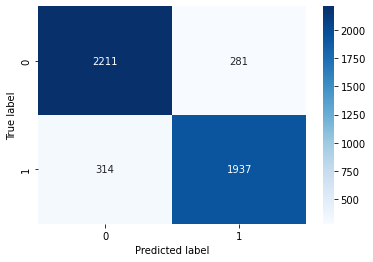

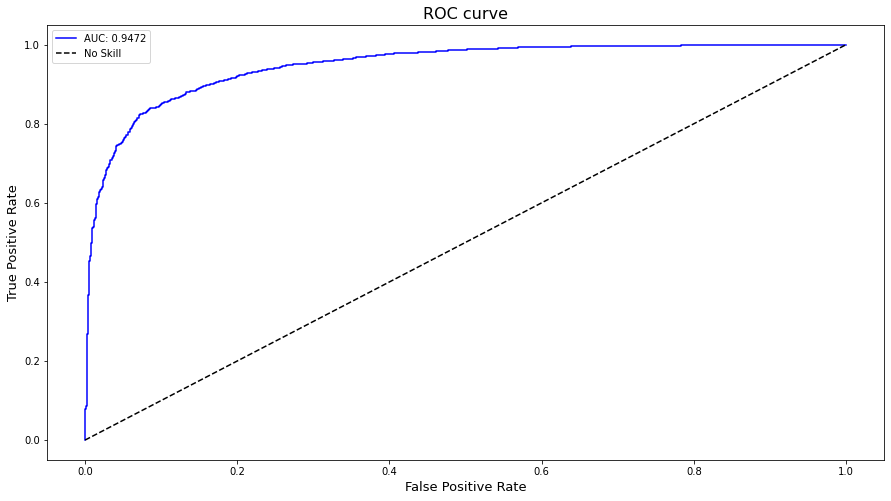

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix,classification_report

print("Accuracy: %g" %(accuracy_score(y_test_gender, pred_gender)))
print("Precision:", precision_score(y_test_gender, pred_gender))
print("Recall:", recall_score(y_test_gender, pred_gender))
print("f1_score:", f1_score(y_test_gender, pred_gender))

from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_test_gender,pred_gender)

import seaborn as sns
ax = sns.heatmap(conf,annot=True,fmt='d',cmap=plt.cm.Blues)
ax.set(xlabel="Predicted label",ylabel="True label")

from sklearn.metrics import roc_curve, roc_auc_score

pred_gender_prob = pred[1] #this is the array of probabilities

plt.figure(figsize=(15,8))
plt.title('ROC curve', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)

tpr, fpr,_ = roc_curve(y_test_gender,pred_gender_prob)
plt.plot(tpr,fpr,c='b',label='AUC: {:.4f}'.format(roc_auc_score(y_test_gender, pred_gender_prob)))

plt.plot([0, 1], [0, 1], 'k--', label='No Skill')

plt.legend()

Race:

Accuracy: 0.6772085178157284
Macro F1-score (multiclass) 0.5596971508374832


[Text(33.0, 0.5, 'True label'), Text(0.5, 15.0, 'Predicted label')]

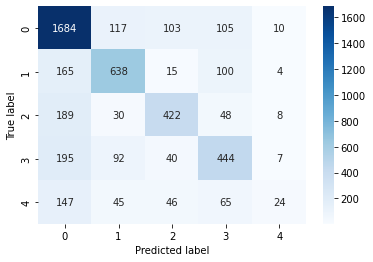

In [ ]:
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix

#since pred_race is a (4743,5) shaped numpy array we need to redefine it into 4743 list where each element has the index of the 5 lenght array where it is one.

pred_race = [int(np.where(pred_race[i] == 1)[0]) for i in range(len(pred_race))]

print('Accuracy: ' + str(metrics.accuracy_score(y_test_race, pred_race)))
print('Macro F1-score (multiclass) ' +  str(metrics.f1_score(y_test_race, pred_race,average='macro')))

conf = confusion_matrix(y_test_race,pred_race)

ax = sns.heatmap(conf,annot=True,fmt='d',cmap=plt.cm.Blues)
ax.set(xlabel="Predicted label",ylabel="True label")

The model didn't really improve, we got almost the same values at evaluation. This might be because at the hyperparameter optimization we minimized the val_loss, which counts the loss of the 3 target variables together. As we didn't have just one target variable (and all 3 are different types), we couldn't maximize just accuracy. That's why we decided to minimze the val_loss. And this might be the reason for the evaluation outcome.

# CNN model with optimal hyperparameters

Let's train the CNN model again, but now with the optimal hyperparameters, and then we evaluate the predictions to check the improvement.

In [ ]:
path_current = '/content/drive/MyDrive/Artificial_Incoherence_float_data'

os.chdir(path_current)

In [ ]:
input_size = (200,200,3)

inputs = Input((input_size))

X = Conv2D(64, (3, 3), activation='relu', kernel_initializer = initializers.glorot_uniform(seed=0))(inputs)
X = MaxPooling2D((3, 3))(X)

X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Flatten()(X)

dense_1 = Dense(256, activation='relu')(X)
dense_2 = Dense(256, activation='relu')(dense_1)
dense_3 = Dense(256, activation='relu')(X)
dense_4 = Dense(256, activation='relu')(X)

dropout_1 = Dropout(0.498777)(dense_2)
dropout_2 = Dropout(0.495601)(dense_3)
dropout_3 = Dropout(0.382308)(dense_4)

output_1 = Dense(1,activation='relu', name='age_output')(dropout_1)
output_2 = Dense(1, activation='sigmoid', name='gender_output')(dropout_2)
output_3 = Dense(5, activation='softmax', name='race_output')(dropout_3)

model = Model(inputs=[inputs], outputs=[output_1,output_2,output_3])

In [ ]:
model.compile(loss=['mse','binary_crossentropy','categorical_crossentropy'], optimizer='adam', loss_weights = [0.001,0.5,0.5], 
              metrics = {'age_output': 'mean_squared_error', 'gender_output': 'accuracy', 'race_output': 'accuracy'})

In [ ]:
# loading y_train data 
with open("./y_train.pkl","rb") as f:
    y_train = pickle.load(file=f)


y_train_part1 = y_train[:5000]
y_train_part2 = y_train[5000:10000]
y_train_part3 = y_train[10000:15000]
y_train_part4 = y_train[15000:]

y_train_1_age = y_train_part1.age
y_train_1_gender = y_train_part1.gender
y_train_1_race = y_train_part1.race

y_train_2_age = y_train_part2.age
y_train_2_gender = y_train_part2.gender
y_train_2_race = y_train_part2.race

y_train_3_age = y_train_part3.age
y_train_3_gender = y_train_part3.gender
y_train_3_race = y_train_part3.race

y_train_4_age = y_train_part4.age
y_train_4_gender = y_train_part4.gender
y_train_4_race = y_train_part4.race


y_train_1_race = to_categorical(y_train_1_race,5)
y_train_2_race = to_categorical(y_train_2_race,5)
y_train_3_race = to_categorical(y_train_3_race,5)
y_train_4_race = to_categorical(y_train_4_race,5)

### Training on X_train_part1

In [ ]:
# loading X_train_part1 data 
with open("./X_train_part1.pkl","rb") as f:
    X_train_part1 = pickle.load(file=f)

X_train_part1 = X_train_part1.reshape(-1,200,200,3)

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('model_opt_cnn_part1.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)

In [ ]:
model_history = model.fit(x=X_train_part1,
                          y=[y_train_1_age, y_train_1_gender, y_train_1_race],
                          batch_size = 128,
                          epochs=50,
                          validation_split= 0.1,
                          callbacks = [es, save_best, plateau])

Epoch 1/50
36/36 [==============================] - 28s 351ms/step - loss: 1.7632 - age_output_loss: 631.5964 - gender_output_loss: 0.7130 - race_output_loss: 1.5502 - age_output_mean_squared_error: 631.5964 - gender_output_accuracy: 0.5856 - race_output_accuracy: 0.3869 - val_loss: 1.4057 - val_age_output_loss: 422.9199 - val_gender_output_loss: 0.6271 - val_race_output_loss: 1.3384 - val_age_output_mean_squared_error: 422.9199 - val_gender_output_accuracy: 0.6840 - val_race_output_accuracy: 0.4640 - lr: 0.0010
Epoch 2/50
36/36 [==============================] - 11s 300ms/step - loss: 1.3924 - age_output_loss: 411.8599 - gender_output_loss: 0.5890 - race_output_loss: 1.3720 - age_output_mean_squared_error: 411.8599 - gender_output_accuracy: 0.6884 - race_output_accuracy: 0.4476 - val_loss: 1.2250 - val_age_output_loss: 325.5581 - val_gender_output_loss: 0.5697 - val_race_output_loss: 1.2292 - val_age_output_mean_squared_error: 325.5581 - val_gender_output_accuracy: 0.7120 - val_race_o

In [ ]:
del X_train_part1

### Training on X_train_part2

In [ ]:
from keras.models import load_model

model = load_model('model_opt_cnn_part1.h5')

In [ ]:
# loading X_train_part2 data 
with open("./X_train_part2.pkl","rb") as f:
    X_train_part2 = pickle.load(file=f)

X_train_part2 = X_train_part2.reshape(-1,200,200,3)

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('model_opt_cnn_part2.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)

In [ ]:
history = model.fit(x=X_train_part2,
                    y=[y_train_2_age, y_train_2_gender, y_train_2_race],
                    batch_size = 128,
                    epochs=50,
                    validation_split= 0.1,
                    callbacks = [es, save_best, plateau])

Epoch 1/50
36/36 [==============================] - 14s 363ms/step - loss: 0.7212 - age_output_loss: 145.6353 - gender_output_loss: 0.3325 - race_output_loss: 0.8186 - age_output_mean_squared_error: 145.6353 - gender_output_accuracy: 0.8578 - race_output_accuracy: 0.7182 - val_loss: 0.6386 - val_age_output_loss: 117.1481 - val_gender_output_loss: 0.3577 - val_race_output_loss: 0.6852 - val_age_output_mean_squared_error: 117.1481 - val_gender_output_accuracy: 0.8580 - val_race_output_accuracy: 0.7680 - lr: 3.0000e-04
Epoch 2/50
36/36 [==============================] - 12s 325ms/step - loss: 0.6489 - age_output_loss: 128.6621 - gender_output_loss: 0.3009 - race_output_loss: 0.7396 - age_output_mean_squared_error: 128.6621 - gender_output_accuracy: 0.8693 - race_output_accuracy: 0.7398 - val_loss: 0.6142 - val_age_output_loss: 115.7201 - val_gender_output_loss: 0.3165 - val_race_output_loss: 0.6805 - val_age_output_mean_squared_error: 115.7201 - val_gender_output_accuracy: 0.8740 - val_ra

In [ ]:
del X_train_part2

### Training on X_train_part3

In [ ]:
from keras.models import load_model

model = load_model('model_opt_cnn_part2.h5')

In [ ]:
# loading X_train_part3 data 
with open("./X_train_part3.pkl","rb") as f:
    X_train_part3 = pickle.load(file=f)

X_train_part3 = X_train_part3.reshape(-1,200,200,3)

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('model_opt_cnn_part3.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)

In [ ]:
history = model.fit(x=X_train_part3,
                    y=[y_train_3_age, y_train_3_gender, y_train_3_race],
                    batch_size = 128,
                    epochs=50,
                    validation_split= 0.1,
                    callbacks = [es, save_best, plateau])

Epoch 1/50
36/36 [==============================] - 24s 369ms/step - loss: 0.6386 - age_output_loss: 132.4116 - gender_output_loss: 0.2793 - race_output_loss: 0.7330 - age_output_mean_squared_error: 132.4116 - gender_output_accuracy: 0.8753 - race_output_accuracy: 0.7464 - val_loss: 0.5999 - val_age_output_loss: 120.3353 - val_gender_output_loss: 0.2821 - val_race_output_loss: 0.6770 - val_age_output_mean_squared_error: 120.3353 - val_gender_output_accuracy: 0.8580 - val_race_output_accuracy: 0.7760 - lr: 3.0000e-04
Epoch 2/50
36/36 [==============================] - 10s 290ms/step - loss: 0.5929 - age_output_loss: 115.5360 - gender_output_loss: 0.2599 - race_output_loss: 0.6948 - age_output_mean_squared_error: 115.5360 - gender_output_accuracy: 0.8904 - race_output_accuracy: 0.7582 - val_loss: 0.5869 - val_age_output_loss: 119.2883 - val_gender_output_loss: 0.2700 - val_race_output_loss: 0.6652 - val_age_output_mean_squared_error: 119.2883 - val_gender_output_accuracy: 0.8740 - val_ra

In [ ]:
del X_train_part3

### Training on X_train_part4

In [ ]:
from keras.models import load_model

model = load_model('model_opt_cnn_part3.h5')

In [ ]:
# loading X_train_part4 data 
with open("./X_train_part4.pkl","rb") as f:
    X_train_part4 = pickle.load(file=f)

X_train_part4 = X_train_part4.reshape(-1,200,200,3)

In [ ]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('model_opt_cnn_part4.h5', monitor='val_loss', save_best_only=True,mode='min')  ## Saves the best version of the model to disk (as measured on the validation data set)

In [ ]:
history = model.fit(x=X_train_part4,
                    y=[y_train_4_age, y_train_4_gender, y_train_4_race],
                    batch_size = 128,
                    epochs=50,
                    validation_split= 0.1,
                    callbacks = [es, save_best, plateau])

Epoch 1/50
28/28 [==============================] - 12s 425ms/step - loss: 0.5807 - age_output_loss: 112.5389 - gender_output_loss: 0.2632 - race_output_loss: 0.6731 - age_output_mean_squared_error: 112.5389 - gender_output_accuracy: 0.8853 - race_output_accuracy: 0.7784 - val_loss: 0.5239 - val_age_output_loss: 81.7599 - val_gender_output_loss: 0.2755 - val_race_output_loss: 0.6088 - val_age_output_mean_squared_error: 81.7599 - val_gender_output_accuracy: 0.8894 - val_race_output_accuracy: 0.7789 - lr: 9.0000e-05
Epoch 2/50
28/28 [==============================] - 9s 316ms/step - loss: 0.5494 - age_output_loss: 105.8494 - gender_output_loss: 0.2431 - race_output_loss: 0.6440 - age_output_mean_squared_error: 105.8494 - gender_output_accuracy: 0.8962 - race_output_accuracy: 0.7832 - val_loss: 0.5226 - val_age_output_loss: 80.4955 - val_gender_output_loss: 0.2775 - val_race_output_loss: 0.6068 - val_age_output_mean_squared_error: 80.4955 - val_gender_output_accuracy: 0.8920 - val_race_ou

In [ ]:
del X_train_part4

### Evaluation

In [ ]:
from keras.models import load_model

model = load_model('model_opt_cnn_part4.h5')

# loading X_test data 
with open("./X_test2.pkl","rb") as f:
    X_test = pickle.load(file=f)

X_test = X_test.reshape(-1,200,200,3)

pred = model.predict(X_test)

pred_age = pred[0].round()

pred_gender = pred[1]
pred_gender = pred_gender.round()

pred_race = pred[2]
pred_race = (pred_race == pred_race.max(axis=1, keepdims=1)).astype(float) #this turns the max value to 1 and the rest to 0

# loading y_test data 
with open("./y_test.pkl","rb") as f:
    y_test = pickle.load(file=f)

y_test_age = y_test.age
y_test_gender = y_test.gender
y_test_race = y_test.race

149/149 [==============================] - 5s 26ms/step


Age:

In [ ]:
from sklearn.metrics import mean_squared_error
import math

print("Evaluation of age attribute:")
print("MSE: " + str(mean_squared_error(y_test_age, pred_age)))
print("RMSE: " + str(math.sqrt(mean_squared_error(y_test_age, pred_age))))

Evaluation of age attribute:
MSE: 89.7843137254902
RMSE: 9.475458496848065


Gender:

Accuracy: 0.902382
Precision: 0.8945278022947926
Recall: 0.9004886717014661
f1_score: 0.8974983396059332


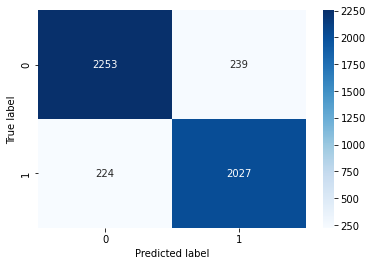

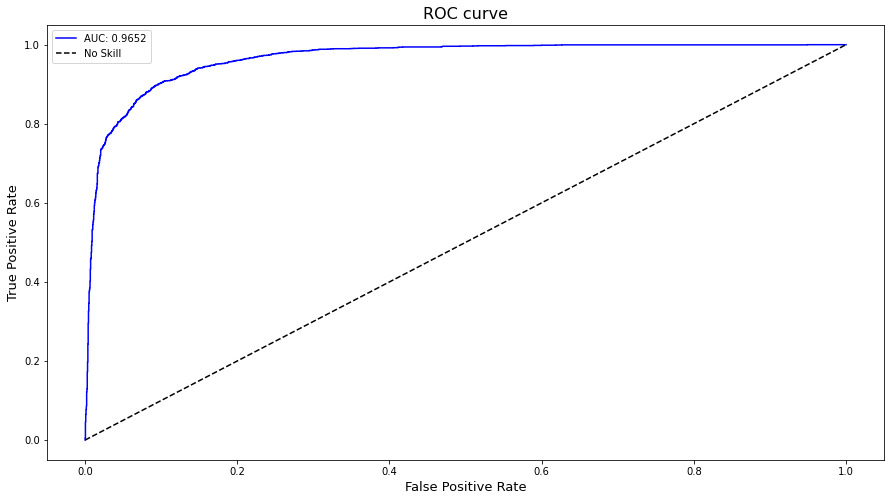

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix,classification_report

print("Accuracy: %g" %(accuracy_score(y_test_gender, pred_gender)))
print("Precision:", precision_score(y_test_gender, pred_gender))
print("Recall:", recall_score(y_test_gender, pred_gender))
print("f1_score:", f1_score(y_test_gender, pred_gender))

from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_test_gender,pred_gender)

import seaborn as sns
ax = sns.heatmap(conf,annot=True,fmt='d',cmap=plt.cm.Blues)
ax.set(xlabel="Predicted label",ylabel="True label")

from sklearn.metrics import roc_curve, roc_auc_score

pred_gender_prob = pred[1] #this is the array of probabilities

plt.figure(figsize=(15,8))
plt.title('ROC curve', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)

tpr, fpr,_ = roc_curve(y_test_gender,pred_gender_prob)
plt.plot(tpr,fpr,c='b',label='AUC: {:.4f}'.format(roc_auc_score(y_test_gender, pred_gender_prob)))

plt.plot([0, 1], [0, 1], 'k--', label='No Skill')

plt.legend()

Race:

Accuracy: 0.7992831541218638
Macro F1-score (multiclass) 0.6889710967776754


[Text(33.0, 0.5, 'True label'), Text(0.5, 15.0, 'Predicted label')]

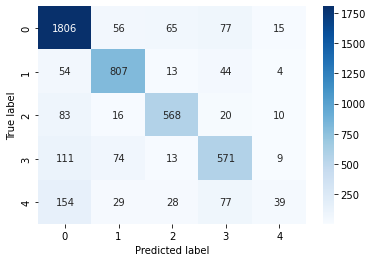

In [ ]:
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix

#since pred_race is a (4743,5) shaped numpy array we need to redefine it into 4743 list where each element has the index of the 5 lenght array where it is one.

pred_race = [int(np.where(pred_race[i] == 1)[0]) for i in range(len(pred_race))]

print('Accuracy: ' + str(metrics.accuracy_score(y_test_race, pred_race)))
print('Macro F1-score (multiclass) ' +  str(metrics.f1_score(y_test_race, pred_race,average='macro')))

conf = confusion_matrix(y_test_race,pred_race)

ax = sns.heatmap(conf,annot=True,fmt='d',cmap=plt.cm.Blues)
ax.set(xlabel="Predicted label",ylabel="True label")

The model didn't really improve, we got almost the same values at evaluation. This might be because at the hyperparameter optimization we minimized the val_loss, which counts the loss of the 3 target variables together. As we didn't have just one target variable (and all 3 are different types), we couldn't maximize just accuracy. That's why we decided to minimze the val_loss. And this might be the reason for the evaluation outcome.

#Summary

After trying several transfer learning models, and also a CNN model (defined by us), trying weighted modeling, SMOTE, using hyperparameter optimization, the best performaning model was the InceptionV3 model (saved as model_inceptionv3_part4.h5) and we got the following results:

*Evaluation of age attribute*:
- MSE: 70.00147585916086
- RMSE: 8.366688464330489

*Evaluation of gender attribute*
- Accuracy: 0.905123
- Precision: 0.9592044875063743
- Recall: 0.8356286095068858
- f1_score: 0.8931623931623931
- AUC: 0.9756

*Evaluation of race attribute*: 
- Accuracy: 0.8300653594771242
- Macro F1-score (multiclass) 0.7217435647455188